# Evaluation of the RAG Pipeline


## Introduction

In this notebook, we’ll pick up where it was left off by turning our attention to the patent side of things and then benchmarking the RAG pipeline with our generated Q&A questions. First, we’ll explore the Cleantech Google Patent dataset in detail to understand its structure and peculiarities. Next, we’ll prepare and index embeddings for both our media and patent corpora, so that our RAG system has a solid knowledge base to retrieve from. Finally, we’ll leverage the reference implementation provided by Prof. Dr. Daniel Perruchoud to run end-to-end evaluations over:

- The original “seed” evaluation set,

- Our QA  generated pairs generated.

We’ll break down performance by question category and by retrieval relevance, so that we can identify strengths, weaknesses, and opportunities for improvement in the RAG system. Let’s get started!


### Setup

To run this notebook we recommend downloading the provided [GitHub repository](https://github.com/LuciferUchiha/Cleantech-RAG) and opening this notebook in [Google Colab](https://colab.research.google.com/). To ensure a smooth experience, you'll need:

- An OpenAI API key for GPT-4o
- A Google account for Google Colab
- Python packages (automatically installed within the notebook)

At the start of the notebook a `data.zip` will be downloaded from a Google Drive and unzipped. This will then provide you with files that contain checkpoints for all of the expensive processing sections such as chunking, generating embeddings and evaluating the pipeline with an LLM as a judge. This saves you money and a lot of time.

If you can't or don't want to run this notebook you can also view the completed notebook by opening the `cleantech_rag.html` file in your browser.


## Setting your OpenAI Key

This OpenAI Key is used for the following tasks:
- Generating embeddings for our semantic search.
- Leveraging GPT-4-turbo as our LLM in our RAG pipeline and as our judge in RAGAS.

In [1]:
%%writefile .env
OPENAI_API_KEY=''

Writing .env


After executing the above cell, you should restart the kernel/runtime to ensure the key is properly set.

## Installing Dependencies

In [2]:
%%writefile requirements.txt

chromadb==0.5.0
datasets==2.19.1
gdown==5.2.0
kaggle==1.6.1
langchain==0.3.10
langchain-community==0.3.10
langchain-experimental==0.3.3
langchain-openai==0.2.12
langdetect==1.0.9
lorem-text==2.1
nbformat>=4.2.0
openai==1.57.1
plotly==5.22.0
pretty-jupyter==1.0
ragas==0.1.8
seaborn==0.13.2
sentence-transformers==3.0.0
spacy>=3.7
textstat==0.7.3
umap-learn==0.5.5

Writing requirements.txt


Before we dive into embeddings and RAG evaluation, we need to ensure our Python environment has the exact versions of PyTorch, fsspec, and related dependencies that are compatible with the rest of our tooling and GPU runtime. To archieve this run the commands bellow:

In [3]:
%pip install torch==2.5.1 --quiet --index-url https://download.pytorch.org/whl/cu121

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resol

In [4]:
%pip install -r ./requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [5]:
!pip install --upgrade fsspec==2025.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.3.1
    Uninstalling fsspec-2024.3.1:
      Successfully uninstalled fsspec-2024.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.19.1 requires fsspec[http]<=2024.3.1,>=2023.1.0, but you have fsspec 2025.3.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.5.1+cu121 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.5.1+cu121 which is incompatible.


In [6]:
!pip check

datasets 2.19.1 has requirement fsspec[http]<=2024.3.1,>=2023.1.0, but you have fsspec 2025.3.0.
torchaudio 2.6.0+cu124 has requirement torch==2.6.0, but you have torch 2.5.1+cu121.
gcsfs 2025.3.2 has requirement fsspec==2025.3.2, but you have fsspec 2025.3.0.
torchvision 0.21.0+cu124 has requirement torch==2.6.0, but you have torch 2.5.1+cu121.



To ensure that all newly installed packages are properly loaded and any old versions cleared from memory, please restart your notebook kernel after this cell. Once the kernel is back up, you’ll be ready to proceed with installing pytorch and importing the needed libraries.

In [7]:
!pip install --upgrade --force-reinstall gcsfs fsspec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.9/174.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
!pip uninstall torch torchvision -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 123.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

Note:if importing fails because of UMAP, run the cell again or reimport the UMAP only.

In [169]:
import json
import os
import warnings
import zipfile
import gdown
from collections import Counter
from pathlib import Path
from typing import Dict, List

import chromadb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import torch
import umap

pd.set_option('display.max_colwidth', 100)

from chromadb import Collection, Documents, EmbeddingFunction, Embeddings
from datasets import Dataset
from dotenv import load_dotenv
from langdetect import detect
from lorem_text import lorem
from ragas import RunConfig, evaluate
from ragas.metrics import (faithfulness, answer_relevancy, context_relevancy, answer_correctness)
from spacy.lang.en import English
from textstat import flesch_reading_ease
from tqdm import tqdm
from langchain.chains.base import Chain
from langchain.text_splitter import RecursiveCharacterTextSplitter, TextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma, VectorStore
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.language_models import LLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

nlp = English()
tokenizer = nlp.tokenizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

load_dotenv()
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


By running the two following cells below, you can download the dataset, chunks, embeddings of the chunks and evaluation results from our Google Drive. This will save you time and money.

In [435]:
data_folder = Path("./data")
if not data_folder.exists():
    data_folder.mkdir()

In [ ]:
file_id = "1VvlAUqXyUeSC35rMcmNoJgaFxIhjoHG4"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output="data.zip", quiet=True)

In [ ]:
with zipfile.ZipFile("data.zip", "r") as zip_file:
    zip_file.extractall(path=data_folder)


In [ ]:
# %%script echo skipping
# !gdown 1VmFQFogA4S7iy5iX2-Tsl3xa11zNnUFR

In [ ]:
# %%script echo skipping
# with zipfile.ZipFile("data.zip", "r") as zip_file:
#     zip_file.extractall()

### Setting up our LLM

To make sure our OpenAI Key is working we will test it by generating a response from GPT-4o which we will later on also be using in our RAG pipeline. Try some different prompts or questions to see how the model responds.

In [6]:
llm = ChatOpenAI(model="gpt-4o")
question_prompt = ChatPromptTemplate.from_template(
    "Answer the following question: {question}")
question_chain = question_prompt | llm | StrOutputParser()
question_chain.invoke({"question": "What is the meaning of life?"})

"The meaning of life is a deeply philosophical question that has been contemplated by thinkers, theologians, and individuals throughout history. Different cultures, religions, and philosophies offer various interpretations, including:\n\n1. **Religious Perspectives**: Many religions suggest that the meaning of life is to fulfill a divine purpose, seek enlightenment, or achieve a connection with a higher power.\n\n2. **Philosophical Views**: Philosophers have proposed various theories, such as existentialism, which emphasizes individual freedom and choice, and utilitarianism, which focuses on the greatest happiness for the greatest number.\n\n3. **Personal Interpretations**: For many, the meaning of life is subjective and can be found in personal fulfillment, relationships, love, creativity, and the pursuit of knowledge.\n\nUltimately, the meaning of life may vary for each person, and it can be shaped by experiences, beliefs, and values. It's a question that invites exploration and refl

## Downloading the Dataset from Kaggle
We’ll use the kagglehub helper to pull in both our media and patent datasets directly into pandas DataFrames

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path_media_dataset_v3_2024_10_28 = "cleantech_media_dataset_v3_2024-10-28.csv"

articles_df  = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "jannalipenkova/cleantech-media-dataset",
  file_path_media_dataset_v3_2024_10_28,
)

file_path_media_dataset_v3_2024_09_20 = "cleantech_rag_evaluation_data_2024-09-20.csv"

human_eval = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "jannalipenkova/cleantech-media-dataset",
    file_path_media_dataset_v3_2024_09_20,
    pandas_kwargs={
        "sep": ";",
        "engine": "python",
        "encoding": "latin-1",
    }
)


In [ ]:

file_paths = [
    'bq-results-20240124-055833-1706076079048.json',
    'CleanTech_22-24.json',
    'CleanTech_22-24_updated.json'
]

dfs = {}

for file_path in file_paths:
   df = kagglehub.load_dataset(
       KaggleDatasetAdapter.PANDAS,
        "prakharbhandari20/cleantech-google-patent-dataset",
        "bq-results-20240124-055833-1706076079048.json",
        pandas_kwargs={
            "lines": True,
        })
   dfs[file_path] = df



patent_df = dfs['CleanTech_22-24_updated.json']

In [7]:
bronze_folder = data_folder / "bronze"
if not bronze_folder.exists():
    bronze_folder.mkdir()

## Loading the Dataset into Dataframes

We now load and inspect both the Cleantech Media Dataset and the gold-standard evaluation data provided by our subject matter expert, Janna Lipenkova.

In [8]:
articles_df = pd.read_csv(
    bronze_folder / "cleantech_media_dataset_v3_2024-10-28.csv",
    encoding='utf-8', index_col=0, on_bad_lines='skip')
articles_df.head()

title  \
93320                                                      XPeng Delivered ~100,000 Vehicles In 2021   
93321                                                  Green Hydrogen: Drop In Bucket Or Big Splash?   
98159            World’ s largest floating PV plant goes online in China – pv magazine International   
98158  Iran wants to deploy 10 GW of renewables over the next four years – pv magazine International   
31128                        Eastern Interconnection Power Grid Said ‘ Being Challenged in New Ways’   

             date  author  \
93320  2022-01-02     NaN   
93321  2022-01-02     NaN   
98159  2022-01-03     NaN   
98158  2022-01-03     NaN   
31128  2022-01-03     NaN   

                                                                                                   content  \
93320  ['Chinese automotive startup XPeng has shown one of the most dramatic auto production ramp-ups i...   
93321  ['Sinopec has laid plans to build the largest green hydrogen production facility in the world, b...   
98159  ['Huaneng Power International has switched on a 320 MW floating PV array in China’ s Shandong pr...   
98158  ['According to the Iranian authorities, there are currently more than 80GW of renewable energy p...   
31128  ['Sign in to get the best natural gas news and data. Follow the topics you want and receive the ...   

                domain  \
93320    cleantechnica   
93321    cleantechnica   
98159      pv-magazine   
98158      pv-magazine   
31128  naturalgasintel   

                                                                                                       url  
93320                        https://cleantechnica.com/2022/01/02/xpeng-delivered-100000-vehicles-in-2021/  
93321  https://cleantechnica.com/2022/01/02/its-a-green-hydrogen-drop-in-the-bucket-but-it-could-still-...  
98159        https://www.pv-magazine.com/2022/01/03/worlds-largest-floating-pv-plant-goes-online-in-china/  
98158  https://www.pv-magazine.com/2022/01/03/iran-wants-to-deploy-10-gw-of-renewables-over-the-next-fo...  
31128  https://www.naturalgasintel.com/eastern-interconnection-power-grid-said-being-challenged-in-new-...

In [9]:
patents_df = pd.read_json(bronze_folder /"CleanTech_22-24_updated.json", lines=True)
patents_df.head(5)

publication_number application_number country_code  \
0     CN-117138249-A  CN-202311356270-A           CN   
1     CN-117151396-A  CN-202311109834-A           CN   
2     CN-117141530-A  CN-202310980795-A           CN   
3     CN-117141244-A  CN-202311177651-A           CN   
4     CN-117146094-A  CN-202311272549-A           CN   

                                                                                                 title  \
0                                                                                            一种石墨烯光疗面罩   
1  Distributed economic scheduling method for wind, solar, biogas and hydrogen multi-energy multi-m...   
2                                                                                           氢能源动力轨道车辆组   
3                                                                                 一种汽车太阳能充电系统、方法及新能源汽车   
4                                                                                         一种水利水电管道连接装置   

                                                                                              abstract  \
0  The application provides a graphene phototherapy mask, and relates to the technical field of pho...   
1  The invention discloses a distributed economic dispatching method of a wind, solar and methane h...   
2  The invention discloses a hydrogen energy power rail vehicle group, which comprises a power vehi...   
3  The application discloses an automobile solar charging system, an automobile solar charging meth...   
4  The invention provides a water conservancy and hydropower pipeline connecting device, which effe...   

   publication_date  \
0          20231201   
1          20231201   
2          20231201   
3          20231201   
4          20231201   

                                                                        inventor  \
0                                                      [LI HAITAO, CAO WENQIANG]   
1                                                        [HU PENGFEI, LI ZIMENG]   
2                       [XIE BO, ZHANG SHUIQING, ZHOU FEI, LIU YONG, Zhou Houyi]   
3                                                               [ZHAO PENGCHENG]   
4  [LYU SHUOSHUO, LI PANFENG, XU ZHENGWEI, WANG WEIBIN, ZHANG CHEN, ZHOU HAIYUN]   

        cpc_code  
0  A61N2005/0654  
1      G06Q50/06  
2      Y02T90/40  
3      B60K16/00  
4      F16L55/02

In [10]:
# Keep only one row for each `publication_number`, ignoring differences in `cpc_code` or `inventor`
print(f"Number of rows before: {len(patents_df)}")
patents_df_unique = patents_df.drop_duplicates(subset=["publication_number","application_number","country_code", "title", "abstract", "publication_date"])
print(f"Number of rows after: {len(patents_df_unique)}")

Number of rows before: 406857
Number of rows after: 68125


In [11]:
publication_number_counts = patents_df_unique.groupby('publication_number').size().sort_values(ascending=False)
print(publication_number_counts)

publication_number
WO-2024027062-A1    10
WO-2024131301-A1    10
WO-2022183304-A1    10
EP-4052298-A1        8
WO-2022265333-A1     7
                    ..
US-11828147-B2       1
US-11828138-B2       1
US-11824484-B2       1
US-11824363-B2       1
ZA-202309063-B       1
Length: 31366, dtype: int64


In [12]:
# patents_df_unique.to_csv(bronze_folder / "cleantech_patents_with_lang.csv", index=False)
output_path = bronze_folder / "cleantech_patents_with_lang.csv"

if output_path.exists():
    patents_df_unique = pd.read_csv(output_path)
else:
    print("dataset not found. Running language detection...")

    # Detect language of title and abstract
    patents_df_unique["title_lang"] = patents_df_unique["title"].apply(detect)
    patents_df_unique["abstract_lang"] = patents_df_unique["abstract"].apply(detect)

    # Save full dataset
    patents_df_unique.to_csv(output_path, index=False)
    print(f"Saved full dataset with language detection: {output_path.name}")

# Filter only English rows
patents_df_unique_en = patents_df_unique[
    (patents_df_unique["title_lang"] == "en") &
    (patents_df_unique["abstract_lang"] == "en")
]


In [13]:
patents_df_unique_en.head(5)

publication_number application_number country_code  \
1     CN-117151396-A  CN-202311109834-A           CN   
5     CN-117147382-A  CN-202310985511-A           CN   
6     CN-113344288-B  CN-202110717505-A           CN   
8     CN-117153944-A  CN-202311209193-A           CN   
9     CN-116911695-B  CN-202311167289-A           CN   

                                                                                                 title  \
1  Distributed economic scheduling method for wind, solar, biogas and hydrogen multi-energy multi-m...   
5  Device for monitoring hydrogen atom crossing grain boundary diffusion by using SKPFM and testing...   
6  Cascade hydropower station group water level prediction method and device and computer readable ...   
8                        Heterojunction solar cell, preparation method thereof and photovoltaic module   
9                                              Flexible resource adequacy evaluation method and device   

                                                                                              abstract  \
1  The invention discloses a distributed economic dispatching method of a wind, solar and methane h...   
5  The invention provides a device and a method for monitoring hydrogen atom crossing grain boundar...   
6  The invention discloses a cascade hydropower station group water level prediction method, a casc...   
8  The application provides a heterojunction solar cell, a preparation method thereof and a photovo...   
9  The invention relates to a flexible resource adequacy evaluation method and device of an electri...   

   publication_date                                         inventor  \
1          20231201                      ['HU PENGFEI', 'LI ZIMENG']   
5          20231201  ['MA ZHAOXIANG', 'WANG CHENGXU', 'LIU ZHONGLI']   
6          20231201                                               []   
8          20231201                    ['TONG HONGBO', 'JIN YUPENG']   
9          20231201                                               []   

      cpc_code title_lang abstract_lang  
1    G06Q50/06         en            en  
5    G01N13/00         en            en  
6    G06Q10/04         en            en  
8   H01L31/074         en            en  
9  H02J2203/20         en            en

In [14]:
human_eval_df = pd.read_csv(
    bronze_folder / "cleantech_rag_evaluation_data_2024-09-20.csv",
    encoding='utf-8',
    # index_col=0,
    sep=';')
human_eval_df.head()

example_id  question_id  \
0           1            1   
1           2            2   
2           3            2   
3           4            3   
4           5            4   

                                                                                 question  \
0  What is the innovation behind Leclanché's new method to produce lithium-ion batteries?   
1                                            What is the EU’s Green Deal Industrial Plan?   
2                                            What is the EU’s Green Deal Industrial Plan?   
3                   What are the four focus areas of the EU's Green Deal Industrial Plan?   
4              When did the cooperation between GM and Honda on fuel cell vehicles start?   

                                                                                         relevant_text  \
0  Leclanché said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) ...   
1  The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive...   
2  The European counterpart to the US Inflation Reduction Act (IRA) aims to create an environment t...   
3  The new plan is fundamentally focused on four areas, or pillars: the regulatory environment, acc...   
4  What caught our eye was a new hookup between GM and Honda. Honda was also hammering away at the ...   

                                                                                                answer  \
0  Leclanché's innovation is using a water-based process instead of highly toxic organic solvents t...   
1  The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry...   
2  The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry...   
3  The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, acce...   
4                                                                                            July 2013   

                                                                                           article_url  
0  https://www.sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energ...  
1     https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/  
2    https://www.pv-magazine.com/2023/02/02/european-commission-introduces-green-deal-industrial-plan/  
3     https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/  
4  https://cleantechnica.com/2023/05/08/general-motors-seizes-the-fuel-cell-moment-with-green-hydro...

In [15]:
human_eval_df_media = pd.read_csv(
    bronze_folder / "generated_questions_media_qa_llama.csv",
    encoding='utf-8',
    # index_col=0,
    # sep=';'
    )

human_eval_df_media.head()

id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                               context  \
0  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
1  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
2  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
3  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
4  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   

                                                                                              question  \
0                                                      What is green hydrogen, and how is it produced?   
1  What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hy...   
2  What is the significance of the Energy Transitions Commission's report on making clean electrifi...   
3          How does green hydrogen compare to direct use of electricity in terms of energy efficiency?   
4  What are some of the examples of pilot projects testing the viability of green hydrogen in vario...   

                                                                                                answer  \
0  Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...   
1  The Neom project, a partnership between ACWA Power, Air Products, and NEOM, harnesses solar and ...   
2  The report highlights the need for a 30-year transition to electrify the global economy, providi...   
3  Green hydrogen production through electrolysis is less energy-efficient than direct use of elect...   
4  Various pilot projects are testing green hydrogen's viability in energy systems, demonstrating i...   

                                                 source_doc  \
0  https://www.azocleantech.com/article.aspx?ArticleID=1823   
1  https://www.azocleantech.com/article.aspx?ArticleID=1823   
2  https://www.azocleantech.com/article.aspx?ArticleID=1823   
3  https://www.azocleantech.com/article.aspx?ArticleID=1823   
4  https://www.azocleantech.com/article.aspx?ArticleID=1823   

                                              category  groundedness_score  \
0  Sustainability & Technological Innovation Questions                 5.0   
1  Sustainability & Technological Innovation Questions                 5.0   
2  Sustainability & Technological Innovation Questions                 5.0   
3  Sustainability & Technological Innovation Questions                 4.0   
4  Sustainability & Technological Innovation Questions                 5.0   

                                                                                     groundedness_eval  \
0  The provided context clearly explains what green hydrogen is, how it is produced through water e...   
1  The context provides a comprehensive overview of the significance of green hydrogen and its inte...   
2  The question regarding the significance of the Energy Transitions Commission's report "Making Cl...   
3  The question requires an in-depth analysis of the context provided, specifically focusing on the...   
4  The question can be answered unambiguously based on the provided context, which describes variou...   

   relevance_score  \
0              3.0   
1              4.0   
2              3.0   
3              4.0   
4              3.0   

                                                                                        relevance_eval  \
0  The question is straightforward and clear, inquiring about a specific concept (green hydrogen) a...   
1  The Neom project is a key concept in the context of green hydrogen integration, and understandin...   
2  This question appears to be relevant to environmental sustainability and energy policy, which mi..

In [16]:
human_eval_df_patent = pd.read_csv(
    bronze_folder / "generated_questions_patent_qa_llama.csv",
    encoding='utf-8',
    # index_col=0,
    # sep=';'
    )
human_eval_df_patent.head()

id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                               context  \
0  Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...   
1  Water path manifold structure of hydrogen energy automobile electric pileThe utility model discl...   
2  Active power control method of water-fire-wind-solar energy storage multi-energy complementary i...   
3  Water conservancy and hydropower engineering construction tunnel internal flow guiding and drain...   
4  Medium-and-long-term electric power quantity balancing method for electric power system containi...   

                                                                                              question  \
0                                                 How does the system reduce the cost of cold storage?   
1                                                                What is good about the utility model?   
2  What is the purpose of using power supply with better regulation performance to compensate for p...   
3  What is the water conservancy and hydropower engineering construction hole inner diversion drain...   
4          What is the main consideration for the balancing method, in addition to safety and economy?   

                                                                                                answer  \
0  The system reduces the cost of cold storage by converting solar energy into electric energy, whi...   
1                   The utility model has a simple structure that is easy to assemble and disassemble.   
2  The power supply with better regulation performance is used to carry out compensation regulation...   
3  The utility model discloses a water conservancy and hydropower engineering construction hole inn...   
4  The seasonal characteristics of renewable energy sources in time and the coordination problem of...   

                                              category  groundedness_score  \
0  Sustainability & Technological Innovation Questions                 5.0   
1                   Analytical & Explanatory Questions                 5.0   
2                   Government & Corporate Initiatives                 5.0   
3  Sustainability & Technological Innovation Questions                 5.0   
4                   Analytical & Explanatory Questions                 4.0   

                                                                                     groundedness_eval  \
0    The question can be answered based on the given context, and the answer is clear and unambiguous.   
1  The question "What is good about the utility model?" is somewhat ambiguous without further clari...   
2  The question is clearly answerable by understanding the purpose of using power supply with bette...   
3  The question is clearly answerable with the given context, as it describes a specific inner dive...   
4  The context provides a detailed description of a method for balancing electric quantity in a pow...   

   relevance_score  \
0              4.0   
1              3.0   
2              3.0   
3              3.0   
4              4.0   

                                                                                        relevance_eval  \
0  The question is concise and to the point, directly asking about a specific aspect of how the Hug...   
1  The question is very short and to the point, but it lacks context and detail about the specific ...   
2  The question is directly related to power supply regulation and its impact on the performance of...   
3  The question seems to be about a specific technical term, which may be useful for machine learni...   
4  The question is asking about a specific aspect of the balancing method, which is a common techni...   

   standalone_score  \
0               5.0   
1               5.0   
2               5.0   
3               5.0   
4               5.0   

                      

## Explorative Data Analysis & Preprocessing

As the saying goes, "garbage in, garbage out."  In the realm of machine learning, the quality of our outputs hinges on the quality of our inputs.  This section delves into the essential processes of Exploratory Data Analysis (EDA) and data preprocessing. Through EDA, we'll illuminate the characteristics, patterns, and potential quirks residing within our cleantech news article dataset. Preprocessing will ensure our data is cleansed, structured, and prepared to be effectively utilized by the RAG pipeline, laying the foundation for high-quality results.

Let us start by gaining an overview of the datasets features (columns).

#### Media Datset

In [17]:
articles_df.describe()

author
count     0.0
mean      NaN
std       NaN
min       NaN
25%       NaN
50%       NaN
75%       NaN
max       NaN

In [18]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20111 entries, 93320 to 101431
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    20111 non-null  object 
 1   date     20111 non-null  object 
 2   author   0 non-null      float64
 3   content  20111 non-null  object 
 4   domain   20111 non-null  object 
 5   url      20111 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.6+ MB


Our initial exploration reveals that the "author" column only contains data for 31 out of 9593 articles. Since this offers minimal information gain, we can remove this feature.

We've also observed that some titles and content entries appear to be non-unique. This might necessitate identifying and removing duplicate entries.

On a positive note, the article URLs are all unique, potentially serving as suitable unique identifiers for the data.

In [19]:
articles_df = articles_df.drop(columns=["author"])

### Article Domains

The dataset helpfully provides the domain names extracted from the article URLs. These domains essentially represent the publishers of the news articles. Let's analyze the distribution of publishers and see how many articles each publisher has contributed.

In [20]:
domain_counts = articles_df["domain"].value_counts()
domain_counts

domain
energy-xprt              4181
pv-magazine              3093
azocleantech             2488
cleantechnica            2089
pv-tech                  1969
thinkgeoenergy           1052
solarpowerportal.co       850
energyvoice               828
solarpowerworldonline     785
solarindustrymag          621
solarquarter              606
rechargenews              573
naturalgasintel           298
iea                       173
energyintel               171
greenprophet              130
greenairnews               59
ecofriend                  55
all-energy                 39
decarbxpo                  20
storagesummit              15
eurosolar                   9
indorenergy                 4
bex-asia                    2
biofuels-news               1
Name: count, dtype: int64

A visualization helps us to understand the skew in the data.

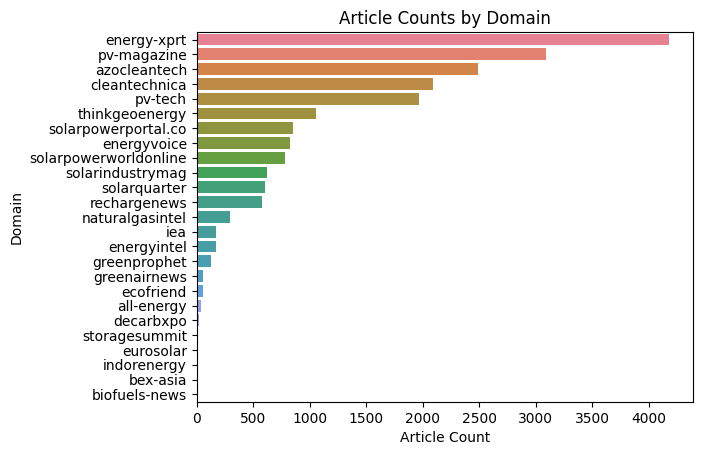

In [21]:
barplot = sns.barplot(
    x=domain_counts.values,
    y=domain_counts.index,
    hue=domain_counts.index
)

barplot.set_title('Article Counts by Domain')
barplot.set_xlabel('Article Count')
barplot.set_ylabel('Domain')

plt.show()

Our exploration of article domains reveals a skewed distribution.  Publishers like cleantechnica have a significantly higher representation (1861 articles), while others like indoenergy have minimal contributions (2 articles).  If we proceed with sampling this data, this imbalance should be taken into account. [Stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) is the recommended  approach to ensure a representative sample across different publishers.

### Article Dates

Each article within the dataset is accompanied by a publication date. Let's delve into the temporal range of these articles and investigate any noteworthy patterns in publication trends.

In [22]:
# plot the amount of articles over time
articles_df["date"] = pd.to_datetime(articles_df["date"])
time_df = articles_df.groupby("date").size().reset_index()
time_df.columns = ["date","count"]

time_df.describe()

date        count
count                            979   979.000000
mean   2023-05-26 05:11:49.703779328    20.542390
min              2022-01-02 00:00:00     1.000000
25%              2022-09-19 12:00:00     8.000000
50%              2023-05-26 00:00:00    17.000000
75%              2024-01-30 12:00:00    23.000000
max              2024-10-24 00:00:00  1812.000000
std                              NaN    76.837351

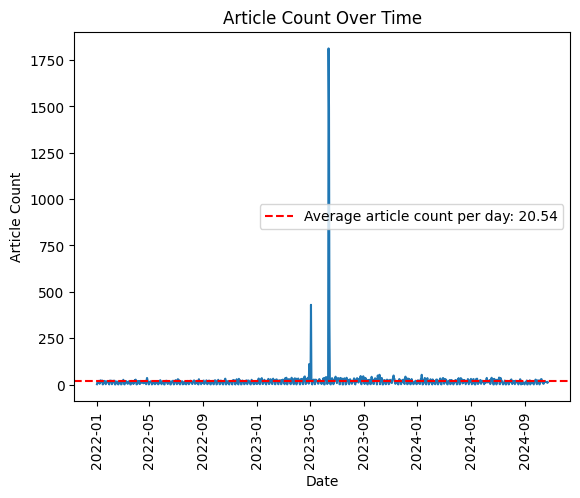

In [23]:
sns.lineplot(data=time_df, x="date", y="count")
plt.title("Article Count Over Time")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Article Count")
# add a line for the average
avg_count = time_df["count"].mean()
plt.axhline(avg_count, color='r', linestyle='--', label=f"Average article count per day: {avg_count:.2f}")
plt.legend()
plt.show()

While the daily article count appears consistent overall, a significant outlier disrupts the pattern on the 2023-12-05.  The cause of this outlier is undetermined, but it could potentially be the date the data was scraped and the default value assigned for missing dates. Since the publication date is not crucial for RAG pipeline, we can remove it.

In [24]:
articles_df = articles_df.drop(columns=["date"])

### Article Titles

As noted in our initial exploration, some articles share identical titles. Here, we'll focus on identifying and handling these duplicate titles to ensure a clean and consistent dataset for our RAG pipeline.

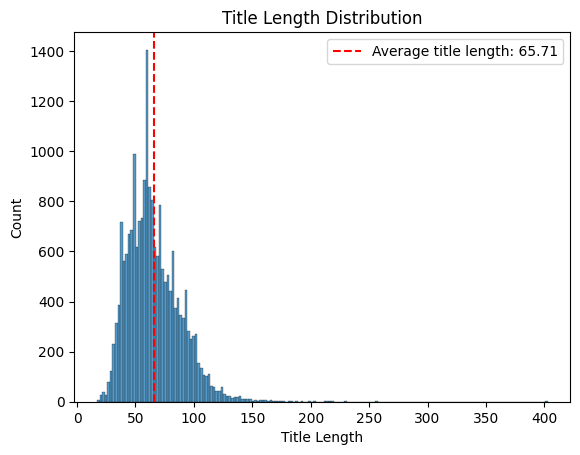

In [25]:
sns.histplot(articles_df["title"].str.len())
plt.title("Title Length Distribution")
plt.xlabel("Title Length")
plt.ylabel("Count")
avg_count = articles_df["title"].str.len().mean()
plt.axvline(avg_count, color='r', linestyle='--', label=f"Average title length: {avg_count:.2f}")
plt.legend()
plt.show()

In [26]:
articles_df["title"].duplicated().sum()

95

In [27]:
duplicate_titles = articles_df[articles_df["title"].duplicated(keep=False)].sort_values("title")
duplicate_titles.head(10)

title  \
105526              'Three quarters of power from wind '   
105527              'Three quarters of power from wind '   
13367               ACWA Power: Quotes, Address, Contact   
22292               ACWA Power: Quotes, Address, Contact   
13371           ADS-TEC Energy: Quotes, Address, Contact   
22256           ADS-TEC Energy: Quotes, Address, Contact   
22388   ALUULA Composites Inc.: Quotes, Address, Contact   
13366   ALUULA Composites Inc.: Quotes, Address, Contact   
13375               AMETEK STC: Quotes, Address, Contact   
22396               AMETEK STC: Quotes, Address, Contact   

                                                                                                    content  \
105526  ['Three quarters of Dutch power will come from wind by 2031, the chief of the Netherlands Wind E...   
105527  ['Three quarters of Dutch power will come from wind by 2031, the chief of the Netherlands Wind E...   
13367   ['We use cookies to enhance your experience. By continuing to browse this site you agree to our ...   
22292   ["By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site...   
13371   ['We use cookies to enhance your experience. By continuing to browse this site you agree to our ...   
22256   ["By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site...   
22388   ["By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site...   
13366   ['We use cookies to enhance your experience. By continuing to browse this site you agree to our ...   
13375   ['We use cookies to enhance your experience. By continuing to browse this site you agree to our ...   
22396   ["By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site...   

              domain  \
105526  rechargenews   
105527  rechargenews   
13367   azocleantech   
22292   azocleantech   
13371   azocleantech   
22256   azocleantech   
22388   azocleantech   
13366   azocleantech   
13375   azocleantech   
22396   azocleantech   

                                                                                                        url  
105526  https://www.rechargenews.com/wind/three-quarters-of-power-from-wind-dutch-aim-for-new-heights-wi...  
105527  https://www.rechargenews.com/wind/three-quarters-of-power-from-wind-dutch-aim-for-new-heights-wi...  
13367                                           https://www.azocleantech.com/suppliers.aspx?SupplierID=1869  
22292                                           https://www.azocleantech.com/Suppliers.aspx?SupplierID=1869  
13371                                           https://www.azocleantech.com/suppliers.aspx?SupplierID=2172  
22256                                           https://www.azocleantech.com/Suppliers.aspx?SupplierID=2172  
22388                                           https://www.azocleantech.com/Suppliers.aspx?SupplierID=2176  
13366                                           https://www.azocleantech.com/suppliers.aspx?SupplierID=2176  
13375                                           https://www.azocleantech.com/suppliers.aspx?SupplierID=1370  
22396                                           https://www.azocleantech.com/Suppliers.aspx?SupplierID=1370

In [28]:
duplicate_titles["content"].duplicated().sum()

6

Our exploration identified 24 titles that appear multiple times in the dataset. Examples include "About David J. Cross." Interestingly, while the titles are identical, the content itself appears to be unique.

Here are some additional observations for further investigation:
- A pattern was found where some articles begin with the phrase "By clicking." We'll delve into this further to determine the potential impact when analzing the article contents.
- We can observe instances of articles with seemingly similar content but differing URLs containing "sgvoice.energyvoice.com" and "energyvoice.com." Let's explore these cases to understand the potential distinction between them.

In [29]:
def wrap_text(text: str, char_per_line=100) -> str:
    # for better readability, wrap the text at the last space before the char_per_line
    if len(text) < char_per_line:
        return text
    else:
        return text[:char_per_line].rsplit(' ', 1)[0] + '\n' + wrap_text(text[len(text[:char_per_line].rsplit(' ', 1)[0])+1:], char_per_line)

In [30]:
print(duplicate_titles.iloc[0]["title"])
print(wrap_text(duplicate_titles.iloc[0]["content"]))

'Three quarters of power from wind '
['Three quarters of Dutch power will come from wind by 2031, the chief of the Netherlands Wind
Energy Association predicted, shortly after the government opened bidding for each of the Ijmujiden
Ver offshore wind sites, known respectively as Alpha 2GW and Beta 2GW.', 'Interested parties can
hand in bids between up to March 28 for the twin far offshore zones in the North Sea, in what is
the country’ s largest tender for wind at sea so far.', 'Recharge is part of DN Media Group. To
read more about DN Media Group, click here', 'Recharge is part of DN Media Group AS. From November
1st DN Media Group is responsible for controlling your data on Recharge.', 'We use your data to
ensure you have a secure and enjoyable user experience when visiting our site. You can read more
about how we handle your information in our privacy policy.', 'DN Media Group is the leading news
provider in the shipping, seafood, and energy industries, with a number of English- and


In [31]:
print(duplicate_titles.iloc[1]["title"])
print(wrap_text(duplicate_titles.iloc[1]["content"]))

'Three quarters of power from wind '
['Three quarters of Dutch power will come from wind by 2031, the chief of the Netherlands Wind
Energy Association predicted, shortly after the government opened bidding for each of the Ijmujiden
Ver offshore wind sites, known respectively as Alpha 2GW and Beta 2GW.', 'Interested parties can
hand in bids between up to March 28 for the twin far offshore zones in the North Sea, in what is
the country’ s largest tender for wind at sea so far.', 'Recharge is part of DN Media Group. To
read more about DN Media Group, click here', 'Recharge is part of DN Media Group AS. From November
1st DN Media Group is responsible for controlling your data on Recharge.', 'We use your data to
ensure you have a secure and enjoyable user experience when visiting our site. You can read more
about how we handle your information in our privacy policy.', 'DN Media Group is the leading news
provider in the shipping, seafood, and energy industries, with a number of English- and


Our analysis suggests potential redundancy within certain articles. In some cases, the second article might appear to be the first article with an additional sentence appended at the end.

Let's take a closer look at these "energyvoice" articles and how the contents start and see if we can eliminate these redundancies.

In [32]:
energyvoice_articles = articles_df[articles_df["domain"].str.contains("energyvoice")]
energyvoice_articles.content.map(lambda x: x[:50]).value_counts()

content
['', '', 'The Megawatt Hour is the latest podcast     6
['Two years after the Amazon Pledge Fund invested     3
['A group of trade associations from across the en    3
['Bruno Roche, Global Head of Energy Transition, A    2
['The cost of clean hydrogen will fall to that of     2
                                                     ..
['Researchers have found an alternative way to ext    1
['Controversy has been sparked over plans to build    1
['Systems change consultancy Systemiq has released    1
['ResponsibleSteel has launched a revised version     1
['With Prime Minister Keir Starmer hosting EU lead    1
Name: count, Length: 790, dtype: int64

In [33]:
def remove_prefix_articles(df: pd.DataFrame, prefix_len: int = 100) -> pd.DataFrame:
    """
    Takes O(n^2) time complexity
    If the first {prefix_len} characters of the article are the same, then we consider them as a prefix.
    If an article is a prefix of a longer article, then we remove it.
    If an article is a prefix of longer article, but they have different titles, then we keep them.
    """

    df["char_len"] = df["content"].map(len)
    df = df.sort_values(by='char_len', ascending=True).reset_index(drop=True)

    # Initialize a list to keep the articles that are not prefixes of others
    non_prefix_articles = []

    for i, row in df.iterrows():
        is_prefix = False
        content_i = row['content'][:prefix_len]
        title_i = row['title']

        for j in range(i + 1, len(df)):
            content_j = df.at[j, 'content'][:prefix_len]
            title_j = df.at[j, 'title']

            if content_i == content_j:
                # If the prefix matches but the titles are different, we keep it
                if title_i != title_j:
                    continue
                else:
                    is_prefix = True
                    break

        if not is_prefix:
            non_prefix_articles.append(row)

    print(f"Removed {len(df) - len(non_prefix_articles)} prefix articles")
    return pd.DataFrame(non_prefix_articles)

In [34]:
energyvoice_articles = remove_prefix_articles(energyvoice_articles)
energyvoice_articles.content.map(lambda x: x[:100]).value_counts()

Removed 11 prefix articles


content
['', '', 'The Megawatt Hour is the latest podcast boxset brought to you by Energy Voice Out Loud in     6
['A group of trade associations from across the energy sector have written to the Chancellor urging     3
['Two years after the Amazon Pledge Fund invested in Hippo Harvest, the company is selling its first    3
['Nicola Sturgeon will today reveal her government’ s new energy strategy on the future of the North    2
['Bruno Roche, Global Head of Energy Transition, ABB Process Automation, Energy Industries, outlines    2
                                                                                                       ..
['Oil and gas giant BP ( LSE: BP) has handed out a contract for work on a key North Sea carbon captu    1
['The jacket that supported the Ninian Northern platform for decades has completed its trip from the    1
['Over the next ten years, the Global Wind Energy Council predicts that more than 380GW of offshore     1
['An abrupt management shakeup at CHC has raised questions over turbulence at the North Sea helicopt    1
['The results of Scotland’ s first offshore wind leasing round in more than a decade are expected to    1
Name: count, Length: 791, dtype: int64

There still seem to be be some redundancy, but we did manage to remove 11 duplicates.

### Article Contents

Having explored various aspects of our dataset, we now turn our attention to the heart of the matter: the article content itself. This section will delve into the analysis and preprocessing techniques we'll employ to ensure the content is high-quality and effectively utilized by our RAG pipeline.

We start with a visual inspection of the article content.

In [35]:
np.random.seed(7)
random_sample_id = np.random.choice(articles_df.index)
print(wrap_text(articles_df.loc[random_sample_id, "content"]))

['Axis Energy, Juniper Green Energy, ReNew, and Acme have emerged as winners in NTPC’ s auction for
1.5 GW of wind-solar hybrid projects connected to India’ s interstate transmission system ( ISTS).
The average price was INR 3.30 ( $ 0.040) /kWh.', 'NTPC has concluded its ( Tranche-IV) tender for
ISTS-connected wind-solar hybrid capacity, with an average tariff of INR 3.30/kWh.', 'ABC Cleantech
( Axis Energy) won the biggest portion of 750 MW by quoting the lowest tariff of INR 3.27/kWh.
Juniper Green Energy secured 300 MW at INR 3.29/kWh. The rest of the capacity was allocated to
ReNew ( 300 MW) and ACME Cleantech ( 150 MW) at INR 3.32/kWh.', 'The winning developers will set up
the projects on a build-own-operate ( BOO) basis. The projects can be located anywhere in India and
must connect to the ISTS.', 'This content is protected by copyright and may not be reused. If you
want to cooperate with us and would like to reuse some of our content, please contact: editors @
pv-magazine.com.'

Our initial examination reveals that article content is currently stored as a list of strings. To gain deeper understanding and facilitate preprocessing, we'll transform these lists into a more cohesive textual format.

In [36]:
articles_df['article'] = articles_df['content'].apply(lambda x: ' '.join(eval(x)))
print(wrap_text(articles_df.loc[random_sample_id, "article"]))

Axis Energy, Juniper Green Energy, ReNew, and Acme have emerged as winners in NTPC’ s auction for
1.5 GW of wind-solar hybrid projects connected to India’ s interstate transmission system ( ISTS).
The average price was INR 3.30 ( $ 0.040) /kWh. NTPC has concluded its ( Tranche-IV) tender for
ISTS-connected wind-solar hybrid capacity, with an average tariff of INR 3.30/kWh. ABC Cleantech (
Axis Energy) won the biggest portion of 750 MW by quoting the lowest tariff of INR 3.27/kWh.
Juniper Green Energy secured 300 MW at INR 3.29/kWh. The rest of the capacity was allocated to
ReNew ( 300 MW) and ACME Cleantech ( 150 MW) at INR 3.32/kWh. The winning developers will set up
the projects on a build-own-operate ( BOO) basis. The projects can be located anywhere in India and
must connect to the ISTS. This content is protected by copyright and may not be reused. If you want
to cooperate with us and would like to reuse some of our content, please contact: editors @
pv-magazine.com. Please be mind

In [37]:
articles_df["article"].duplicated().sum()

43

In [38]:
duplicate_articles = articles_df[articles_df["article"].duplicated(keep=False)].sort_values("article")
duplicate_articles

title  \
92379                                               Solar Plant Monitoring ( Energy Monitoring) Articles   
89712                                                    Solar Plant Monitoring ( Solar Energy) Articles   
89587                                                            Backup Power ( Power Distribution) News   
91830                                                             Backup Power ( Energy Management) News   
36043                           Green Prophet - Page 10 of 692 - Sustainability news for the Middle East   
...                                                                                                  ...   
13364                                                   Mosaic Materials, Inc.: Quotes, Address, Contact   
100453  Will new Portuguese administration reduce EU funding for renewables? – pv magazine International   
100455                             How can policy help Portugal decarbonize? – pv magazine International   
92336                                                Renewable Energy Storage ( Energy Storage) Articles   
89383                                              Renewable Energy Storage ( Renewable Energy) Articles   

                                                                                                    content  \
92379   ["2023-01-10 00:00For buyers of energy meters, the price, quality, functional characteristics, a...   
89712   ["2023-01-10 00:00For buyers of energy meters, the price, quality, functional characteristics, a...   
89587   ["A new report shows how California's premier public interest clean energy research and developm...   
91830   ["A new report shows how California's premier public interest clean energy research and developm...   
36043   ['A poetic look at climate change, drought and a celebrated Irish poet, James Joyce.', 'You want...   
...                                                                                                     ...   
13364   ['We use cookies to enhance your experience. By continuing to browse this site you agree to our ...   
100453  ['With ambitious decarbonization targets and a favourable regulatory landscape, Portugal is an a...   
100455  ['With ambitious decarbonization targets and a favourable regulatory landscape, Portugal is an a...   
92336   ["YTL, as an company of electricity meter, this Kenya exhibition brought us some Sentiment. The ...   
89383   ["YTL, as an company of electricity meter, this Kenya exhibition brought us some Sentiment. The ...   

              domain  \
92379    energy-xprt   
89712    energy-xprt   
89587    energy-xprt   
91830    energy-xprt   
36043   greenprophet   
...              ...   
13364   azocleantech   
100453   pv-magazine   
100455   pv-magazine   
92336    energy-xprt   
89383    energy-xprt   

                                                                                                        url  \
92379                         https://www.energy-xprt.com/energy-monitoring/solar-plant-monitoring/articles   
89712                              https://www.energy-xprt.com/solar-energy/solar-plant-monitoring/articles   
89587                                      https://www.energy-xprt.com/power-distribution/backup-power/news   
91830                                       https://www.energy-xprt.com/energy-management/backup-power/news   
36043                                                                 https://www.greenprophet.com/page/10/   
...                                                                                                     ...   
13364                                           https://www.azocleantech.com/Suppliers.aspx?SupplierID=1870   
100453  https://www.pv-magazine.com/2024/04/09/will-new-portuguese-administration-reduce-eu-funding-for-...   
100455  https://www.pv-magazine.com/2024/04/09/will-new-portuguese-administration-reduce-eu-funding-for-...   
92336                          https://www.energy-xprt.com/energy-stor

Our analysis uncovers additional insights regarding content duplication. We observe cases where seemingly identical articles are reposted on the same domain but with different titles (excluding the "sgvoice.energyvoice.com" vs. "energyvoice.com" scenario previously addressed). Here, we'll strategically keep these duplicates where contents are the same but titles are different.

**Importance of Titles**

We keep these duplicate articles because titles can hold information relevant for our RAG pipeline. Consider a scenario where a user query uses an abbreviation, while the corresponding article only contains the abbreviation in the title, in the content always the full term is used. To bridge this gap, we'll prepend titles to the article content during preprocessing. This ensures that the retrieval process considers not only the content itself, but also the potentially informative titles.

**Next Step**

As previously noted, some articles exhibit standardized introductions, possibly artifacts of the data scraping process. We'll develop appropriate techniques to handle these introductions during preprocessing, ensuring they don't hinder the effectiveness of our RAG pipeline.

In [39]:
articles_df.article.map(lambda x: x[:50]).value_counts()

article
By clicking `` Allow All '' you agree to the stori    1365
We use cookies to enhance your experience. By cont     865
Sign in to get the best natural gas news and data.     295
Create a free IEA account to download our reports      173
window.dojoRequire ( [ `` mojo/signup-forms/Loader      31
                                                      ... 
My family used to say I had an obsession with Tesl       1
Poland as part of a second phase of offshore wind        1
EOIs are being accepted by KenGen for land leases        1
Avangrid has achieved commercial operation on the        1
The perovskite-silicon tandem device has a two ter       1
Name: count, Length: 15021, dtype: int64

In [40]:
artifacts = [
    "By clicking `` Allow All '' you agree to the sto",
    "Sign in to get the best natural gas news and dat",
    "window.dojoRequire ( [ `` mojo/signup-forms/Load"
]

for artifact in artifacts:
    print(wrap_text(articles_df[articles_df.article.str.startswith(artifact)].article.iloc[0][:500]))
    print()

By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site
navigation, analyse site usage and support us in providing free open access scientific content.
More info. Waga Energy is joining forces with Steuben County ( New York, USA) on a Renewable
Natural Gas ( RNG) project at the county’ s Bath landfill. The RNG produced will be injected in the
local grid and used as a biofuel to decarbonize mobility. The Steuben County landfill will be the
first in the US to

Sign in to get the best natural gas news and data. Follow the topics you want and receive the daily
emails. Your email address * Your password * Remember me Continue Reset password Featured Content
News & Data Services Client Support Daily GPI Infrastructure | NGI All News Access Electric
transmission planners with the Eastern Interconnection, a major power grid serving two-thirds of
the United States and Canada, recently gave a favorable review in their assessment of how well
regional plans m

In [41]:
def remove_scrapping_artifacts(df: pd.DataFrame, column: str) -> pd.DataFrame:
    text_artifacts = [
        "By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site navigation, analyse site usage and support us in providing free open access scientific content. More info.",
        "Sign in to get the best natural gas news and data. Follow the topics you want and receive the daily emails. Your email address * Your password * Remember me Continue Reset password Featured Content News & Data Services Client Support"
    ]

    regex_artifacts = [
        r"window.dojoRequire \( \[ .*\}\) \}\) "
    ]

    for pattern in text_artifacts:
        articles_df[column] = articles_df[column].str.replace(pattern, '', regex=False)

    for pattern in regex_artifacts:
        articles_df[column] = articles_df[column].str.replace(pattern, '', regex=True)

    return df

In [42]:
articles_df = remove_scrapping_artifacts(articles_df, "article")
articles_df.article.map(lambda x: x[:50]).value_counts()

article
We use cookies to enhance your experience. By cont    865
Create a free IEA account to download our reports     173
Welcome to Edinburgh Instruments’ monthly blog cel     26
Hydrogen Technology Expo & Carbon Capture Technolo     22
Over the last year Kipp & Zonen has received a lot     21
                                                     ... 
 If an electric car charges while driving, the siz      1
 A Brazilian study sets the stage for increased ef      1
The Windhager PuroWIN is the first wood chip boile      1
 Envetec Sustainable Technologies Limited ( `` Env      1
The perovskite-silicon tandem device has a two ter      1
Name: count, Length: 16569, dtype: int64

Our efforts have successfully eliminated a substantial portion of the scrapping artifacts within the articles. However, some traces  still persist, likely remnants of past website navigation structures. While removing these remaining artifacts could offer further refinement, it also presents a significant challenge. Therefore, we'll acknowledge this for now and move onto further preprocessing such as filtering out articles that are not written in English.

In [43]:
articles_df["lang"] = articles_df["article"].map(detect)
articles_df["lang"].value_counts()

lang
en    20106
de        3
ru        1
es        1
Name: count, dtype: int64

We will first inspect the language-specific assessment of our texts.

In [44]:
articles_df[articles_df["lang"] != "en"]

title  \
82317                          Open Letter to Presidents Putin, Biden, Zelenskyy and Lukashenko - EUROSOLAR   
126129  SMS group liefert Prozesstechnologie für das erste klimaneutrale Stahlwerk weltweit -- Expo for ...   
82320   Internationale Konferenz für Energiespeicher mit Erneuerbaren Energien ( International Renewable...   
82321                                                     Presentations, Poster and Photos of the IRES 2022   
101246                                              Solar + Storage España 2024 – pv magazine International   

                                                                                                    content  \
82317   ['EUROSOLAR, the European Association for Renewable Energy, calls for an immediate Climate Cease...   
126129  ['© SMS group liefert Prozesstechnologie für das klimaneutrale Stahlwerk in Schweden. ( Quelle: ...   
82320   ['Die nun zu Ende gegangene „ Internationale Erneuerbare Energiespeicher Konferenz “ ( IRES), wi...   
82321   ['Photos from the IRES ( Copyright EUROSOLAR e.V.)', 'Molten Salt Electrolyte in Na-ZnCl2 Solid-...   
101246  ['The event will feature a conference, workshops, and an exhibition dedicated to Distributed Gen...   

             domain  \
82317     eurosolar   
126129    decarbxpo   
82320     eurosolar   
82321     eurosolar   
101246  pv-magazine   

                                                                                                        url  \
82317                                                          https://www.eurosolar.de/sektionen/russland/   
126129  https://www.decarbxpo.com/en/News_Media/Magazine/Stories/SMS_group_liefert_Prozesstechnologie_fü...   
82320   https://www.eurosolar.de/2022/09/26/internationale-konferenz-fuer-energiespeicher-mit-erneuerbar...   
82321                 https://www.eurosolar.de/2022/10/20/presentations-poster-and-photos-of-the-ires-2022/   
101246                                                https://www.pv-magazine.com/pv-magazine-events/sse24/   

                                                                                                    article  \
82317   EUROSOLAR, the European Association for Renewable Energy, calls for an immediate Climate Cease F...   
126129  © SMS group liefert Prozesstechnologie für das klimaneutrale Stahlwerk in Schweden. ( Quelle: SM...   
82320   Die nun zu Ende gegangene „ Internationale Erneuerbare Energiespeicher Konferenz “ ( IRES), widm...   
82321   Photos from the IRES ( Copyright EUROSOLAR e.V.) Molten Salt Electrolyte in Na-ZnCl2 Solid-Elect...   
101246  The event will feature a conference, workshops, and an exhibition dedicated to Distributed Gener...   

       lang  
82317    ru  
126129   de  
82320    de  
82321    de  
101246   es

In [45]:
print(wrap_text(articles_df[articles_df["lang"] != "en"].iloc[1]["article"][1000:]))

ne bedeutende CO2-Reduzierung über die gesamte Prozesskette erreichen und uns damit von unseren
Marktbegleitern differenzieren. Wir haben uns bei diesem Projekt für SMS group entschieden, weil
uns ihre Expertise überzeugt hat, die sie in zahlreichen Projekten weltweit unter Beweis gestellt
haben. “ „ Wir sind sehr stolz darauf, die Technologie für das erste komplett klimaneutrale
Stahlwerk der Welt zu liefern “, sagte Burkhard Dahmen, Vorstandsvorsitzender der SMS group. „ Dies
ist nicht nur ein wichtiger Schritt für H2 Green Steel, sondern auch eine ausgezeichnete
Gelegenheit, unsere Kompetenz und unsere Mission der grünen Stahlerzeugung zu unterstreichen. “ SMS
group wird eine Midrex®-Direktreduktionsanlage, ein Elektrostahlwerk, eine CSP®
Nexus-Gieß-Walzanlage sowie einen fortschrittlichen Kaltwalz- und Bandanlagen-Komplex für die
Produktion eines breiten Produktmixes einschließlich hochfester Stahlgüten ( AHSS) und Stahlgüten
für die Automobilindustrie liefern. Führende Automobilhe

In [46]:
articles_df = articles_df[articles_df["lang"] == "en"]

#### Patent Datset
Here we focus on the preprocessing of Patent Dataset which has completely different format/structure than Media Dataset.

Removing the duplicates: We found out that there were a quite a lot duplicate data

In [47]:
# Keep only one row for each `publication_number`, ignoring differences in `cpc_code` or `inventor`
print(f"Number of rows before: {len(patents_df)}")
patents_df_unique = patents_df.drop_duplicates(subset=["publication_number","application_number","country_code", "title", "abstract", "publication_date"])
print(f"Number of rows after: {len(patents_df_unique)}")

Number of rows before: 406857
Number of rows after: 68125


In [48]:
publication_number_counts = patents_df_unique.groupby('publication_number').size().sort_values(ascending=False)
print(publication_number_counts)

publication_number
WO-2024027062-A1    10
WO-2024131301-A1    10
WO-2022183304-A1    10
EP-4052298-A1        8
WO-2022265333-A1     7
                    ..
US-11828147-B2       1
US-11828138-B2       1
US-11824484-B2       1
US-11824363-B2       1
ZA-202309063-B       1
Length: 31366, dtype: int64


Language detection and Filtering out other languages other than English.

In [49]:
# patents_df_unique.to_csv(bronze_folder / "cleantech_patents_with_lang.csv", index=False)
output_path = bronze_folder / "cleantech_patents_with_lang.csv"

if output_path.exists():
    patents_df_unique = pd.read_csv(output_path)
else:
    print("dataset not found. Running language detection...")

    # Detect language of title and abstract
    patents_df_unique["title_lang"] = patents_df_unique["title"].apply(detect)
    patents_df_unique["abstract_lang"] = patents_df_unique["abstract"].apply(detect)

    # Save full dataset
    patents_df_unique.to_csv(output_path, index=False)
    print(f"Saved full dataset with language detection: {output_path.name}")

# Filter only English rows
patents_df_unique_en = patents_df_unique[
    (patents_df_unique["title_lang"] == "en") &
    (patents_df_unique["abstract_lang"] == "en")
]


### Patent Topic modelling
As for media dataset we are given with Domain , but in case of there are no domains defined so we did topic modelling to group the articles

In [50]:
patents_df_unique_en.describe()

publication_date
count      2.868500e+04
mean       2.022829e+07
std        7.448034e+03
min        2.022010e+07
25%        2.022080e+07
50%        2.023032e+07
75%        2.023111e+07
max        2.024090e+07

In [51]:
patents_df_unique_en.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28685 entries, 1 to 68123
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   publication_number  28685 non-null  object
 1   application_number  28685 non-null  object
 2   country_code        28685 non-null  object
 3   title               28685 non-null  object
 4   abstract            28685 non-null  object
 5   publication_date    28685 non-null  int64 
 6   inventor            28685 non-null  object
 7   cpc_code            28685 non-null  object
 8   title_lang          28685 non-null  object
 9   abstract_lang       28685 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.4+ MB


####preprocess patent data
exploring the dataset and removing the non needed fields from the dataset

In [52]:
# Assuming patents_df_unique is already loaded with the data you pasted
patents_df = patents_df_unique_en.copy()

# Combine title + abstract
patents_df["text"] = patents_df["title"].fillna("") + ". " + patents_df["abstract"].fillna("")

# Basic preprocessing
stop_words = set(stopwords.words("english"))
def preprocess_text(text, apply_stemming=False):
    """
    Preprocess a given text by:
      - Converting to lowercase
      - Tokenizing
      - Removing punctuation and stop words
      - Applying lemmatization (and optionally stemming)
    """
    if not isinstance(text, str):
        return []

    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]

    # Join the tokens back into a single string
    return " ".join(tokens)


patents_df["cleaned_text"] = patents_df["text"].apply(preprocess_text)

####Vectorize with TF-IDF

In [53]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = vectorizer.fit_transform(patents_df["cleaned_text"])

####Extract Topics with NMF
Only categorizing in 10 topics : defined as 0 -9

In [54]:
n_topics = 10
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_features = nmf_model.fit_transform(tfidf)

# Show top keywords per topic
for i, topic in enumerate(nmf_model.components_):
    top_keywords = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"Topic {i}: {', '.join(top_keywords)}")


Topic 0: connected, end, body, fixedly, panel, frame, arranged, solar, rod, plate
Topic 1: storage, temperature, exchange, solar, geothermal, air, energy, pump, heating, heat
Topic 2: device, charging, battery, supply, electric, solar, generation, storage, energy, power
Topic 3: air, energy, fan, speed, generation, turbine, power, generator, blade, wind
Topic 4: carbon, liquid, cell, electrolysis, gas, energy, fuel, storage, production, hydrogen
Topic 5: pipeline, valve, heating, outlet, device, inlet, pump, pipe, tank, water
Topic 6: method, electrode, preparation, material, substrate, film, silicon, solar, cell, layer
Topic 7: roof, cleaning, frame, assembly, angle, generation, support, board, panel, photovoltaic
Topic 8: time, monitoring, based, step, scheduling, operation, method, data, hydropower, station
Topic 9: management, connected, acquisition, supply, detection, used, data, monitoring, control, module


In [55]:
patents_df["topic"] = nmf_features.argmax(axis=1)

# Show topic distribution
topic_distribution = patents_df["topic"].value_counts().sort_index()
print("\nTopic distribution:")
print(topic_distribution)



Topic distribution:
topic
0    4927
1    3653
2    3139
3    2680
4    1868
5    2734
6    3154
7    2151
8    3042
9    1337
Name: count, dtype: int64


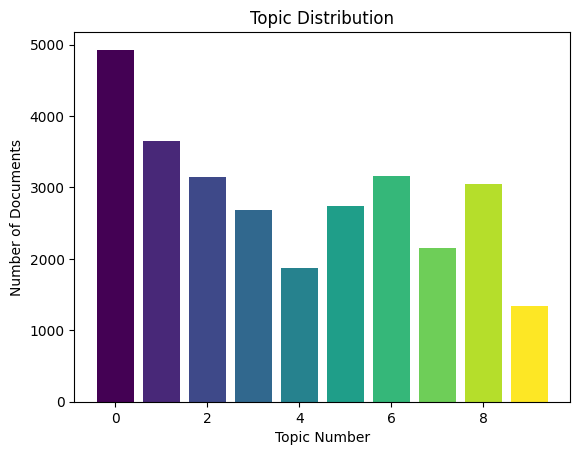

In [56]:
colors = plt.cm.viridis(np.linspace(0, 1, len(topic_distribution)))  # Use viridis colormap
plt.bar(topic_distribution.index, topic_distribution.values, color=colors)
plt.xlabel("Topic Number")
plt.ylabel("Number of Documents")
plt.title("Topic Distribution")
plt.show()

####Patent Dates

In [57]:
patents_df["publication_date"] = pd.to_datetime(patents_df["publication_date"].astype(str), errors='coerce') # Use errors='coerce' to handle invalid dates

# Similar to articles_df date handling:
patents_time_df = patents_df.groupby("publication_date").size().reset_index()
patents_time_df.columns = ["publication_date", "count"]

patents_time_df.describe()

publication_date       count
count                            626  626.000000
mean   2023-04-27 16:10:44.089456896   45.822684
min              2022-01-01 00:00:00    1.000000
25%              2022-08-27 00:00:00    3.000000
50%              2023-04-26 12:00:00   13.000000
75%              2023-12-25 12:00:00   94.000000
max              2024-09-05 00:00:00  241.000000
std                              NaN   52.190349

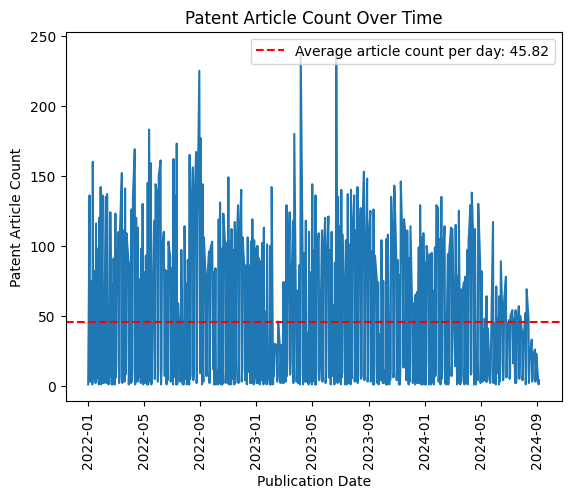

In [58]:
sns.lineplot(data=patents_time_df, x="publication_date", y="count")
plt.title("Patent Article Count Over Time")
plt.xlabel("Publication Date")
plt.xticks(rotation=90)
plt.ylabel("Patent Article Count")
# add a line for the average
avg_count = patents_time_df["count"].mean()
plt.axhline(avg_count, color='r', linestyle='--', label=f"Average article count per day: {avg_count:.2f}")
plt.legend()
plt.show()

removing date , as no relevance for our task and also has 52 Nan values

In [59]:
patents_df = patents_df.drop(columns=["publication_date"])

####Patent CPC code and inventor

In [60]:
from collections import defaultdict

inventor_counts = defaultdict(int)

for inventor_list in patents_df['inventor']:
    if inventor_list:
        for inventor in inventor_list:
            inventor_counts[inventor] += 1

# Convert the dictionary to a DataFrame
patents_new_df = pd.DataFrame(inventor_counts.items(), columns=['inventor', 'count'])

patents_new_df.describe()

count
count     113.000000
mean    12711.584071
std     32320.692165
min         1.000000
25%         4.000000
50%       353.000000
75%      8257.000000
max    196197.000000

In [61]:
patents_cpc_df = patents_df.groupby("cpc_code").size().reset_index()
patents_cpc_df.columns = ["cpc_code", "count"]

patents_cpc_df.describe()

count
count  6045.000000
mean      4.745244
std      47.672810
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max    3200.000000

Removing more unwanted columns

In [62]:
patents_df = patents_df.drop(columns=["cpc_code", "inventor"])

### Patent Titles
Here we found out that

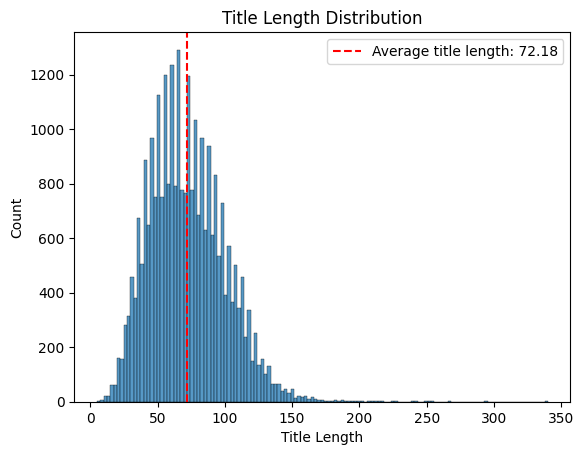

In [63]:
sns.histplot(patents_df["title"].str.len())
plt.title("Title Length Distribution")
plt.xlabel("Title Length")
plt.ylabel("Count")
avg_count = patents_df["title"].str.len().mean()
plt.axvline(avg_count, color='r', linestyle='--', label=f"Average title length: {avg_count:.2f}")
plt.legend()
plt.show()

In [64]:
patents_df["title"].duplicated().sum()

3404

In [65]:
duplicate_titles = patents_df[patents_df["title"].duplicated(keep=False)].sort_values("title")
duplicate_titles.head(10)

publication_number application_number country_code  \
36155     CN-216591460-U  CN-202123174925-U           CN   
61408     CN-216143672-U  CN-202122011678-U           CN   
21089     CN-217164845-U  CN-202220079258-U           CN   
23321     CN-216936150-U  CN-202220328747-U           CN   
35109     CN-216654721-U  CN-202122764875-U           CN   
9925      CN-218833988-U  CN-202223011290-U           CN   
35110     CN-216653908-U  CN-202220115116-U           CN   
8485      CN-114506947-B  CN-202210069053-A           CN   
36485     CN-114506947-A  CN-202210069053-A           CN   
19335     CN-114955614-A  CN-202210693867-A           CN   

                                                                        title  \
36155                                     5G communication wisdom street lamp   
61408                                     5G communication wisdom street lamp   
21089                   A breaker for hydraulic and hydroelectric engineering   
23321                   A breaker for hydraulic and hydroelectric engineering   
35109                   A breaker for hydraulic and hydroelectric engineering   
9925   A dust device for hydraulic and hydroelectric engineering construction   
35110  A dust device for hydraulic and hydroelectric engineering construction   
8485          A filtration system for hydraulic and hydroelectric engineering   
36485         A filtration system for hydraulic and hydroelectric engineering   
19335                            A industrial dust collector for feed bin top   

                                                                                                  abstract  \
36155  The utility model relates to the technical field of intelligent street lamps and discloses a 5G ...   
61408  The utility model relates to a street lamp, in particular to a 5G communication intelligent stre...   
21089  The utility model belongs to the technical field of a crushing device, in particular to a crushi...   
23321  The utility model provides a crusher for water conservancy and hydropower engineering, which rel...   
35109  The utility model discloses a crusher for water conservancy and hydropower engineering, which co...   
9925   The utility model discloses a dust device for hydraulic and hydroelectric engineering constructi...   
35110  The utility model relates to a dust-settling device for water conservancy and hydropower enginee...   
8485   The invention belongs to the technical field of filtering systems, and discloses a filtering sys...   
36485  The invention belongs to the technical field of filter systems, and discloses a filter system fo...   
19335  The invention relates to the technical field of industrial dust collectors, in particular to an ...   

      title_lang abstract_lang  \
36155         en            en   
61408         en            en   
21089         en            en   
23321         en            en   
35109         en            en   
9925          en            en   
35110         en            en   
8485          en            en   
36485         en            en   
19335         en            en   

                                                                                                      text  \
36155  5G communication wisdom street lamp. The utility model relates to the technical field of intelli...   
61408  5G communication wisdom street lamp. The utility model relates to a street lamp, in particular t...   
21089  A breaker for hydraulic and hydroelectric engineering. The utility model belongs to the technica...   
23321  A breaker for hydraulic and hydroelectric engineering. The utility model provides a crusher for ...   
35109  A breaker for hydraulic and hydroelectric engineering. The utility model discloses a crusher for...   
9925   A dust device for hydraulic and hydroelectric engineering construction. The utility model disclo...   
35110  A dust device for hydraulic and hydroelectric engineering construction. The utility model 

In [66]:
duplicate_titles["abstract"].duplicated().sum()

1365

for better readability wrap text

In [67]:
def wrap_text(text: str, char_per_line=100) -> str:
    # for better readability, wrap the text at the last space before the char_per_line
    if len(text) < char_per_line:
        return text
    else:
        return text[:char_per_line].rsplit(' ', 1)[0] + '\n' + wrap_text(text[len(text[:char_per_line].rsplit(' ', 1)[0])+1:], char_per_line)

In [68]:
print(duplicate_titles.iloc[0]["title"])
print(wrap_text(duplicate_titles.iloc[0]["abstract"]))

5G communication wisdom street lamp
The utility model relates to the technical field of intelligent street lamps and discloses a 5G
communication intelligent street lamp which comprises a lamp post, wherein a first illuminating
lamp is installed at the upper end of the left side of the lamp post, a second illuminating lamp is
installed at the upper end of the right side of the lamp post, the height of the second
illuminating lamp is larger than that of the first illuminating lamp, solar panels are installed at
the left end and the right end of the upper side of the lamp post, a charging box is installed at
the bottom side of the lamp post, and an electric quantity display screen is arranged at the front
side of the charging box. According to the utility model, a large amount of solar energy collected
by the solar panel is converted into electric energy to be stored in the storage battery in the
charging box, so that not only can power be supplied to a plurality of groups of electric
ap

In [69]:
print(duplicate_titles.iloc[1]["title"])
print(wrap_text(duplicate_titles.iloc[1]["abstract"]))

5G communication wisdom street lamp
The utility model relates to a street lamp, in particular to a 5G communication intelligent street
lamp. The utility model provides a 5G communication intelligent street lamp capable of tracking the
angle of the sun. A5G communication intelligent street lamp comprises a lamp post, a fixed seat, a
bolt, a lamp holder, an adjustable illuminating lamp, a monitoring device and the like; the lamp
pole lower extreme fixedly connected with fixing base wears to be equipped with a plurality of
bolts on the fixing base, and lamp pole upper portion fixedly connected with lamp stand, lamp stand
downside are equipped with adjustable light, and lamp pole upper portion is located lamp stand
upside fixedly connected with mount, fixedly connected with monitoring devices on the mount, and
the lamp pole upper end is equipped with solar energy power supply mechanism. According to the
solar energy power generation device, the light sensing device senses the change of the

### Patents Abstract
As we can see here, Patent abstarcts are way smaller than the media Articles

In [70]:
np.random.seed(7)
random_sample_id = np.random.choice(patents_df.index)
print(wrap_text(patents_df.loc[random_sample_id, "abstract"]))

The invention discloses a photovoltaic inverter monitoring control system and method based on an
acquisition terminal, which are mainly applied to a low-voltage distribution area in the field of
power systems. The system mainly comprises: the system comprises a collection terminal, a
carrier-to-Modbus converter, a photovoltaic inverter and distributed photovoltaics, and is
characterized in that the systems can communicate with each other through a power line and can
realize local control of the photovoltaic inverter; according to the method, a collection terminal
carries out limit value judgment after receiving a limit value parameter issued by a main station,
periodically collected photovoltaic inverter operation parameters are compared with the limit value
parameter, the collection terminal carries out prediction judgment after receiving a prediction
parameter issued by the main station, the counted photovoltaic power generation capacity of the
photovoltaic inverter is compared with 

In [71]:
patents_df_unique.head()

publication_number application_number country_code  \
0     CN-117138249-A  CN-202311356270-A           CN   
1     CN-117151396-A  CN-202311109834-A           CN   
2     CN-117141530-A  CN-202310980795-A           CN   
3     CN-117141244-A  CN-202311177651-A           CN   
4     CN-117146094-A  CN-202311272549-A           CN   

                                                                                                 title  \
0                                                                                            一种石墨烯光疗面罩   
1  Distributed economic scheduling method for wind, solar, biogas and hydrogen multi-energy multi-m...   
2                                                                                           氢能源动力轨道车辆组   
3                                                                                 一种汽车太阳能充电系统、方法及新能源汽车   
4                                                                                         一种水利水电管道连接装置   

                                                                                              abstract  \
0  The application provides a graphene phototherapy mask, and relates to the technical field of pho...   
1  The invention discloses a distributed economic dispatching method of a wind, solar and methane h...   
2  The invention discloses a hydrogen energy power rail vehicle group, which comprises a power vehi...   
3  The application discloses an automobile solar charging system, an automobile solar charging meth...   
4  The invention provides a water conservancy and hydropower pipeline connecting device, which effe...   

   publication_date  \
0          20231201   
1          20231201   
2          20231201   
3          20231201   
4          20231201   

                                                                                    inventor  \
0                                                              ['LI HAITAO', 'CAO WENQIANG']   
1                                                                ['HU PENGFEI', 'LI ZIMENG']   
2                         ['XIE BO', 'ZHANG SHUIQING', 'ZHOU FEI', 'LIU YONG', 'Zhou Houyi']   
3                                                                         ['ZHAO PENGCHENG']   
4  ['LYU SHUOSHUO', 'LI PANFENG', 'XU ZHENGWEI', 'WANG WEIBIN', 'ZHANG CHEN', 'ZHOU HAIYUN']   

        cpc_code title_lang abstract_lang  
0  A61N2005/0654      zh-cn            en  
1      G06Q50/06         en            en  
2      Y02T90/40      zh-cn            en  
3      B60K16/00         ko            en  
4      F16L55/02      zh-cn            en

Language distribution in Patent Dataset, we will only conside english language

In [72]:
# Count detected languages in title
title_lang_counts = patents_df_unique["title_lang"].value_counts()
print("Title Language Counts:")
print(title_lang_counts)

# Count detected languages in abstract
abstract_lang_counts = patents_df_unique["abstract_lang"].value_counts()
print("\nAbstract Language Counts:")
print(abstract_lang_counts)


Title Language Counts:
title_lang
en       35123
zh-cn    21467
ko        6583
fr        1404
da         895
it         449
no         446
de         326
ro         269
es         257
nl         166
ca         127
cy         113
sv         100
af          95
ru          68
vi          42
tl          32
ar          22
ja          21
id          17
et          15
pt          15
tr          13
cs          11
pl          10
sl           9
fi           7
el           5
sk           5
lt           4
hr           3
so           2
lv           1
uk           1
sw           1
sq           1
Name: count, dtype: int64

Abstract Language Counts:
abstract_lang
en       61152
zh-cn     6274
fr         290
ko         283
de          51
ja          17
ar          16
es          16
ru           9
pl           6
cs           2
ro           2
hr           2
pt           2
lv           1
fi           1
sl           1
Name: count, dtype: int64


Our exploration revealed a small number of articles containing non-English content (some in German and 1 with a Russian section).  Since most LLMs and embedding models are primarily trained on English text, removing these articles ensures compatibility with our chosen models for this notebook. For simplicity, we'll only focus on supporting English queries and responses within this RAG pipeline.

#### Challenges of Multilingual RAG Pipelines

Introducing multilingual capabilities into a RAG pipeline presents an additional layer of complexity. Here's a breakdown of some key challenges:

- **Multilingual Model Support:** Both the LLM and embedding models need to be proficient in all target languages (e.g., English and German). The LLM must be able to comprehend and generate text in these languages, while the embedding models should effectively map similar concepts across languages into the same semantic space.
- **Prompt Engineering for Multilingual Responses:** When a user submits a question in German, for instance, we'd ideally retrieve relevant articles, potentially also in English which can distract the LLM, and utilize prompt engineering to ensure the LLM generates a response in German.

#### Characters, Tokens and Words

Let us further analyze the contents of the articles. However, before we do so let us define the meaning of characters, tokens and words:
- **Characters:** The smallest unit of text, including letters, numbers, punctuation, and whitespace.
- **Tokens:** Most NLP models operate on tokens, which are sequences of characters that represent a semantic unit. These units can be words, subwords, or characters. Tokenization is the process of converting text into tokens. To see the tokenization process in action for the OpenAI GPT-4 model, check out the [OpenAI GPT-4 Tokenizer](https://platform.openai.com/tokenizer).
- **Words:** Just as in everyday's language, words are the building blocks of text. They are composed of one or more characters and are separated by whitespace.

### Media Dataset

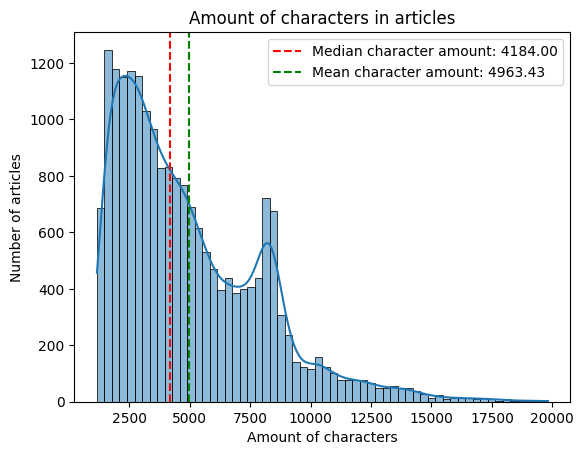

In [73]:
sns.histplot(articles_df["article"].map(len), kde=True)

plt.title("Amount of characters in articles")
plt.xlabel("Amount of characters")
plt.ylabel("Number of articles")
median_char_len = articles_df["article"].map(len).median()
mean_char_len = articles_df["article"].map(len).mean()
plt.axvline(median_char_len, color='r', linestyle='--', label=f"Median character amount: {median_char_len:.2f}")
plt.axvline(mean_char_len, color='g', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

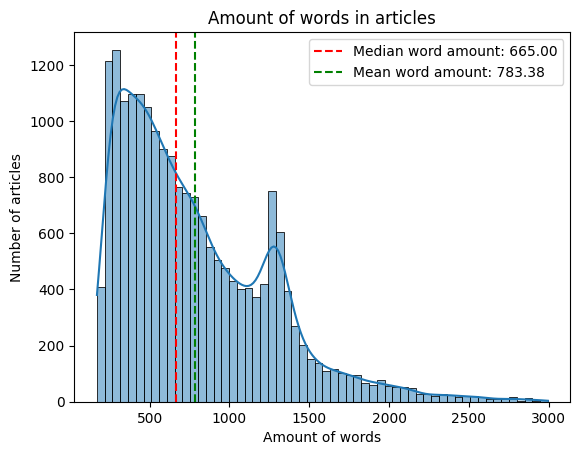

In [74]:
sns.histplot(articles_df["article"].map(lambda x: len(x.split())), kde=True)

plt.title("Amount of words in articles")
plt.xlabel("Amount of words")
plt.ylabel("Number of articles")
median_word_len = articles_df["article"].map(lambda x: len(x.split())).median()
mean_word_len = articles_df["article"].map(lambda x: len(x.split())).mean()
plt.axvline(median_word_len, color='r', linestyle='--', label=f"Median word amount: {median_word_len:.2f}")
plt.axvline(mean_word_len, color='g', linestyle='--', label=f"Mean word amount: {mean_word_len:.2f}")
plt.legend()
plt.show()

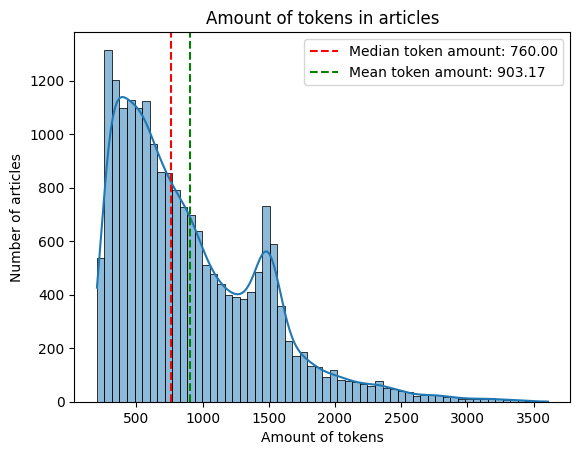

In [75]:
nlp = English()
tokenizer = nlp.tokenizer

sns.histplot(articles_df["article"].map(lambda x: len(tokenizer(x))), kde=True)

plt.title("Amount of tokens in articles")
plt.xlabel("Amount of tokens")
plt.ylabel("Number of articles")
median_token_len = articles_df["article"].map(lambda x: len(tokenizer(x))).median()
mean_token_len = articles_df["article"].map(lambda x: len(tokenizer(x))).mean()
plt.axvline(median_token_len, color='r', linestyle='--', label=f"Median token amount: {median_token_len:.2f}")
plt.axvline(mean_token_len, color='g', linestyle='--', label=f"Mean token amount: {mean_token_len:.2f}")
plt.legend()
plt.show()

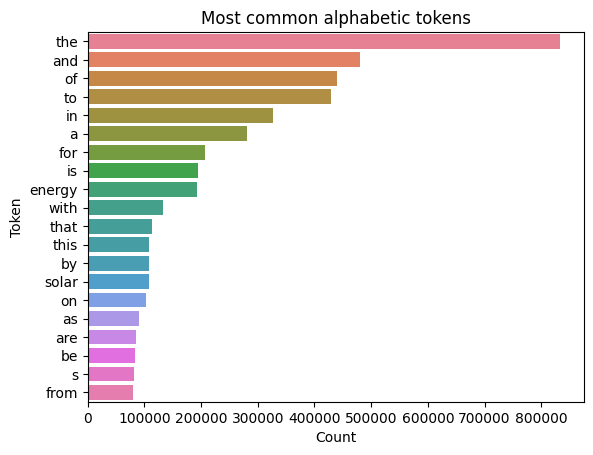

In [76]:
all_tokens = [token.text for article in articles_df["article"] for token in tokenizer(article)]
# remove non-alphabetic tokens such as punctuation
alpha_tokens = [token for token in all_tokens if token.isalpha()]
alpha_tokens = [token.lower() for token in alpha_tokens]
alpha_token_counts = Counter(alpha_tokens)

sns.barplot(
    x=[count for token, count in alpha_token_counts.most_common(20)],
    y=[token for token, count in alpha_token_counts.most_common(20)],
    hue=[token for token, count in alpha_token_counts.most_common(20)]
)

plt.title("Most common alphabetic tokens")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

The initial approach returns common words which do not reflect the subject-specific nature of our document collection. We will remove them to understand the content of the texts better.

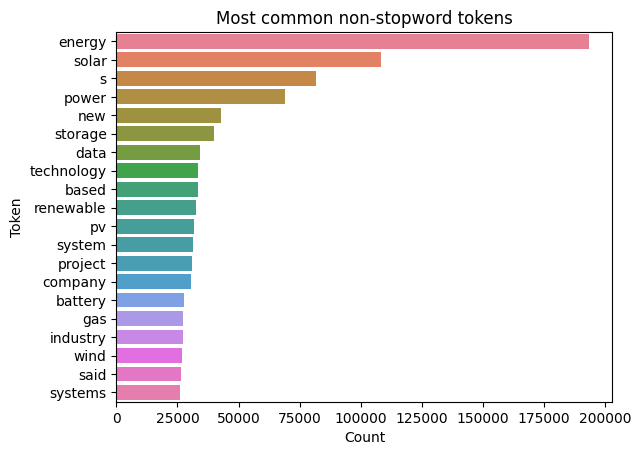

In [77]:
# remove stopwords such as 'the', 'a', 'and'
non_stop_tokens = [token for token in alpha_tokens if not nlp.vocab[token].is_stop]
non_stop_token_counts = Counter(non_stop_tokens)

sns.barplot(
    x=[count for token, count in non_stop_token_counts.most_common(20)],
    y=[token for token, count in non_stop_token_counts.most_common(20)],
    hue=[token for token, count in non_stop_token_counts.most_common(20)]
)

plt.title("Most common non-stopword tokens")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

As one would expect in a dataset of cleantech news articles most of the tokens that are not punctation or stopwords revolve around the subjects of energy, climate, and technology. This is a good sign that the dataset is relevant to the topic at hand. The "s" token comes up frequently, which is likely due to the possessive form of words. With an average of around 700 words per article, we can expect a good amount of information to be present in each article and an average reading time of around 3-4 minutes.

#### Flesch Reading Ease Score

The Flesch Reading Ease Score (FRES, a.k.a Flesch-Kincaid Reading Ease Score) is a heuristic used to evaluate how easy it is to understand a text based on the length of sentences and the number of syllables per word. Scores can range from -100 (very difficult to read) to 100 (very easy to read). Scores below 50 are indicative of difficult texts for College level. This metric can be useful for assessing the readability of our articles and ensuring they are accessible to a broad audience.

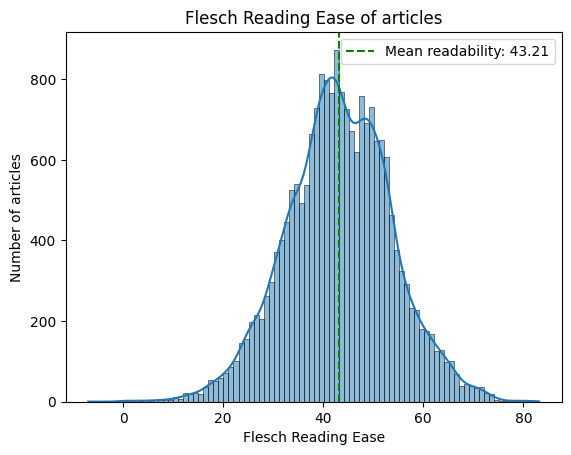

In [78]:
articles_df["readability"] = articles_df["article"].apply(flesch_reading_ease)

sns.histplot(articles_df["readability"], kde=True)

plt.title("Flesch Reading Ease of articles")
plt.xlabel("Flesch Reading Ease")
plt.ylabel("Number of articles")
mean_readability = articles_df["readability"].mean()
plt.axvline(mean_readability, color='g', linestyle='--', label=f"Mean readability: {mean_readability:.2f}")
plt.legend()
plt.show()

We analyze now the diversity of language complexity used by different publishing domains.

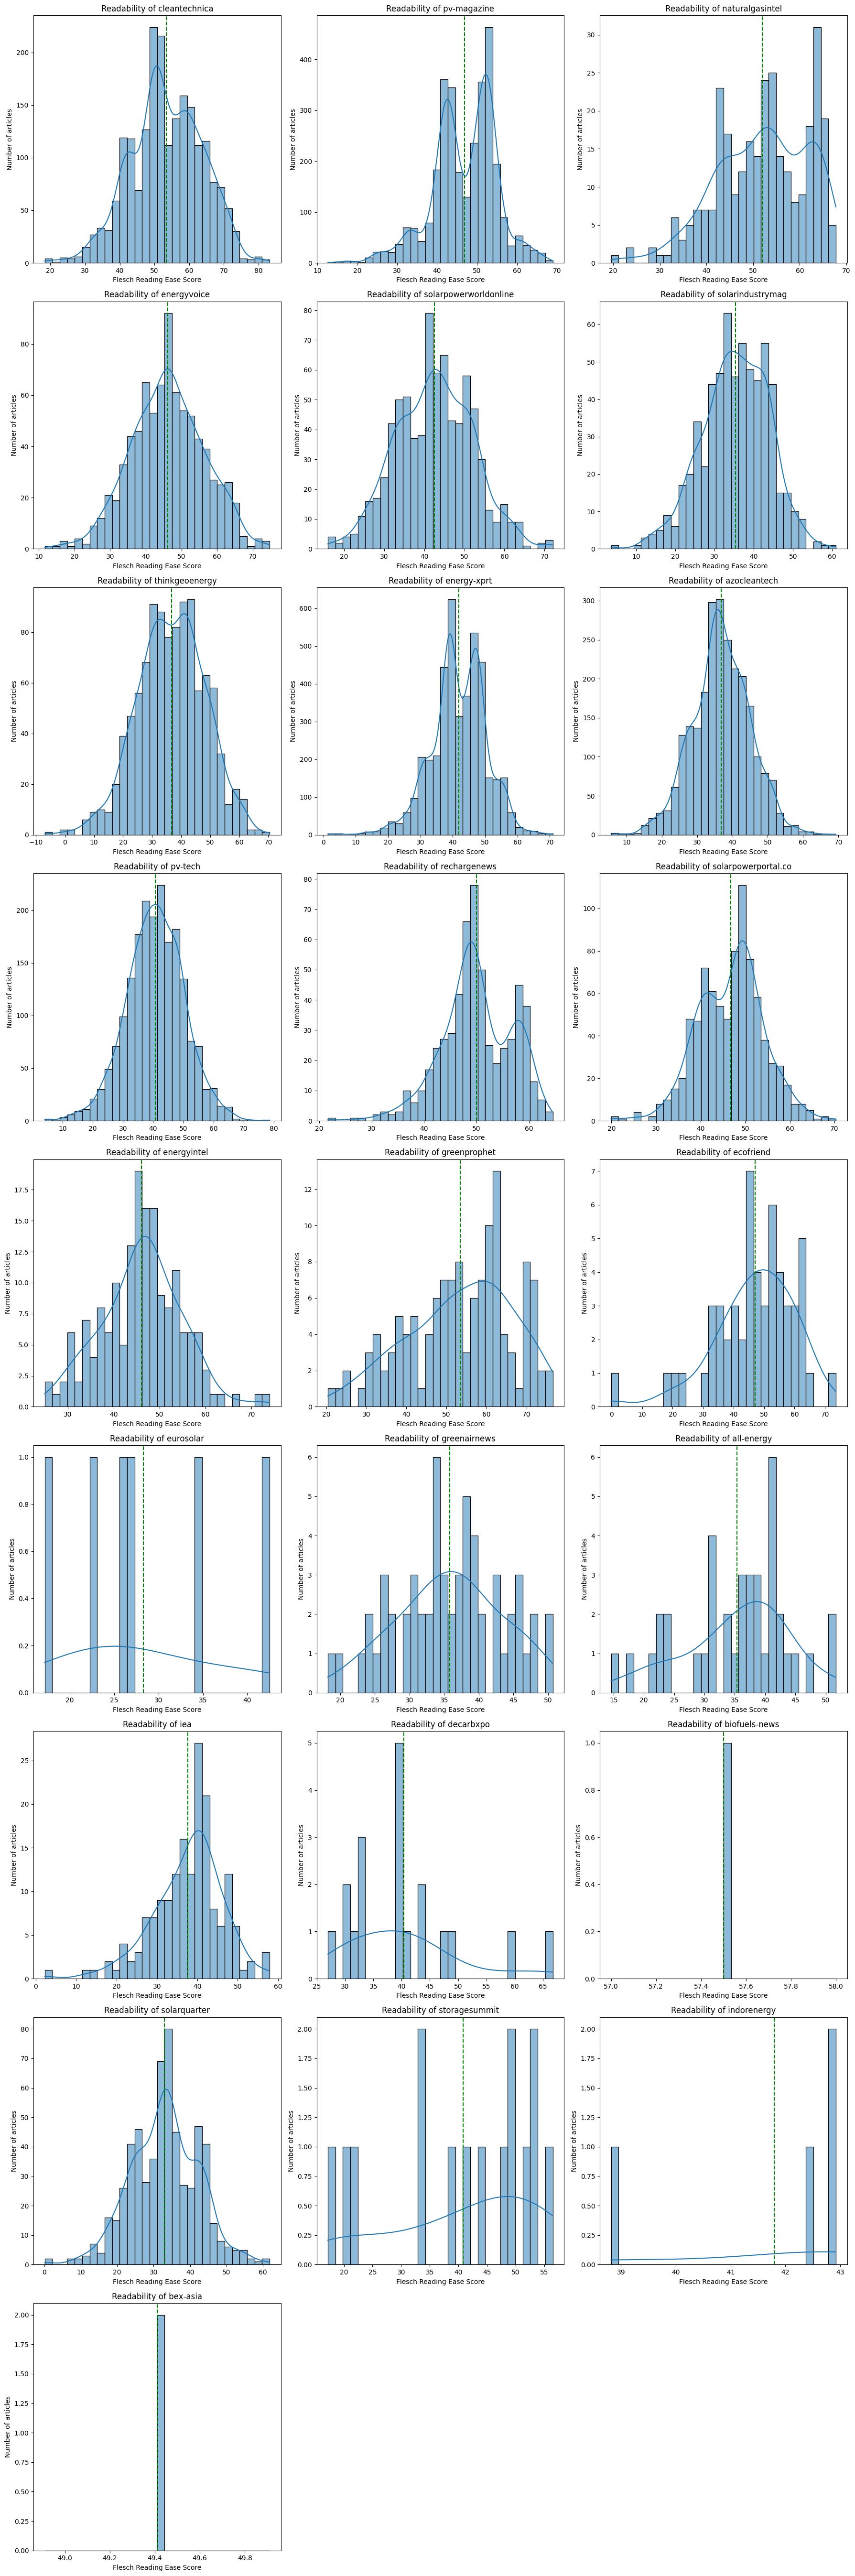

In [79]:
domains = articles_df["domain"].unique()

# Setup the subplots based on the number of domains
plots_per_row = 3
num_rows = (len(domains) + 2) // plots_per_row
plot_height = 6
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plot_height * plots_per_row, plot_height * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot for each domain
for i, domain in enumerate(domains):
    domain_articles = articles_df[articles_df["domain"] == domain]
    sns.histplot(domain_articles["readability"], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Readability of {domain}')
    axes[i].set_xlabel('Flesch Reading Ease Score')
    axes[i].set_ylabel("Number of articles")
    mean_readability = domain_articles["readability"].mean()
    axes[i].axvline(mean_readability, color='g', linestyle='--', label=f"Mean readability: {mean_readability:.2f}")

# remove the empty plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

To gauge the readability of our articles, we calculated the Flesch Reading Ease Score. The average score of around 45 indicates a "fairly easy" reading level, which is positive news. This suggests the content is likely accessible to a broad audience and, consequently, understandable by our RAG pipeline as well.

Our analysis revealed a consistent average Flesch Reading Ease Score across most of the identified domains, with minor variations. This indicates a relatively consistent level of readability across different publishers within the dataset.

Finally we will save the cleaned dataset to a new file in the `data/silver` folder.

In [80]:
silver_folder = data_folder / "silver"
if not silver_folder.exists():
    silver_folder.mkdir()

articles_df.to_csv(silver_folder / "articles.csv", index=False)

### Patent Dataset

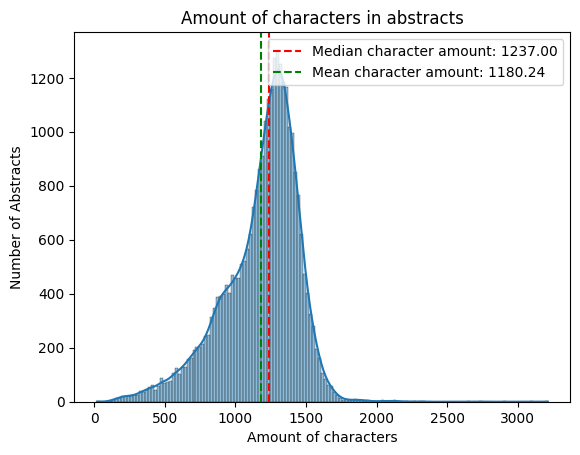

In [81]:
sns.histplot(patents_df["abstract"].map(len), kde=True)

plt.title("Amount of characters in abstracts")
plt.xlabel("Amount of characters")
plt.ylabel("Number of Abstracts")
median_char_len = patents_df["abstract"].map(len).median()
mean_char_len = patents_df["abstract"].map(len).mean()
plt.axvline(median_char_len, color='r', linestyle='--', label=f"Median character amount: {median_char_len:.2f}")
plt.axvline(mean_char_len, color='g', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

In [82]:
patents_df[patents_df["abstract"].map(len) <50]

publication_number application_number country_code  \
37368     US-11326019-B1  US-202117531006-A           US   
54119   WO-2023091151-A1    US-2021060331-W           WO   

                                                                    title  \
37368  Fused dithieno benzothiadiazole polymers for organic photovoltaics   
54119  Fused dithieno benzothiadiazole polymers for organic photovoltaics   

                               abstract title_lang abstract_lang  \
37368               A method to produce         en            en   
54119  A method to produce Formula (I).         en            en   

                                                                                                      text  \
37368              Fused dithieno benzothiadiazole polymers for organic photovoltaics. A method to produce   
54119  Fused dithieno benzothiadiazole polymers for organic photovoltaics. A method to produce Formula ...   

                                                                               cleaned_text  \
37368          fused dithieno benzothiadiazole polymer organic photovoltaics method produce   
54119  fused dithieno benzothiadiazole polymer organic photovoltaics method produce formula   

       topic  
37368      6  
54119      6

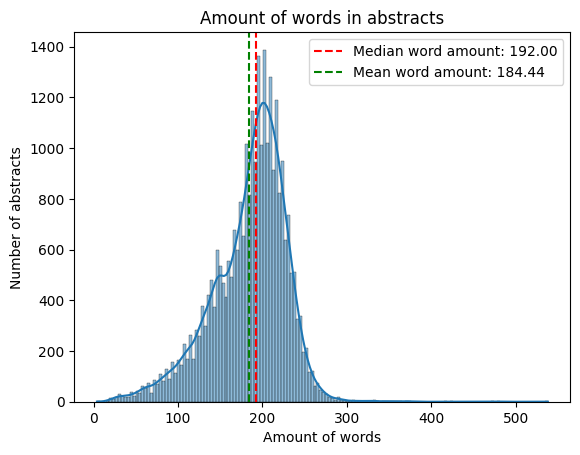

In [83]:
sns.histplot(patents_df["abstract"].map(lambda x: len(x.split())), kde=True)

plt.title("Amount of words in abstracts")
plt.xlabel("Amount of words")
plt.ylabel("Number of abstracts")
median_word_len = patents_df["abstract"].map(lambda x: len(x.split())).median()
mean_word_len = patents_df["abstract"].map(lambda x: len(x.split())).mean()
plt.axvline(median_word_len, color='r', linestyle='--', label=f"Median word amount: {median_word_len:.2f}")
plt.axvline(mean_word_len, color='g', linestyle='--', label=f"Mean word amount: {mean_word_len:.2f}")
plt.legend()
plt.show()

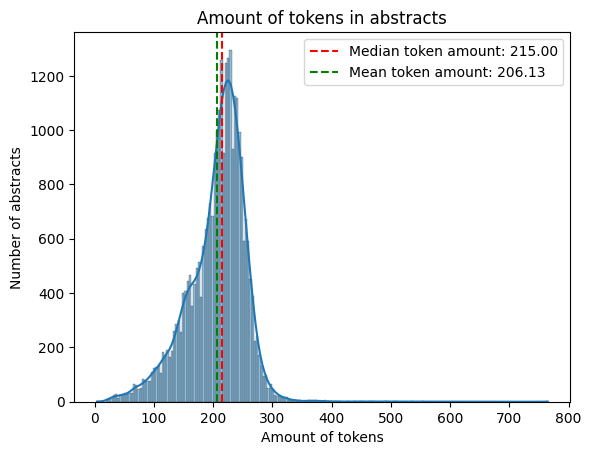

In [84]:
nlp = English()
tokenizer = nlp.tokenizer

sns.histplot(patents_df["abstract"].map(lambda x: len(tokenizer(x))), kde=True)

plt.title("Amount of tokens in abstracts")
plt.xlabel("Amount of tokens")
plt.ylabel("Number of abstracts")
median_token_len = patents_df["abstract"].map(lambda x: len(tokenizer(x))).median()
mean_token_len = patents_df["abstract"].map(lambda x: len(tokenizer(x))).mean()
plt.axvline(median_token_len, color='r', linestyle='--', label=f"Median token amount: {median_token_len:.2f}")
plt.axvline(mean_token_len, color='g', linestyle='--', label=f"Mean token amount: {mean_token_len:.2f}")
plt.legend()
plt.show()

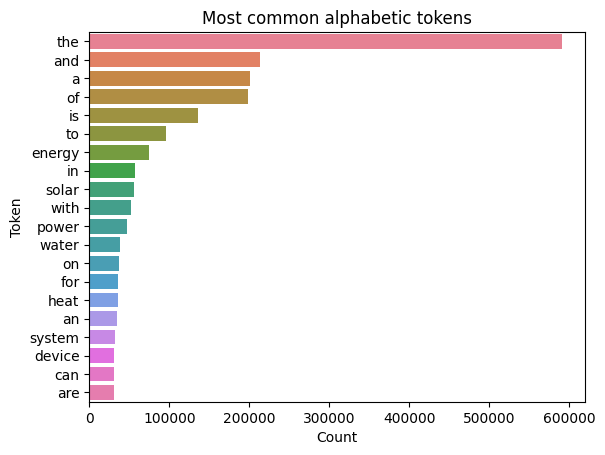

In [85]:
all_tokens = [token.text for article in patents_df["abstract"] for token in tokenizer(article)]
# remove non-alphabetic tokens such as punctuation
alpha_tokens = [token for token in all_tokens if token.isalpha()]
alpha_tokens = [token.lower() for token in alpha_tokens]
alpha_token_counts = Counter(alpha_tokens)

sns.barplot(
    x=[count for token, count in alpha_token_counts.most_common(20)],
    y=[token for token, count in alpha_token_counts.most_common(20)],
    hue=[token for token, count in alpha_token_counts.most_common(20)]
)

plt.title("Most common alphabetic tokens")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

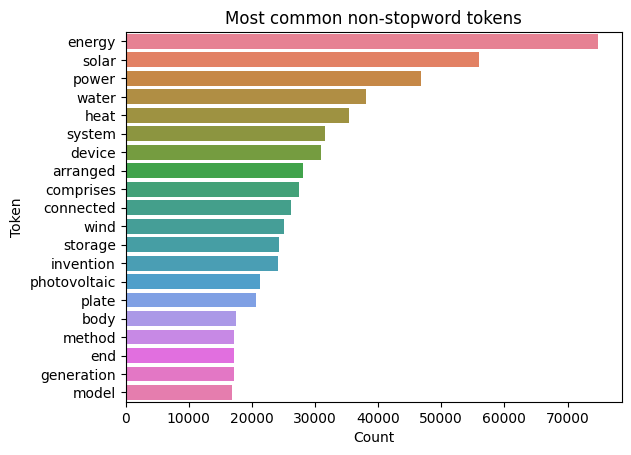

In [86]:
# remove stopwords such as 'the', 'a', 'and'
non_stop_tokens = [token for token in alpha_tokens if not nlp.vocab[token].is_stop]
non_stop_token_counts = Counter(non_stop_tokens)

sns.barplot(
    x=[count for token, count in non_stop_token_counts.most_common(20)],
    y=[token for token, count in non_stop_token_counts.most_common(20)],
    hue=[token for token, count in non_stop_token_counts.most_common(20)]
)

plt.title("Most common non-stopword tokens")
plt.xlabel("Count")
plt.ylabel("Token")
plt.show()

In patent articles/abstractsthe plot shows , it has lot of stopwords and less technical word Frequency. Although  most common words in patent datset are same as media dataset.

#### Flesch Reading Ease Score
The plot down does not show good results. Flesch readability should be between 0 and 100, and the more is better. But here we can see the some paragraphs in patent has readability below 0 and ranges from -200 to -100. Media datset is definitely better has better readability.


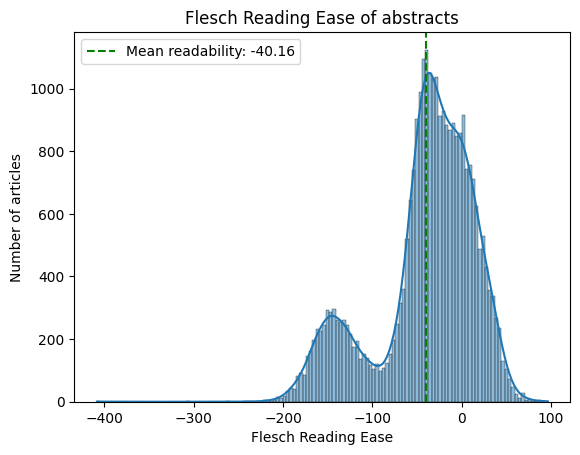

In [87]:
patents_df["readability"] = patents_df["abstract"].apply(flesch_reading_ease)

sns.histplot(patents_df["readability"], kde=True)

plt.title("Flesch Reading Ease of abstracts")
plt.xlabel("Flesch Reading Ease")
plt.ylabel("Number of articles")
mean_readability = patents_df["readability"].mean()
plt.axvline(mean_readability, color='g', linestyle='--', label=f"Mean readability: {mean_readability:.2f}")
plt.legend()
plt.show()

# Flesch Redability distribution per Topic
The plot shows its not good for any of the topics. Not comparable to the media dataset at all.

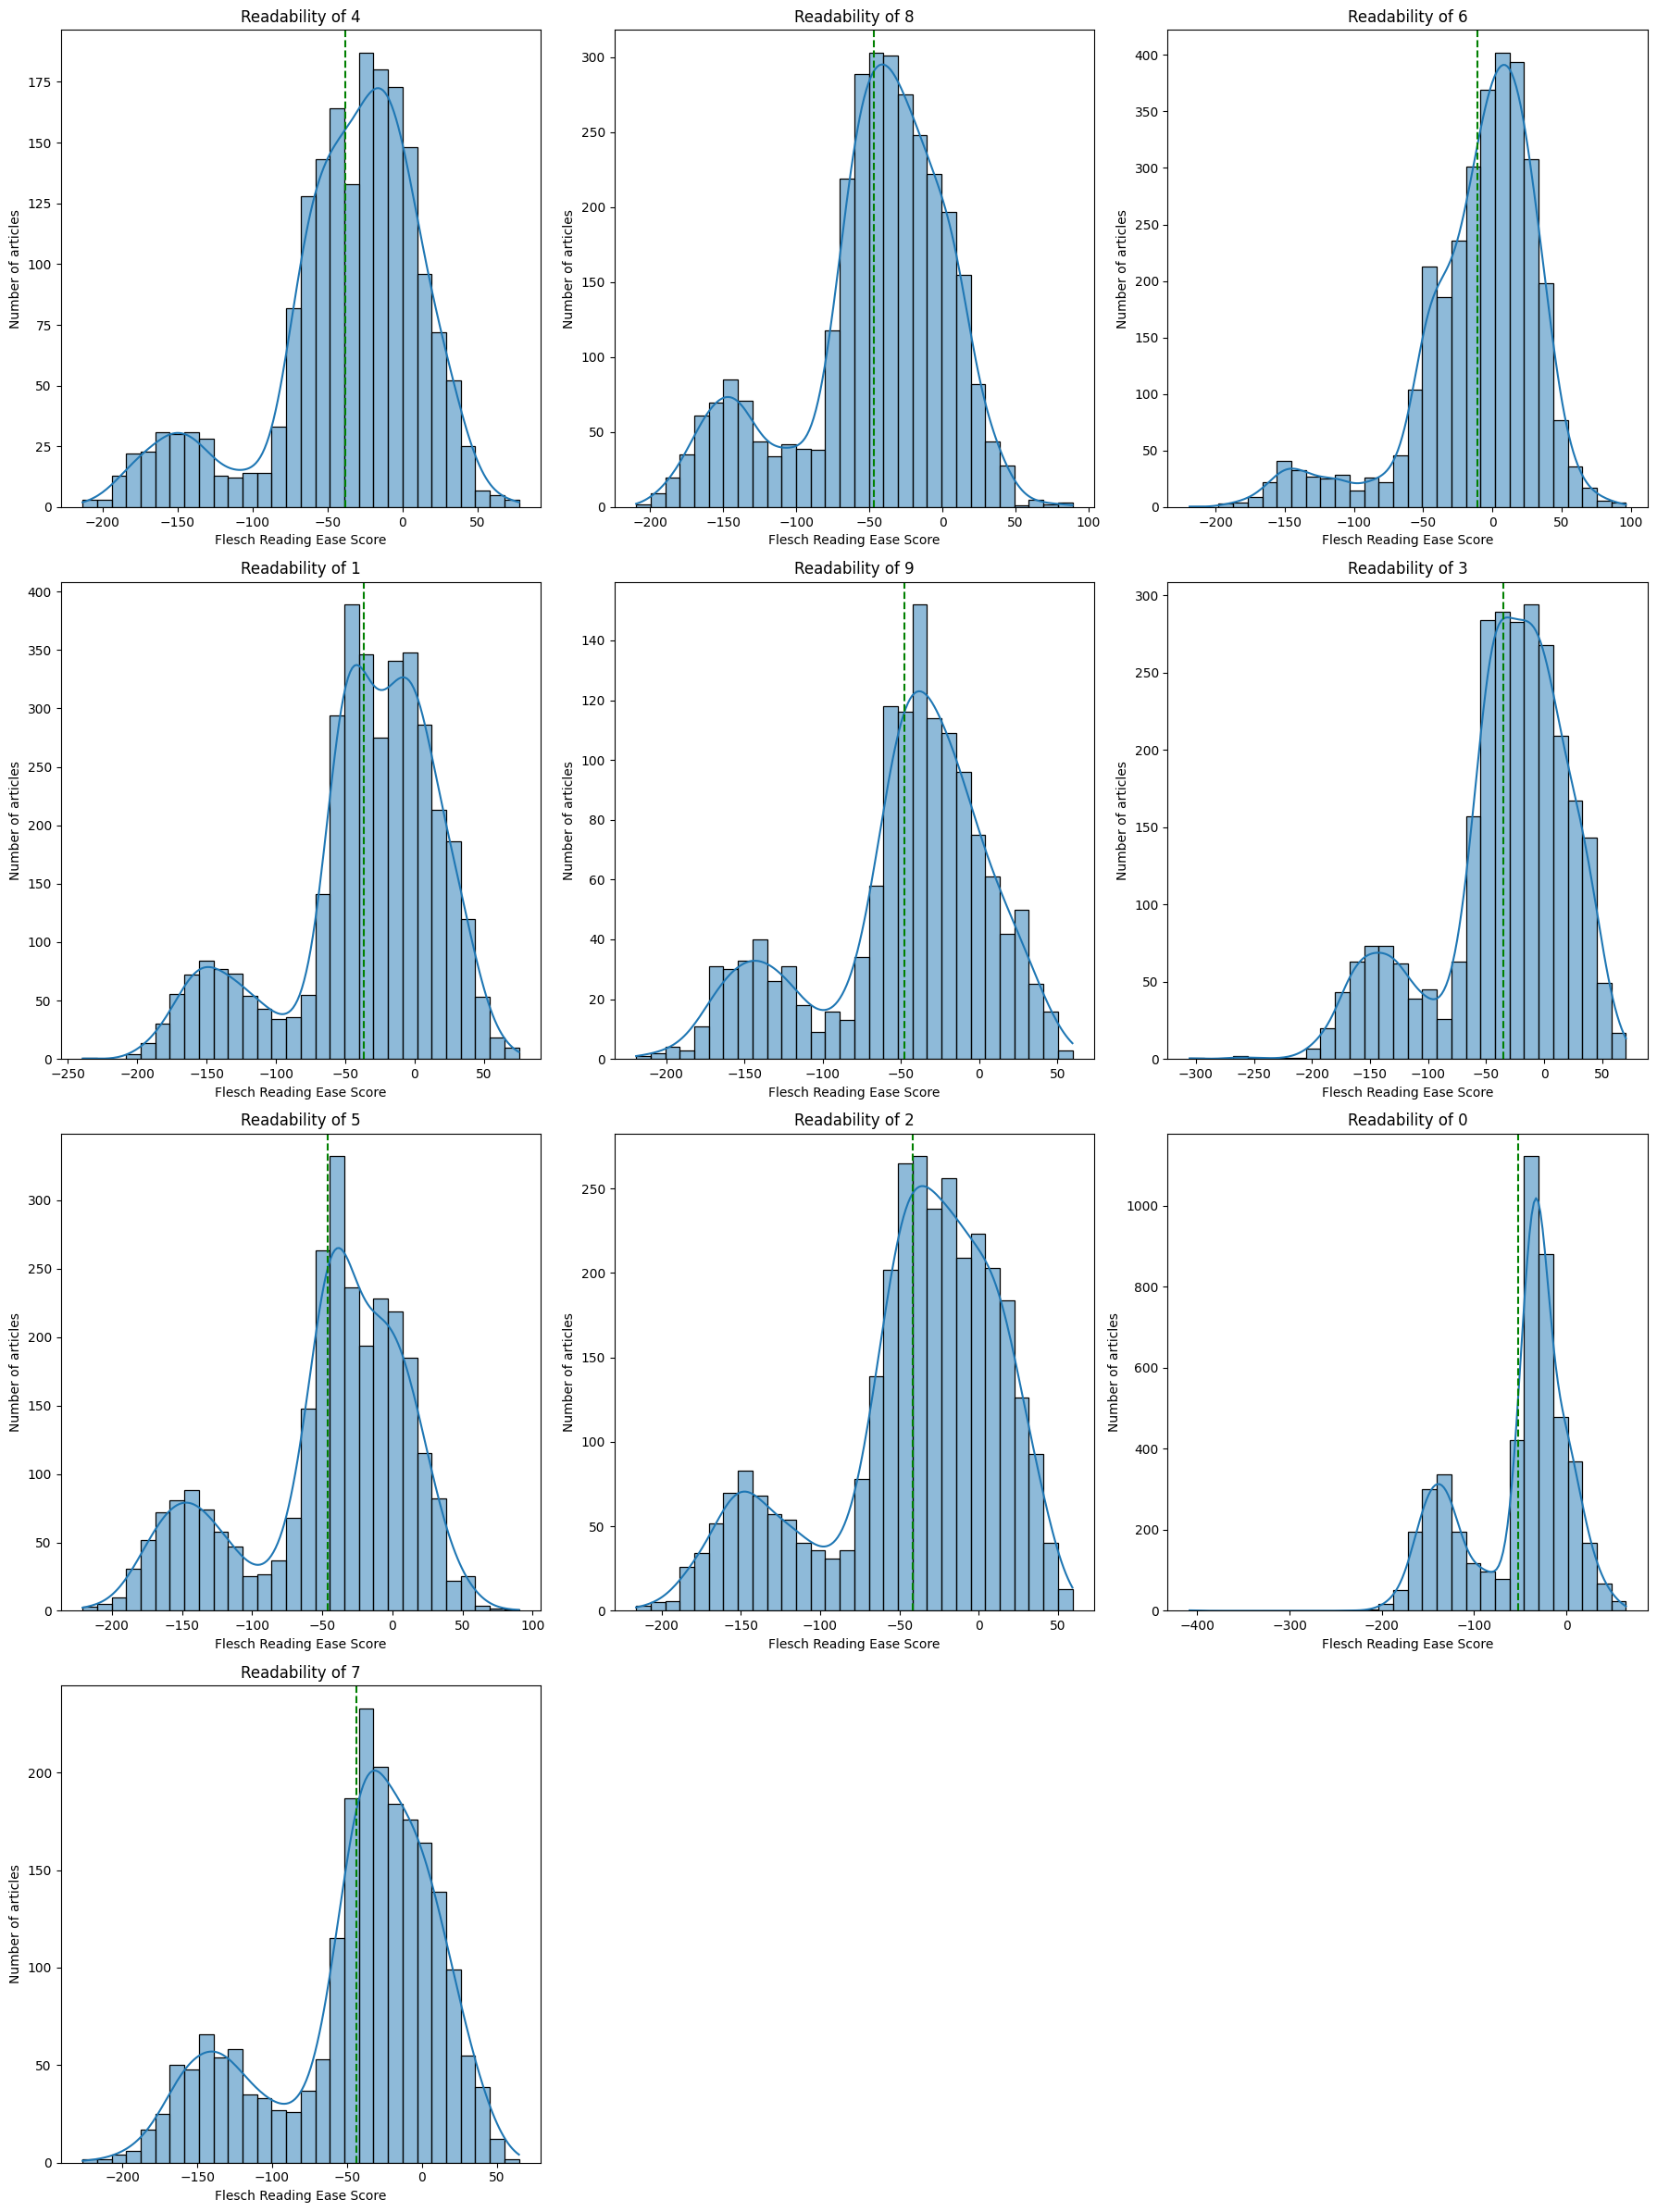

In [88]:
domains = patents_df["topic"].unique()

# Setup the subplots based on the number of domains
plots_per_row = 3
num_rows = (len(domains) + 2) // plots_per_row
plot_height = 6
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plot_height * plots_per_row, plot_height * num_rows))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Plot for each domain
for i, domain in enumerate(domains):
    domain_articles = patents_df[patents_df["topic"] == domain]
    sns.histplot(domain_articles["readability"], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Readability of {domain}')
    axes[i].set_xlabel('Flesch Reading Ease Score')
    axes[i].set_ylabel("Number of articles")
    mean_readability = domain_articles["readability"].mean()
    axes[i].axvline(mean_readability, color='g', linestyle='--', label=f"Mean readability: {mean_readability:.2f}")

# remove the empty plots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [89]:
silver_folder = data_folder / "silver"
if not silver_folder.exists():
    silver_folder.mkdir()

patents_df.to_csv(silver_folder / "abstracts.csv", index=False)

### Evaluation Data

Next we will analyze the provided evaluation data and ensure that they match the content of the articles.

In [90]:
human_eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   example_id     23 non-null     int64 
 1   question_id    23 non-null     int64 
 2   question       23 non-null     object
 3   relevant_text  23 non-null     object
 4   answer         23 non-null     object
 5   article_url    23 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.2+ KB


In [91]:
human_eval_df.rename(columns={"relevant_text":"relevant_section","article_url": "url"}, inplace=True)
human_eval_df.drop(columns=["question_id"], inplace=True)
human_eval_df.head()

example_id  \
0           1   
1           2   
2           3   
3           4   
4           5   

                                                                                 question  \
0  What is the innovation behind Leclanché's new method to produce lithium-ion batteries?   
1                                            What is the EU’s Green Deal Industrial Plan?   
2                                            What is the EU’s Green Deal Industrial Plan?   
3                   What are the four focus areas of the EU's Green Deal Industrial Plan?   
4              When did the cooperation between GM and Honda on fuel cell vehicles start?   

                                                                                      relevant_section  \
0  Leclanché said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) ...   
1  The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive...   
2  The European counterpart to the US Inflation Reduction Act (IRA) aims to create an environment t...   
3  The new plan is fundamentally focused on four areas, or pillars: the regulatory environment, acc...   
4  What caught our eye was a new hookup between GM and Honda. Honda was also hammering away at the ...   

                                                                                                answer  \
0  Leclanché's innovation is using a water-based process instead of highly toxic organic solvents t...   
1  The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry...   
2  The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry...   
3  The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, acce...   
4                                                                                            July 2013   

                                                                                                   url  
0  https://www.sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energ...  
1     https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/  
2    https://www.pv-magazine.com/2023/02/02/european-commission-introduces-green-deal-industrial-plan/  
3     https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/  
4  https://cleantechnica.com/2023/05/08/general-motors-seizes-the-fuel-cell-moment-with-green-hydro...

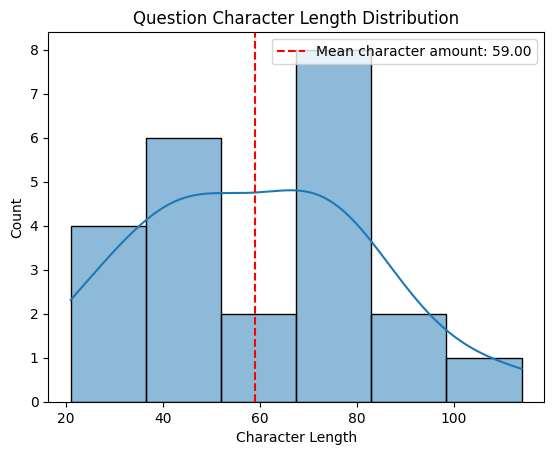

In [92]:
sns.histplot(human_eval_df["question"].map(len), kde=True)
plt.title("Question Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Count")
mean_char_len = human_eval_df["question"].map(len).mean()
plt.axvline(mean_char_len, color='r', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

In [93]:
missing_articles = human_eval_df.copy()
missing_articles = missing_articles[~human_eval_df["url"].isin(articles_df["url"])]
missing_articles

example_id  \
0            1   
1            2   
3            4   
22          23   

                                                                                               question  \
0                What is the innovation behind Leclanché's new method to produce lithium-ion batteries?   
1                                                          What is the EU’s Green Deal Industrial Plan?   
3                                 What are the four focus areas of the EU's Green Deal Industrial Plan?   
22  Which has the higher absorption coefficient for wavelengths above 500m - amorphous germanium or ...   

                                                                                       relevant_section  \
0   Leclanché said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) ...   
1   The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive...   
3   The new plan is fundamentally focused on four areas, or pillars: the regulatory environment, acc...   
22  We chose amorphous germanium instead of amorphous silicon as absorber material because of its hi...   

                                                                                                 answer  \
0   Leclanché's innovation is using a water-based process instead of highly toxic organic solvents t...   
1   The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry...   
3   The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, acce...   
22                                                                                  amorphous germanium   

                                                                                                    url  
0   https://www.sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energ...  
1      https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/  
3      https://www.sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan/  
22     https://www.pv-magazine.com/2021/01/15/germanium-based-solar-cell-tech-for-agrivoltaics/#respond

Our exploration has identified instances where articles linked to specific questions appear to be missing from the dataset.  To determine the root cause, let's investigate whether these articles are genuinely absent or if inconsistencies in URL formatting are creating the illusion of missing data.  Normalizing the URLs across the dataset will help us differentiate between these two scenarios.

In [94]:
def normalize_url(url: str) -> str:
    url = url.replace("https://", "")
    url = url.replace("http://", "")
    url = url.replace("www.", "")
    url = url.rstrip("/")
    return url

articles_df["url"] = articles_df["url"].map(normalize_url)
human_eval_df["url"] = human_eval_df["url"].map(normalize_url)

missing_articles = human_eval_df.copy()
missing_articles = missing_articles[~human_eval_df["url"].isin(articles_df["url"])]
missing_articles

example_id  \
0            1   
1            2   
3            4   
22          23   

                                                                                               question  \
0                What is the innovation behind Leclanché's new method to produce lithium-ion batteries?   
1                                                          What is the EU’s Green Deal Industrial Plan?   
3                                 What are the four focus areas of the EU's Green Deal Industrial Plan?   
22  Which has the higher absorption coefficient for wavelengths above 500m - amorphous germanium or ...   

                                                                                       relevant_section  \
0   Leclanché said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) ...   
1   The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive...   
3   The new plan is fundamentally focused on four areas, or pillars: the regulatory environment, acc...   
22  We chose amorphous germanium instead of amorphous silicon as absorber material because of its hi...   

                                                                                                 answer  \
0   Leclanché's innovation is using a water-based process instead of highly toxic organic solvents t...   
1   The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry...   
3   The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, acce...   
22                                                                                  amorphous germanium   

                                                                                              url  
0   sgvoice.net/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energy-density  
1             sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan  
3             sgvoice.net/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan  
22           pv-magazine.com/2021/01/15/germanium-based-solar-cell-tech-for-agrivoltaics/#respond

We also know from previous analysis that some duplicate articles from the "energyvoice" domain so we will also normalize these URLs.

In [95]:
missing_articles["url"] = missing_articles["url"].map(lambda x: x.replace("sgvoice.net", "sgvoice.energyvoice.com"))

In [96]:
missing_articles[~missing_articles["url"].isin(articles_df["url"])]

example_id  \
22          23   

                                                                                               question  \
22  Which has the higher absorption coefficient for wavelengths above 500m - amorphous germanium or ...   

                                                                                       relevant_section  \
22  We chose amorphous germanium instead of amorphous silicon as absorber material because of its hi...   

                 answer  \
22  amorphous germanium   

                                                                                     url  
22  pv-magazine.com/2021/01/15/germanium-based-solar-cell-tech-for-agrivoltaics/#respond

In [97]:
human_eval_df.loc[missing_articles.index, "url"] = missing_articles["url"]
human_eval_df[human_eval_df["url"].isin(articles_df["url"])]

example_id  \
0            1   
1            2   
2            3   
3            4   
4            5   
5            6   
6            7   
7            8   
8            9   
9           10   
10          11   
11          12   
12          13   
13          14   
14          15   
15          16   
16          17   
17          18   
18          19   
19          20   
20          21   
21          22   

                                                                                            question  \
0             What is the innovation behind Leclanché's new method to produce lithium-ion batteries?   
1                                                       What is the EU’s Green Deal Industrial Plan?   
2                                                       What is the EU’s Green Deal Industrial Plan?   
3                              What are the four focus areas of the EU's Green Deal Industrial Plan?   
4                         When did the cooperation between GM and Honda on fuel cell vehicles start?   
5                             Did Colgate-Palmolive enter into PPA agreements with solar developers?   
6                             What is the status of ZeroAvia's hydrogen fuel cell electric aircraft?   
7                                                                       What is the "Danger Season"?   
8                                                                   Is Mississipi an anti-ESG state?   
9                                                        Can you hang solar panels on garden fences?   
10                      Who develops quality control systems for ocean temperature in-situ profiles?   
11                                         Why are milder winters detrimental for grapes and apples?   
12                                              What are the basic recycling steps for solar panels?   
13                                                Why does melting ice contribute to global warming?   
14                              Does the Swedish government plan bans on new petrol and diesel cars?   
15                        Where do the turbines used in Icelandic geothermal power plants come from?   
16                                                       Who is the target user for Leapfrog Energy?   
17                                                                             What is Agrivoltaics?   
18                                                                             What is Agrivoltaics?   
19                                                       Why is cannabis cultivation moving indoors?   
20                What are the obstacles for cannabis producers when it comes to using solar energy?   
21  In 2021, what were the top 3 states in the US in terms of total solar power generating capacity?   

                                                                                       relevant_section  \
0   Leclanché said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) ...   
1   The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive...   
2   The European counterpart to the US Inflation Reduction Act (IRA) aims to create an environment t...   
3   The new plan is fundamentally focused on four areas, or pillars: the regulatory environment, acc...   
4   What caught our eye was a new hookup between GM and Honda. Honda was also hammering away at the ...   
5   Scout Clean Energy, a Colorado-based renewable energy developer, owner and operator, has signed ...   
6   In December, the US startup ZeroAvia announced that its retrofitted 19-seat Dornier 228 hydrogen...   
7   As spring turns to summer and the days warm up, the Northern Hemisphere enters the period known ...   
8   Mississippi is among two dozen or so states in which Republican governors, legislators, treasure...   
9   Scaling down from the farm to the garden level, another company is now offering plug & play sola...   
10  Scientists from

In the end we are able to find all the articles that are linked to the evaluation data and have therefore successfully completed our exploratory data analysis and preprocessing.

#### Our Generated Evaluation QA pairs

In [98]:
human_eval_df_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  200 non-null    int64  
 1   context             200 non-null    object 
 2   question            200 non-null    object 
 3   answer              200 non-null    object 
 4   source_doc          200 non-null    object 
 5   category            200 non-null    object 
 6   groundedness_score  97 non-null     float64
 7   groundedness_eval   97 non-null     object 
 8   relevance_score     97 non-null     float64
 9   relevance_eval      97 non-null     object 
 10  standalone_score    97 non-null     float64
 11  standalone_eval     97 non-null     object 
dtypes: float64(3), int64(1), object(8)
memory usage: 18.9+ KB


In [99]:
human_eval_df_patent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  200 non-null    int64  
 1   context             200 non-null    object 
 2   question            200 non-null    object 
 3   answer              200 non-null    object 
 4   category            200 non-null    object 
 5   groundedness_score  33 non-null     float64
 6   groundedness_eval   33 non-null     object 
 7   relevance_score     33 non-null     float64
 8   relevance_eval      33 non-null     object 
 9   standalone_score    33 non-null     float64
 10  standalone_eval     33 non-null     object 
 11  title               200 non-null    object 
dtypes: float64(3), int64(1), object(8)
memory usage: 18.9+ KB


#### Curated media QA Pairs preprocessing
performing the same preprocessing steps as for the seed QA dataset

In [100]:
human_eval_df_media.rename(columns={"context":"relevant_section","source_doc": "url","Unnamed: 0": "id"}, inplace=True)
human_eval_df_media.head()

id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                      relevant_section  \
0  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
1  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
2  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
3  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
4  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   

                                                                                              question  \
0                                                      What is green hydrogen, and how is it produced?   
1  What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hy...   
2  What is the significance of the Energy Transitions Commission's report on making clean electrifi...   
3          How does green hydrogen compare to direct use of electricity in terms of energy efficiency?   
4  What are some of the examples of pilot projects testing the viability of green hydrogen in vario...   

                                                                                                answer  \
0  Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...   
1  The Neom project, a partnership between ACWA Power, Air Products, and NEOM, harnesses solar and ...   
2  The report highlights the need for a 30-year transition to electrify the global economy, providi...   
3  Green hydrogen production through electrolysis is less energy-efficient than direct use of elect...   
4  Various pilot projects are testing green hydrogen's viability in energy systems, demonstrating i...   

                                                        url  \
0  https://www.azocleantech.com/article.aspx?ArticleID=1823   
1  https://www.azocleantech.com/article.aspx?ArticleID=1823   
2  https://www.azocleantech.com/article.aspx?ArticleID=1823   
3  https://www.azocleantech.com/article.aspx?ArticleID=1823   
4  https://www.azocleantech.com/article.aspx?ArticleID=1823   

                                              category  groundedness_score  \
0  Sustainability & Technological Innovation Questions                 5.0   
1  Sustainability & Technological Innovation Questions                 5.0   
2  Sustainability & Technological Innovation Questions                 5.0   
3  Sustainability & Technological Innovation Questions                 4.0   
4  Sustainability & Technological Innovation Questions                 5.0   

                                                                                     groundedness_eval  \
0  The provided context clearly explains what green hydrogen is, how it is produced through water e...   
1  The context provides a comprehensive overview of the significance of green hydrogen and its inte...   
2  The question regarding the significance of the Energy Transitions Commission's report "Making Cl...   
3  The question requires an in-depth analysis of the context provided, specifically focusing on the...   
4  The question can be answered unambiguously based on the provided context, which describes variou...   

   relevance_score  \
0              3.0   
1              4.0   
2              3.0   
3              4.0   
4              3.0   

                                                                                        relevance_eval  \
0  The question is straightforward and clear, inquiring about a specific concept (green hydrogen) a...   
1  The Neom project is a key concept in the context of green hydrogen integration, and understandin...   
2  This question appears to be relevant to environmental sustainability and energy policy, which mi..

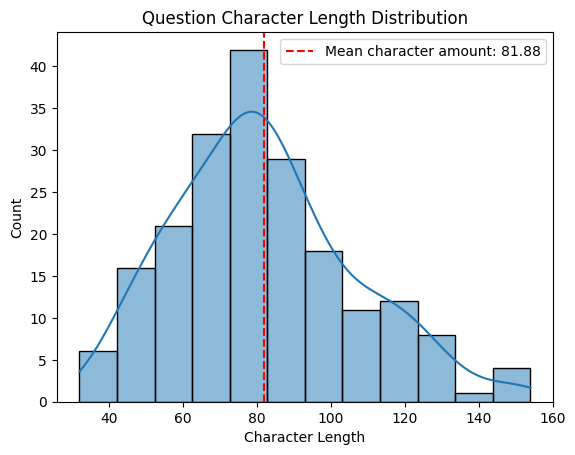

In [101]:
sns.histplot(human_eval_df_media["question"].map(len), kde=True)
plt.title("Question Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Count")
mean_char_len = human_eval_df_media["question"].map(len).mean()
plt.axvline(mean_char_len, color='r', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

In [102]:
missing_articles = human_eval_df_media.copy()
missing_articles = missing_articles[~human_eval_df_media["url"].isin(articles_df["url"])]
missing_articles

id  \
0      0   
1      1   
2      2   
3      3   
4      4   
..   ...   
195  195   
196  196   
197  197   
198  198   
199  199   

                                                                                        relevant_section  \
0    As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
1    As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
2    As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
3    As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
4    As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
..                                                                                                   ...   
195  India’ s installed battery storage capacity reached 219.1 MWh at the end of March 2024. A recent...   
196  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
197  Shortly after Tesla CEO Elon Musk met with India Prime Minister Narendra Modi, news is out that ...   
198  NV Energy, Nevada’ s largest public utility, has awarded Energy Vault Holdings Inc. with a proje...   
199  The Japanese technology company Asahi Kasei is further accelerating its hydrogen business activi...   

                                                                                                question  \
0                                                        What is green hydrogen, and how is it produced?   
1    What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hy...   
2    What is the significance of the Energy Transitions Commission's report on making clean electrifi...   
3            How does green hydrogen compare to direct use of electricity in terms of energy efficiency?   
4    What are some of the examples of pilot projects testing the viability of green hydrogen in vario...   
..                                                                                                   ...   
195                          Who is the author of the Mercom report on India's energy storage landscape?   
196        What are the main challenges associated with integrating green hydrogen into the energy grid?   
197                  How does the Indian government plan to achieve its electric vehicle adoption goals?   
198                             What is Energy Vault's goal for short-duration energy storage solutions?   
199                                          What is the name of the company discussed in the interview?   

                                                                                                  answer  \
0    Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...   
1    The Neom project, a partnership between ACWA Power, Air Products, and NEOM, harnesses solar and ...   
2    The report highlights the need for a 30-year transition to electrify the global economy, providi...   
3    Green hydrogen production through electrolysis is less energy-efficient than direct use of elect...   
4    Various pilot projects are testing green hydrogen's viability in energy systems, demonstrating i...   
..                                                                                                   ...   
195                                                                    The report is authored by Mercom.   
196  The main challenges include technical hurdles such as lower energy efficiency, safe storage and ...   
197  The Indian government aims to achieve its electric vehicle adoption goals through a combination ...   
198              To be the energy storage company of choice for utilities, IPPs, and large energy users.   
199  Various companies, including Cleantech for UK under Sarah Mackintosh's lea

In [103]:
articles_df["url"] = articles_df["url"].map(normalize_url)
human_eval_df_media["url"] = human_eval_df_media["url"].map(normalize_url)

missing_articles = human_eval_df_media.copy()
missing_articles = missing_articles[~human_eval_df_media["url"].isin(articles_df["url"])]
missing_articles

Empty DataFrame
Columns: [id, relevant_section, question, answer, url, category, groundedness_score, groundedness_eval, relevance_score, relevance_eval, standalone_score, standalone_eval]
Index: []

In [104]:
missing_articles["url"] = missing_articles["url"].map(lambda x: x.replace("sgvoice.net", "sgvoice.energyvoice.com"))

In [105]:
missing_articles[~missing_articles["url"].isin(articles_df["url"])]

Empty DataFrame
Columns: [id, relevant_section, question, answer, url, category, groundedness_score, groundedness_eval, relevance_score, relevance_eval, standalone_score, standalone_eval]
Index: []

After normalizing the URLs there are no missing articles . Now URLS match in media original Dataset and media QA dataset.

In [106]:
human_eval_df_media.loc[missing_articles.index, "url"] = missing_articles["url"]
human_eval_df_media[human_eval_df_media["url"].isin(articles_df["url"])]

id  \
0      0   
1      1   
2      2   
3      3   
4      4   
..   ...   
195  195   
196  196   
197  197   
198  198   
199  199   

                                                                                        relevant_section  \
0    As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
1    As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
2    As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
3    As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
4    As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
..                                                                                                   ...   
195  India’ s installed battery storage capacity reached 219.1 MWh at the end of March 2024. A recent...   
196  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
197  Shortly after Tesla CEO Elon Musk met with India Prime Minister Narendra Modi, news is out that ...   
198  NV Energy, Nevada’ s largest public utility, has awarded Energy Vault Holdings Inc. with a proje...   
199  The Japanese technology company Asahi Kasei is further accelerating its hydrogen business activi...   

                                                                                                question  \
0                                                        What is green hydrogen, and how is it produced?   
1    What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hy...   
2    What is the significance of the Energy Transitions Commission's report on making clean electrifi...   
3            How does green hydrogen compare to direct use of electricity in terms of energy efficiency?   
4    What are some of the examples of pilot projects testing the viability of green hydrogen in vario...   
..                                                                                                   ...   
195                          Who is the author of the Mercom report on India's energy storage landscape?   
196        What are the main challenges associated with integrating green hydrogen into the energy grid?   
197                  How does the Indian government plan to achieve its electric vehicle adoption goals?   
198                             What is Energy Vault's goal for short-duration energy storage solutions?   
199                                          What is the name of the company discussed in the interview?   

                                                                                                  answer  \
0    Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...   
1    The Neom project, a partnership between ACWA Power, Air Products, and NEOM, harnesses solar and ...   
2    The report highlights the need for a 30-year transition to electrify the global economy, providi...   
3    Green hydrogen production through electrolysis is less energy-efficient than direct use of elect...   
4    Various pilot projects are testing green hydrogen's viability in energy systems, demonstrating i...   
..                                                                                                   ...   
195                                                                    The report is authored by Mercom.   
196  The main challenges include technical hurdles such as lower energy efficiency, safe storage and ...   
197  The Indian government aims to achieve its electric vehicle adoption goals through a combination ...   
198              To be the energy storage company of choice for utilities, IPPs, and large energy users.   
199  Various companies, including Cleantech for UK under Sarah Mackintosh's lea

#### media QA Pairs

In [107]:
missing_articles["url"] = missing_articles["url"].map(lambda x: x.replace("sgvoice.net", "sgvoice.energyvoice.com"))

In [108]:
missing_articles[~missing_articles["url"].isin(articles_df["url"])]

Empty DataFrame
Columns: [id, relevant_section, question, answer, url, category, groundedness_score, groundedness_eval, relevance_score, relevance_eval, standalone_score, standalone_eval]
Index: []

In [109]:
human_eval_df_patent.rename(columns={"context":"relevant_section"}, inplace=True)
human_eval_df_patent.head()


id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                      relevant_section  \
0  Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...   
1  Water path manifold structure of hydrogen energy automobile electric pileThe utility model discl...   
2  Active power control method of water-fire-wind-solar energy storage multi-energy complementary i...   
3  Water conservancy and hydropower engineering construction tunnel internal flow guiding and drain...   
4  Medium-and-long-term electric power quantity balancing method for electric power system containi...   

                                                                                              question  \
0                                                 How does the system reduce the cost of cold storage?   
1                                                                What is good about the utility model?   
2  What is the purpose of using power supply with better regulation performance to compensate for p...   
3  What is the water conservancy and hydropower engineering construction hole inner diversion drain...   
4          What is the main consideration for the balancing method, in addition to safety and economy?   

                                                                                                answer  \
0  The system reduces the cost of cold storage by converting solar energy into electric energy, whi...   
1                   The utility model has a simple structure that is easy to assemble and disassemble.   
2  The power supply with better regulation performance is used to carry out compensation regulation...   
3  The utility model discloses a water conservancy and hydropower engineering construction hole inn...   
4  The seasonal characteristics of renewable energy sources in time and the coordination problem of...   

                                              category  groundedness_score  \
0  Sustainability & Technological Innovation Questions                 5.0   
1                   Analytical & Explanatory Questions                 5.0   
2                   Government & Corporate Initiatives                 5.0   
3  Sustainability & Technological Innovation Questions                 5.0   
4                   Analytical & Explanatory Questions                 4.0   

                                                                                     groundedness_eval  \
0    The question can be answered based on the given context, and the answer is clear and unambiguous.   
1  The question "What is good about the utility model?" is somewhat ambiguous without further clari...   
2  The question is clearly answerable by understanding the purpose of using power supply with bette...   
3  The question is clearly answerable with the given context, as it describes a specific inner dive...   
4  The context provides a detailed description of a method for balancing electric quantity in a pow...   

   relevance_score  \
0              4.0   
1              3.0   
2              3.0   
3              3.0   
4              4.0   

                                                                                        relevance_eval  \
0  The question is concise and to the point, directly asking about a specific aspect of how the Hug...   
1  The question is very short and to the point, but it lacks context and detail about the specific ...   
2  The question is directly related to power supply regulation and its impact on the performance of...   
3  The question seems to be about a specific technical term, which may be useful for machine learni...   
4  The question is asking about a specific aspect of the balancing method, which is a common techni...   

   standalone_score  \
0               5.0   
1               5.0   
2               5.0   
3               5.0   
4               5.0   

                      

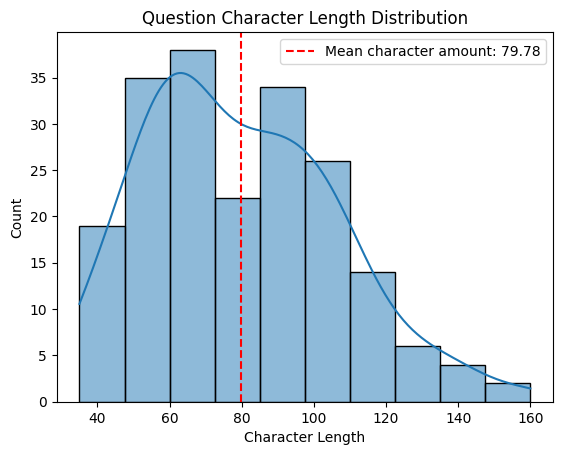

In [110]:
sns.histplot(human_eval_df_patent["question"].map(len), kde=True)
plt.title("Question Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Count")
mean_char_len = human_eval_df_patent["question"].map(len).mean()
plt.axvline(mean_char_len, color='r', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()

## Subsampling

For faster processing and to reduce the cost of running the notebook we will subsample the dataset to 1000 articles. This will allow us to run the notebook in a reasonable amount of time and still provide meaningful results. Because the distribution of articles across publishers is skewed we will use stratified sampling to ensure that we have a representative sample. We also need to keep in mind that the evaluation data are linked to specific articles so we need to make sure that these are included in the subsample.

In [111]:
eval_articles_df = articles_df[articles_df["url"].isin(human_eval_df["url"])]
eval_articles_df.head()

title  \
93950                                        Agrivoltaics Goes Nuclear On California Prairie   
93986                     The Wait For Hydrogen Fuel Cell Electric Aircraft Just Got Shorter   
43308                              Leclanché’ s new disruptive battery boosts energy density   
21630                          Quality Control System for Ocean Temperature In-Situ Profiles   
98795  European Commission introduces Green Deal Industrial Plan – pv magazine International   

                                                                                                   content  \
93950  ['A decommissioned nuclear power plant from the 1980s is repurposed for agrivoltaics and prairie...   
93986  ['The US firm ZeroAvia is one step closer to bringing its zero emission electric aircraft to mar...   
43308  ['Energy storage company Leclanché ( SW.LECN) has designed a new battery cell that uses less cob...   
21630  ["By clicking `` Allow All '' you agree to the storing of cookies on your device to enhance site...   
98795  ['The European Commission listed tax exemptions, flexible aid, and the promotion of local manufa...   

              domain  \
93950  cleantechnica   
93986  cleantechnica   
43308    energyvoice   
21630   azocleantech   
98795    pv-magazine   

                                                                                                       url  \
93950                         cleantechnica.com/2022/12/18/agrivoltaics-goes-nuclear-on-california-prairie   
93986  cleantechnica.com/2023/01/02/the-wait-for-hydrogen-fuel-cell-electric-aircraft-just-got-shorter/...   
43308  sgvoice.energyvoice.com/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energ...   
21630                                                              azocleantech.com/news.aspx?newsID=32873   
98795                 pv-magazine.com/2023/02/02/european-commission-introduces-green-deal-industrial-plan   

                                                                                                   article  \
93950  A decommissioned nuclear power plant from the 1980s is repurposed for agrivoltaics and prairie r...   
93986  The US firm ZeroAvia is one step closer to bringing its zero emission electric aircraft to marke...   
43308  Energy storage company Leclanché ( SW.LECN) has designed a new battery cell that uses less cobal...   
21630   Over the last century, over 16 million ocean temperature profiles have been acquired. However, ...   
98795  The European Commission listed tax exemptions, flexible aid, and the promotion of local manufact...   

      lang  readability  
93950   en        42.00  
93986   en        50.46  
43308   en        43.22  
21630   en        37.91  
98795   en        42.72

In [112]:
print(eval_articles_df["url"].unique().shape)
print(human_eval_df["url"].unique().shape)

(20,)
(21,)


In [113]:
def do_stratification(
        df: pd.DataFrame,
        column: str,
        sample_size: int,
        seed: int = 42
) -> pd.DataFrame:
    res_df = df.copy()
    indx = df.groupby(column, group_keys=False)[column].apply(lambda x: x.sample(n=int(sample_size/len(df) * len(x)), random_state=seed)).index.to_list()
    return res_df.loc[indx]

In [114]:
sample_df = do_stratification(articles_df, "domain", 1000, 69)
# if the articles are already in the subsample from the evaluation set, then we remove them, so we just want unique urls
sample_df = sample_df[~sample_df["url"].isin(eval_articles_df["url"])]
sample_df = pd.concat([sample_df, eval_articles_df])
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 17313 to 63679
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        1004 non-null   object 
 1   content      1004 non-null   object 
 2   domain       1004 non-null   object 
 3   url          1004 non-null   object 
 4   article      1004 non-null   object 
 5   lang         1004 non-null   object 
 6   readability  1004 non-null   float64
dtypes: float64(1), object(6)
memory usage: 62.8+ KB


In [115]:
domain_counts = sample_df['domain'].value_counts()
print(domain_counts)

domain
energy-xprt              207
pv-magazine              155
azocleantech             128
cleantechnica            110
pv-tech                   97
thinkgeoenergy            53
energyvoice               43
solarpowerportal.co       42
solarpowerworldonline     39
solarindustrymag          31
solarquarter              30
rechargenews              28
naturalgasintel           14
iea                        8
energyintel                8
greenprophet               6
greenairnews               2
ecofriend                  2
all-energy                 1
Name: count, dtype: int64


To make sure that the distributional characteristics has not been changed by subsampling we visualize and compare both data sets in relative terms.

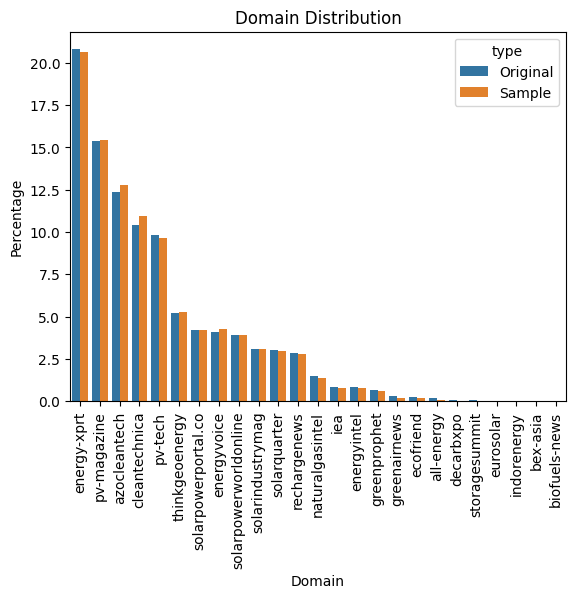

In [116]:
original_domain_counts = articles_df["domain"].value_counts().to_frame()
original_domain_counts = original_domain_counts / original_domain_counts.sum() * 100
domain_counts_df = original_domain_counts.copy()
domain_counts_df["type"] = "Original"


sample_domain_counts = sample_df["domain"].value_counts().to_frame()
sample_domain_counts = sample_domain_counts / sample_domain_counts.sum() * 100
sample_domain_counts["type"] = "Sample"

domain_counts_df = pd.concat([domain_counts_df, sample_domain_counts])
sns.barplot(
    x=domain_counts_df.index,
    y=domain_counts_df["count"],
    hue=domain_counts_df["type"]
)
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

Now all is prepared to start developing our RAG!

### For Media QA pairs datset



In [117]:
eval_articles_df_media = articles_df[articles_df["url"].isin(human_eval_df_media["url"])]
eval_articles_df_media.head()

title  \
63200              NREL Project Investigates Wind Condition Impacts on Solar Power Structures   
42863             Patrick Harvie: Ukraine invasion doesn't justify North Sea production boost   
98356  South Korea tests photovoltaics on railroad noise barriers – pv magazine International   
98368          Quebec publishes draft documents for 1.3 GW tender – pv magazine International   
63288                  New SEIA Nonprofit Serves to Advance Solar Industry Research, Policies   

                                                                                                   content  \
63200  ['High wind loads increase structural design costs of concentrating solar power ( CSP) collector...   
42863  ['Scottish Green party co-leader Patrick Harvie has said the war in Ukraine must not be used to ...   
98356  ['Land-scarce South Korea is currently hosting a series of initiatives aimed at deploying solar ...   
98368  ['The Canadian provincial government’ s Green Economy Plan, launched in November 2020, envisages...   
63288  ['The Solar Energy Industries Association ( SEIA) is launching a 501 ( c) 3 nonprofit to acceler...   

                 domain  \
63200  solarindustrymag   
42863       energyvoice   
98356       pv-magazine   
98368       pv-magazine   
63288  solarindustrymag   

                                                                                                       url  \
63200  solarindustrymag.com/nrel-project-investigates-wind-condition-impacts-on-solar-power-structures#...   
42863                                     energyvoice.com/oilandgas/europe/395102/north-sea-patrick-harvie   
98356                pv-magazine.com/2022/04/21/south-korea-tests-photovoltaics-on-railroad-noise-barriers   
98368                        pv-magazine.com/2022/04/27/quebec-publishes-draft-documents-for-1-3-gw-tender   
63288           solarindustrymag.com/new-seia-nonprofit-serves-to-advance-solar-industry-research-policies   

                                                                                                   article  \
63200  High wind loads increase structural design costs of concentrating solar power ( CSP) collector s...   
42863  Scottish Green party co-leader Patrick Harvie has said the war in Ukraine must not be used to ju...   
98356  Land-scarce South Korea is currently hosting a series of initiatives aimed at deploying solar on...   
98368  The Canadian provincial government’ s Green Economy Plan, launched in November 2020, envisages a...   
63288  The Solar Energy Industries Association ( SEIA) is launching a 501 ( c) 3 nonprofit to accelerat...   

      lang  readability  
63200   en        30.09  
42863   en        52.12  
98356   en        52.09  
98368   en        40.69  
63288   en        38.05

In [118]:
print(eval_articles_df_media["url"].unique().shape)
print(human_eval_df_media["url"].unique().shape)

(48,)
(48,)


Creating common embeddings for the given QA evaluation dataset and Our Curated dataset

In [119]:
sample_df_media = sample_df.copy()
# if the articles are already in the subsample from the evaluation set, then we remove them, so we just want unique urls
sample_df_media = sample_df_media[~sample_df_media["url"].isin(eval_articles_df_media["url"])]
sample_df_media = pd.concat([sample_df_media, eval_articles_df_media])
sample_df_media.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1051 entries, 17313 to 23380
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        1051 non-null   object 
 1   content      1051 non-null   object 
 2   domain       1051 non-null   object 
 3   url          1051 non-null   object 
 4   article      1051 non-null   object 
 5   lang         1051 non-null   object 
 6   readability  1051 non-null   float64
dtypes: float64(1), object(6)
memory usage: 65.7+ KB


In [120]:
domain_counts = sample_df_media['domain'].value_counts()
print(domain_counts)

domain
energy-xprt              207
pv-magazine              164
azocleantech             135
cleantechnica            125
pv-tech                   97
thinkgeoenergy            53
energyvoice               52
solarpowerportal.co       42
solarpowerworldonline     39
solarindustrymag          38
solarquarter              30
rechargenews              28
naturalgasintel           14
iea                        8
energyintel                8
greenprophet               6
greenairnews               2
ecofriend                  2
all-energy                 1
Name: count, dtype: int64


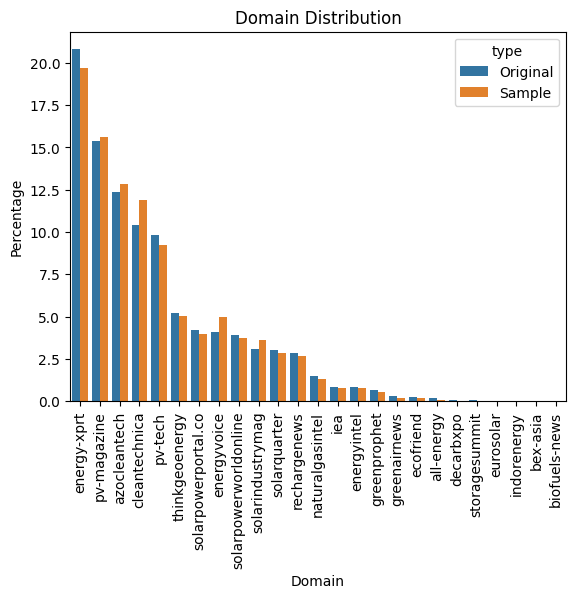

In [121]:
original_domain_counts = articles_df["domain"].value_counts().to_frame()
original_domain_counts = original_domain_counts / original_domain_counts.sum() * 100
domain_counts_df = original_domain_counts.copy()
domain_counts_df["type"] = "Original"


sample_domain_counts = sample_df_media["domain"].value_counts().to_frame()
sample_domain_counts = sample_domain_counts / sample_domain_counts.sum() * 100
sample_domain_counts["type"] = "Sample"

domain_counts_df = pd.concat([domain_counts_df, sample_domain_counts])
sns.barplot(
    x=domain_counts_df.index,
    y=domain_counts_df["count"],
    hue=domain_counts_df["type"]
)
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

Above in order to have only 1 embedding type for seed QA dataset and our generated QA dataset. we combined the articles from both of them to subsampled dataset. Thats why there is a bit mismatch in original and subsampled dataset distribution.

### For Generated Patent QA Dataset

In [122]:
human_eval_df_patent.head()

id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                      relevant_section  \
0  Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...   
1  Water path manifold structure of hydrogen energy automobile electric pileThe utility model discl...   
2  Active power control method of water-fire-wind-solar energy storage multi-energy complementary i...   
3  Water conservancy and hydropower engineering construction tunnel internal flow guiding and drain...   
4  Medium-and-long-term electric power quantity balancing method for electric power system containi...   

                                                                                              question  \
0                                                 How does the system reduce the cost of cold storage?   
1                                                                What is good about the utility model?   
2  What is the purpose of using power supply with better regulation performance to compensate for p...   
3  What is the water conservancy and hydropower engineering construction hole inner diversion drain...   
4          What is the main consideration for the balancing method, in addition to safety and economy?   

                                                                                                answer  \
0  The system reduces the cost of cold storage by converting solar energy into electric energy, whi...   
1                   The utility model has a simple structure that is easy to assemble and disassemble.   
2  The power supply with better regulation performance is used to carry out compensation regulation...   
3  The utility model discloses a water conservancy and hydropower engineering construction hole inn...   
4  The seasonal characteristics of renewable energy sources in time and the coordination problem of...   

                                              category  groundedness_score  \
0  Sustainability & Technological Innovation Questions                 5.0   
1                   Analytical & Explanatory Questions                 5.0   
2                   Government & Corporate Initiatives                 5.0   
3  Sustainability & Technological Innovation Questions                 5.0   
4                   Analytical & Explanatory Questions                 4.0   

                                                                                     groundedness_eval  \
0    The question can be answered based on the given context, and the answer is clear and unambiguous.   
1  The question "What is good about the utility model?" is somewhat ambiguous without further clari...   
2  The question is clearly answerable by understanding the purpose of using power supply with bette...   
3  The question is clearly answerable with the given context, as it describes a specific inner dive...   
4  The context provides a detailed description of a method for balancing electric quantity in a pow...   

   relevance_score  \
0              4.0   
1              3.0   
2              3.0   
3              3.0   
4              4.0   

                                                                                        relevance_eval  \
0  The question is concise and to the point, directly asking about a specific aspect of how the Hug...   
1  The question is very short and to the point, but it lacks context and detail about the specific ...   
2  The question is directly related to power supply regulation and its impact on the performance of...   
3  The question seems to be about a specific technical term, which may be useful for machine learni...   
4  The question is asking about a specific aspect of the balancing method, which is a common techni...   

   standalone_score  \
0               5.0   
1               5.0   
2               5.0   
3               5.0   
4               5.0   

                      

In patent dataset there are same titles and but separate abstracts and vice versa, so to get the unique data row we compare title and abstract both at the same time.

In [123]:
eval_abstracts_df_patent = patents_df[
    patents_df["title"].str.lower().isin(human_eval_df_patent["title"].str.lower()) |
    patents_df["abstract"].str.lower().isin(human_eval_df_patent["relevant_section"].str.lower())
]
eval_abstracts_df_patent.head()

publication_number application_number country_code  \
9045      CN-114558462-B  CN-202210285989-A           CN   
12854     CN-218580607-U  CN-202222107350-U           CN   
22518     CN-114777340-A  CN-202210508526-A           CN   
32032     CN-113775355-B  CN-202111218769-A           CN   
32194     CN-113683242-B  CN-202110787033-A           CN   

                                                                                                     title  \
9045                   Preparation method and application method of photothermal conversion fiber membrane   
12854  Water conservancy and hydropower engineering construction tunnel internal flow guiding and drain...   
22518  Concentrating solar energy seasonal sand high-temperature heat storage heating and hot water system   
32032  Rock mass stable type supporting device for rock burst prevention in tunnel excavation and const...   
32194  Utilize solar energy to realize source separation urine and excrement and urine resourceization&...   

                                                                                                  abstract  \
9045   The invention belongs to the technical field of sea water desalination, and particularly relates...   
12854  The utility model relates to a hydraulic and hydroelectric engineering field, concretely relates...   
22518  The invention relates to a light-concentrating solar cross-season sand high-temperature heat sto...   
32032  The invention discloses a rock mass stable type supporting device for rock burst prevention in t...   
32194  The invention provides a treatment system for recycling urine and excrement by utilizing solar e...   

      title_lang abstract_lang  \
9045          en            en   
12854         en            en   
22518         en            en   
32032         en            en   
32194         en            en   

                                                                                                      text  \
9045   Preparation method and application method of photothermal conversion fiber membrane. The inventi...   
12854  Water conservancy and hydropower engineering construction tunnel internal flow guiding and drain...   
22518  Concentrating solar energy seasonal sand high-temperature heat storage heating and hot water sys...   
32032  Rock mass stable type supporting device for rock burst prevention in tunnel excavation and const...   
32194  Utilize solar energy to realize source separation urine and excrement and urine resourceization&...   

                                                                                              cleaned_text  \
9045   preparation method application method photothermal conversion fiber membrane invention belongs t...   
12854  water conservancy hydropower engineering construction tunnel internal flow guiding drainage stru...   
22518  concentrating solar energy seasonal sand high-temperature heat storage heating hot water system ...   
32032  rock mass stable type supporting device rock burst prevention tunnel excavation construction met...   
32194  utilize solar energy realize source separation urine excrement urine resourceization 39 processi...   

       topic  readability  
9045       6       -20.90  
12854      0       -33.08  
22518      1       -26.01  
32032      0         1.61  
32194      6       -74.02

In [124]:
sample_df_patent = do_stratification(patents_df, "topic", 1000, 69)
# if the articles are already in the subsample from the evaluation set, then we remove them, so we just want unique urls
sample_df_patent = sample_df_patent[~sample_df_patent["title"].isin(eval_abstracts_df_patent["title"]) & ~sample_df_patent["abstract"].isin(eval_abstracts_df_patent["abstract"])]
sample_df_patent = pd.concat([sample_df_patent, eval_abstracts_df_patent])
sample_df_patent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1009 entries, 67506 to 67707
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   publication_number  1009 non-null   object 
 1   application_number  1009 non-null   object 
 2   country_code        1009 non-null   object 
 3   title               1009 non-null   object 
 4   abstract            1009 non-null   object 
 5   title_lang          1009 non-null   object 
 6   abstract_lang       1009 non-null   object 
 7   text                1009 non-null   object 
 8   cleaned_text        1009 non-null   object 
 9   topic               1009 non-null   int64  
 10  readability         1009 non-null   float64
dtypes: float64(1), int64(1), object(9)
memory usage: 94.6+ KB


In [125]:
domain_counts = sample_df_patent['topic'].value_counts()
print(domain_counts)

topic
0    173
1    128
6    113
2    111
8    106
5     96
3     94
7     75
4     67
9     46
Name: count, dtype: int64


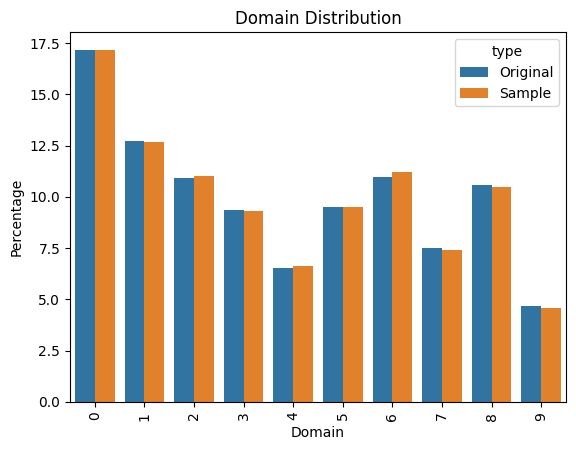

In [126]:
original_domain_counts = patents_df["topic"].value_counts().to_frame()
original_domain_counts = original_domain_counts / original_domain_counts.sum() * 100
domain_counts_df = original_domain_counts.copy()
domain_counts_df["type"] = "Original"


sample_domain_counts = sample_df_patent["topic"].value_counts().to_frame()
sample_domain_counts = sample_domain_counts / sample_domain_counts.sum() * 100
sample_domain_counts["type"] = "Sample"

domain_counts_df = pd.concat([domain_counts_df, sample_domain_counts])
sns.barplot(
    x=domain_counts_df.index,
    y=domain_counts_df["count"],
    hue=domain_counts_df["type"]
)
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.show()

Here the disribution for the subsampled dataset stays same as original

## Chunking

Chunking is a crucial step in the RAG pipeline. It involves breaking down the articles into smaller, more manageable pieces.

![chunking](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F92c70184-ba0f-4877-9a55-e4add0e311ad_870x1116.gif)

There are mainly two reasons for this:
- **Generation:** The LLM has a limit on the number of tokens it can process at once. By chunking the articles, we can ensure that the LLM can generate responses without running into this limit. Another reason to use chunks for the generation step is to avoid "distractions" from irrelevant parts of the article. Just like if you were given a book and asked to answer a question about a the book it would be easier if you were just given the relevant chapter.
- **Retrieval:** Just like the LLM, the embedding model in the retrieval step has a limit on the number of tokens it can process at once. By chunking the articles, we can ensure that the embedding model can process the entire article. By chunking the articles, we can also improve the retrieval performance by having fine-grained chunks that can be matched more closely to the user query, rather then more general chunks.

Let's start by getting a better feeling for the most common size of chunks based on the number of characters

In [127]:
def get_lorem_text(num_chars: int) -> str:
    expected_avg_word_len = 3 # on the lower side to be safe
    text = lorem.words(num_chars // expected_avg_word_len)
    return text[:num_chars]

In [128]:
print(wrap_text(get_lorem_text(256)))

fuga aperiam ipsa ipsum corrupti assumenda accusamus architecto quisquam eum dolorum maiores
voluptatum consequatur omnis quibusdam hic temporibus ducimus quam veritatis delectus dolore
nostrum quis rerum sint reprehenderit magni sit veniam minima officia 


In [129]:
print(wrap_text(get_lorem_text(512)))

similique commodi quam sint inventore aliquam earum cumque obcaecati praesentium excepturi eius
totam ab iure eveniet dolores hic possimus vero fugiat velit neque esse quod at provident nemo
illum quisquam laborum tenetur itaque nihil tempore eligendi ut et voluptate aut fugit recusandae
perferendis impedit architecto eum soluta assumenda sit reprehenderit quis voluptatibus amet
aspernatur delectus dicta ratione cupiditate consequatur expedita quaerat doloribus rerum sed autem
quibusdam incidunt repellendus


In [130]:
print(wrap_text(get_lorem_text(1024)))

rem nostrum autem laborum modi voluptates veniam voluptatum ea nesciunt iste officia alias iusto
repellendus nisi sunt veritatis voluptatem error optio sed dolorum eaque laboriosam excepturi dicta
aliquam at molestias adipisci a dolore iure eos doloribus maiores quidem ab consectetur reiciendis
ullam nihil vel quo saepe facere omnis harum voluptas soluta amet suscipit itaque deleniti incidunt
distinctio hic nam quae tempore obcaecati asperiores dolorem numquam deserunt nulla quod magni quos
corrupti enim assumenda libero corporis nobis natus labore repudiandae ipsa illo quisquam eius
minima aperiam accusamus vitae perferendis neque est molestiae culpa expedita sit ipsum similique
delectus reprehenderit quaerat odit ut tempora aliquid ratione dolor perspiciatis eveniet possimus
ex inventore praesentium dolores ducimus necessitatibus fugiat blanditiis placeat consequatur
recusandae voluptate quibusdam rerum quia explicabo porro nemo illum accusantium officiis ad
dignissimos magnam conseq

In [131]:
print(wrap_text(get_lorem_text(2048)))

reprehenderit debitis perspiciatis fuga optio eligendi temporibus numquam facilis omnis magnam illo
exercitationem non repudiandae quod cupiditate neque laborum sunt consequuntur voluptates
praesentium accusantium expedita animi eos iste harum illum et soluta quas magni deleniti labore
nulla error eveniet laudantium iure aliquid ducimus iusto commodi sint est totam tempora eaque amet
ea dolorum blanditiis aut alias necessitatibus aspernatur quisquam vel similique quia corrupti a
sit sed eum ab fugit in nostrum nisi autem ut beatae consectetur obcaecati fugiat dolores id ullam
dignissimos esse quos reiciendis facere explicabo adipisci pariatur nam quis molestias voluptatum
deserunt ipsam placeat porro quaerat officia repellat tempore delectus ex doloremque incidunt velit
minima saepe consequatur libero officiis tenetur perferendis nesciunt atque quo quibusdam ratione
minus rem dolore maxime quam odit asperiores voluptatibus quasi dolor veritatis voluptas unde hic
architecto voluptate ip

### Creating the Chunks

In this notebook we will be using two different chunking strategies:
- **Recursive Chunking:** This strategy involves recursively splitting the article into smaller chunks based on the article structure such as paragraphs and sentences until the chunk size is less than or equal to the maximum chunk size.
- **Semantic Chunking:** This strategy involves splitting the article into chunks based on semantic boundaries. This strategy finds boundaries between sentences that are semantically different and splits the article at these boundaries to create chunks. To do this we will need to use an embedding model to calculate the similarity between sentences. These embedding models will then also be used in the retrieval step to find the most relevant chunks.

To see how different texts get chunked with different strategies and chunk sizes check out the [Chunking Visualizer](https://chunkviz.up.railway.app/).

In [132]:
def get_recursive_splitter(chunk_size: int, chunk_overlap: int) -> TextSplitter:
    return RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", "(?<=\. )", " ", ""],
        length_function=len,
    )

In [133]:
# the recursive splitter mainly relies on newlines, are there even any? No, so it will focus on sentences.
sample_df["article"].map(lambda x: x.count("\n")).sum()

0

In [134]:
sample_df_media["article"].map(lambda x: x.count(".")).sum()

51806

In [135]:
sample_df_patent["abstract"].map(lambda x: x.count(".")).sum()

2495

Let us set the device for efficient use of available resources.

In [136]:
# if we can make use of any device that is better than the CPU, we will use it
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

model_kwargs = {'device': device, "trust_remote_code": True}
model_kwargs

{'device': 'cuda', 'trust_remote_code': True}

We select three embedding models from HuggingFace to represent our text fragments in numerical forma in a vector space.

In [137]:
embedding_models = {
    "mini": HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2", model_kwargs=model_kwargs),
    "bge-m3": HuggingFaceEmbeddings(model_name="BAAI/bge-m3", model_kwargs=model_kwargs),
    "gte": HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-base-en-v1.5", model_kwargs=model_kwargs),
}

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/72.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/547M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

We also define the chunking strategies to be used. The recursive splittering is characterized by the length of chunks and the overlap between adjacent chunks. For the semantic chunking, sentences embedded as dense vectors are merged as long as the cosine distance between two consecutive sentences does not exceed a percentile based threshold.

In [138]:
recursive_256_splitter = get_recursive_splitter(256, 64)
recursive_1024_splitter = get_recursive_splitter(1024, 128)
semantic_splitter = SemanticChunker(
    embedding_models["gte"], breakpoint_threshold_type="percentile"
)
splitters = {
    "recursive_256": recursive_256_splitter,
    "recursive_1024": recursive_1024_splitter,
    "semantic": semantic_splitter
}

In [139]:
from typing import Dict, List, Tuple

def chunk_documents(df: pd.DataFrame, text_splitter) -> Tuple[List[Document],]:
    chunks = []
    id = 0

    for _, row in tqdm(df.iterrows(), total=len(df)):
        if 'article' in df.columns:
            content = row['article']
            title = row.get('title', '')
            full_text = f"{title}: {content}"
            metadata = {
                'title': title,
                'url': row.get('url', ''),
                'domain': row.get('domain', ''),
            }
        elif 'abstract' in df.columns:
            content = row['abstract']
            title = row.get('title', '')
            full_text = f"{title}: {content}"
            metadata = {
                'title': title,
                'topic': row.get('topic', ''),
            }
        else:
            continue  # Skip rows that don't have expected fields

        char_chunks = text_splitter.split_text(full_text)
        for chunk in char_chunks:
            id += 1
            chunk_metadata = metadata.copy()
            chunk_metadata['id'] = id
            chunks.append(Document(
                page_content=chunk,
                metadata=chunk_metadata,
            ))

    return chunks


In [140]:
chunks_folder = silver_folder / "chunks"
if not chunks_folder.exists():
    chunks_folder.mkdir()

The following function will load existing chunks, prepared for our tutorial to speed up the preparation process.  

In [141]:
def get_or_create_chunks(df: pd.DataFrame, text_splitter: TextSplitter, splitter_name: str) -> List[Document]:
    chunks_file = chunks_folder / f"{splitter_name}_chunks.json"
    if chunks_file.exists():
        with open(chunks_file, "r") as file:
            chunks = [Document(**chunk) for chunk in json.load(file)]
        print(f"Loaded {len(chunks)} chunks from {chunks_file}")
    else:
        chunks = chunk_documents(df, text_splitter)
        with open(chunks_file, "w") as file:
            json.dump([doc.dict() for doc in chunks], file, indent=4)
        print(f"Saved {len(chunks)} chunks to {chunks_file}")
    return chunks

Creating chunks for media and patent dataset.

In [142]:
chunks = {}
for splitter_name, splitter in splitters.items():
    chunks[splitter_name+ "_media"] = get_or_create_chunks(sample_df_media, splitter, splitter_name + "_media")
    chunks[splitter_name+ "_patent"] = get_or_create_chunks(sample_df_patent, splitter, splitter_name + "_patent")

Loaded 27820 chunks from data/data_new/silver/chunks/recursive_256_media_chunks.json
Loaded 6777 chunks from data/data_new/silver/chunks/recursive_256_patent_chunks.json
Loaded 6288 chunks from data/data_new/silver/chunks/recursive_1024_media_chunks.json
Loaded 1825 chunks from data/data_new/silver/chunks/recursive_1024_patent_chunks.json
Loaded 3457 chunks from data/data_new/silver/chunks/semantic_media_chunks.json
Loaded 1313 chunks from data/data_new/silver/chunks/semantic_patent_chunks.json


Now that we have created and saved the chunks we can analyze them. We can already see above that the semantic chunks are generally larger than the recursive chunks.

### Analyzing the Chunks

Let's start by looking at the first chunk of the first article to get a feeling for what the chunks look like depending on the chunking strategy and then we will look at the distribution of the chunk sizes and the number of chunks per article.

In [143]:
for splitter_name, splitter_chunks in chunks.items():
    print(f"{splitter_name} chunks:")
    print(wrap_text(splitter_chunks[0].page_content, char_per_line=150))
    print()

recursive_256_media chunks:
Charging Ahead: The UK’ s Electric Vehicle Revolution: Change is sweeping the highways of the United Kingdom. Being responsible for 88% of passenger
miles and 79% of freight traffic, England's highways are crucial. Aside from that, despite making up just

recursive_256_patent chunks:
Light condensing device for photovoltaic module: The utility model discloses a light condensing device for a photovoltaic module, which comprises a
fixing frame, wherein the top end of the fixing frame is rotatably connected with a solar panel, two sides

recursive_1024_media chunks:
Charging Ahead: The UK’ s Electric Vehicle Revolution: Change is sweeping the highways of the United Kingdom. Being responsible for 88% of passenger
miles and 79% of freight traffic, England's highways are crucial. Aside from that, despite making up just 2% of roads, National Highways ' strategic
road network ( SRN) handles one-third of passenger miles and two-thirds of freight miles in England. Con

In [144]:
def plot_chunk_lengths(chunks: List[Document], title: str):
    sns.histplot([len(chunk.page_content) for chunk in chunks], kde=True)
    plt.title(title)
    plt.xlabel("Chunk length (characters)")
    plt.ylabel("Number of chunks")
    median_chunk_len = np.median([len(chunk.page_content) for chunk in chunks])
    mean_chunk_len = np.mean([len(chunk.page_content) for chunk in chunks])
    plt.axvline(median_chunk_len, color='r', linestyle='--', label=f"Median chunk length: {median_chunk_len:.2f}")
    plt.axvline(mean_chunk_len, color='g', linestyle='--', label=f"Mean chunk length: {mean_chunk_len:.2f}")
    plt.legend()
    plt.show()

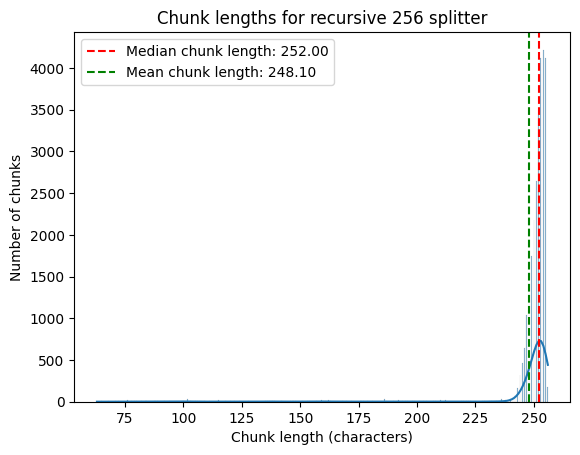

In [145]:
plot_chunk_lengths(chunks["recursive_256_media"], "Chunk lengths for recursive 256 splitter")

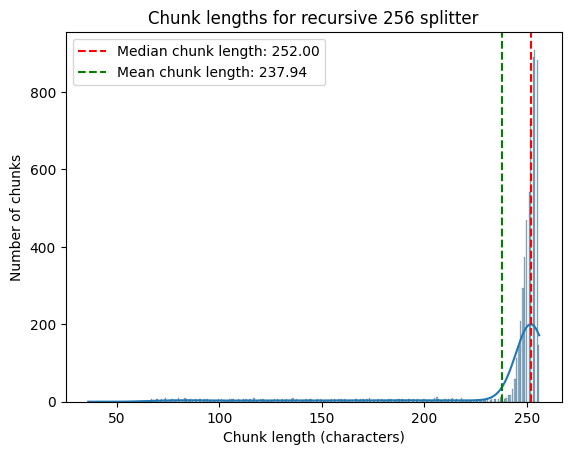

In [146]:
plot_chunk_lengths(chunks["recursive_256_patent"], "Chunk lengths for recursive 256 splitter")

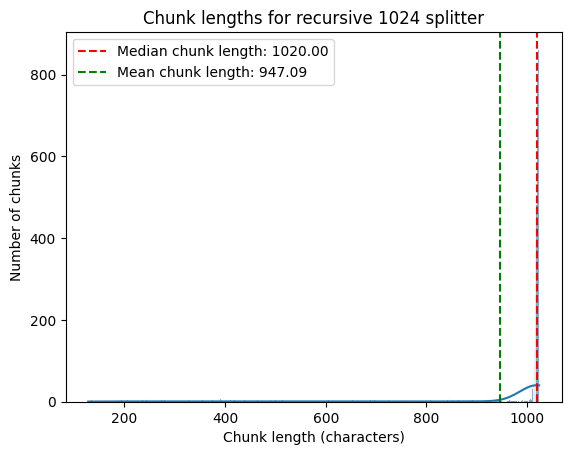

In [147]:
plot_chunk_lengths(chunks["recursive_1024_media"], "Chunk lengths for recursive 1024 splitter")

In patent datasset there are lot of chunks which could not have length 1024 and have very less chunk length.

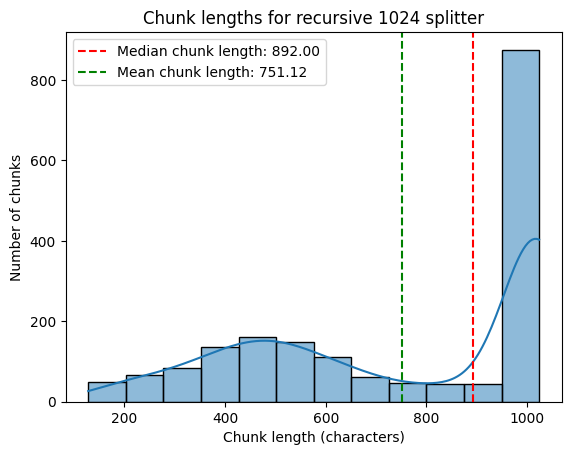

In [148]:
plot_chunk_lengths(chunks["recursive_1024_patent"], "Chunk lengths for recursive 1024 splitter")

In [149]:
plot_chunk_lengths(chunks["semantic_media"], "Chunk lengths for semantic splitter")

Diffennce in semantic chunks for both the datasets: Here we have very less amount of semantic chunks for patent dataset and mean chunk length for media is 1524 but patent is 966 only.

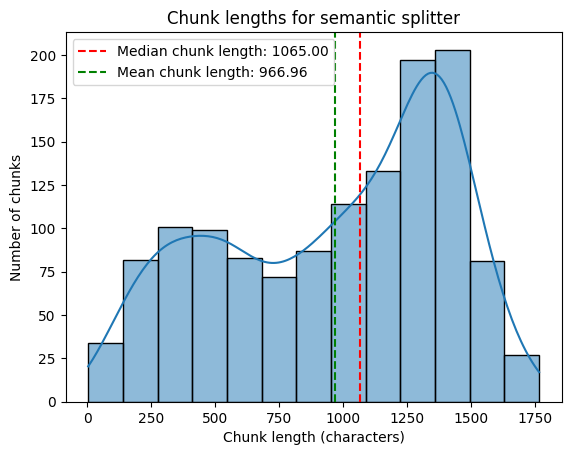

In [150]:
plot_chunk_lengths(chunks["semantic_patent"], "Chunk lengths for semantic splitter")

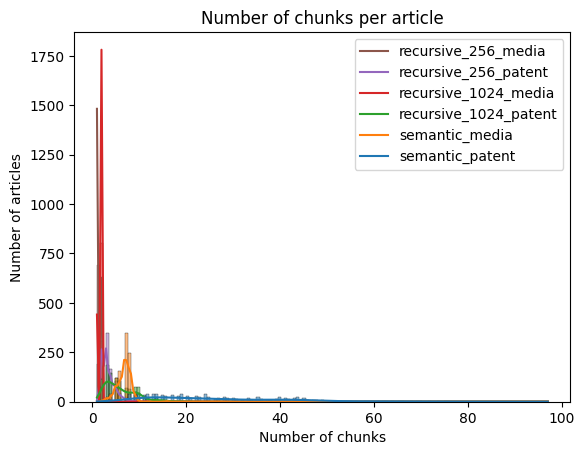

In [151]:
chunks_per_article = {splitter_name: Counter([chunk.metadata["title"] for chunk in chunks]) for splitter_name, chunks in chunks.items()}
counts = {splitter_name: [count for title, count in chunk_counts.items()] for splitter_name, chunk_counts in chunks_per_article.items()}

sns.histplot(counts, kde=True)
plt.title("Number of chunks per article")
plt.xlabel("Number of chunks")
plt.ylabel("Number of articles")
plt.legend(chunks_per_article.keys())
plt.show()

From our analysis of our created chunks we can see that the recursive chunks are all around the same size for media dataset but not the patent dataset, close to the defined maximum. On the other hand, the semantic chunks vary in size for both of them. This is because the semantic chunking strategy is based on the semantic boundaries of the article.

We can also see that despite the semantic chunks being larger, the distribution of the number of chunks per article is much wider for the recursive chunks. This is because the recursive chunks are all around the same size, while the semantic chunks have many smaller ones and a few larger ones.

## Generating Embeddings

Now that we have clean chunks, the next step involves generating embeddings for our article chunks. These embeddings will serve as a crucial component for efficient retrieval within the RAG pipeline. For our vector store we'll utilize ChromaDB, a powerful tool for indexing and searching high-dimensional data. To integrate our chosen embedding models with ChromaDB, we'll define a custom wrapper class. This wrapper class will act as an intermediary, ensuring seamless communication between the models and the ChromaDB indexing system.

In [152]:
class CustomChromadbEmbeddingFunction(EmbeddingFunction):

    def __init__(self, model) -> None:
        super().__init__()
        self.model = model

    def _embed(self, l):
        return [self.model.embed_query(x) for x in l]

    def embed_query(self, query):
        return self._embed([query])

    def __call__(self, input: Documents) -> Embeddings:
        embeddings = self._embed(input)
        return embeddings

We compared all 3 embeddings and we finalized using "bge-m3" for our pipeline, in order to save money and processing time, we only use this for the evaluation and comparison for media and patent dataset.

In [153]:
chroma_embedding_functions = {
    # "mini": CustomChromadbEmbeddingFunction(embedding_models["mini"]),
    "bge-m3": CustomChromadbEmbeddingFunction(embedding_models["bge-m3"]),
    # "gte": CustomChromadbEmbeddingFunction(embedding_models["gte"]),
}
for name, embedding_function in chroma_embedding_functions.items():
    sample = embedding_function(["Hello, world!"])[0][:5]
    print(f"{name} embedding sample: {sample}")

bge-m3 embedding sample: [-0.016155613586306572, 0.026993418112397194, -0.04258323833346367, 0.013542186468839645, -0.019354626536369324]


Generating embeddings can be a computationally intensive process. To optimize efficiency and avoid redundant computations, we'll leverage checkpointing. This technique involves storing the generated embeddings along with their corresponding article chunks. We'll define a simple class to encapsulate this data, facilitating efficient retrieval and reducing the need for recalculating embeddings unless absolutely necessary.

In [154]:
embeddings_folder = silver_folder / "embeddings"
if not embeddings_folder.exists():
    embeddings_folder.mkdir()

In [155]:
class DocumentEmbedding():
    def __init__(self, document: Document, text_embedding: List[float]) -> None:
        self.document = document
        self.text_embedding = text_embedding

    def to_dict(self) -> Dict:
        return {
            "document": self.document.dict(),
            "text_embedding": self.text_embedding
        }

    @classmethod
    def from_dict(cls, d: Dict) -> "DocumentEmbedding":
        return cls(
            document=Document(**d["document"]),
            text_embedding=d["text_embedding"]
        )


def get_or_create_embeddings(
        embedding_function: EmbeddingFunction,
        chunks: List[Document],
        embedding_name: str,
) -> List[DocumentEmbedding]:
    embeddings_file = embeddings_folder / f"{embedding_name}_embeddings.json"
    if embeddings_file.exists():
        with open(embeddings_file, "r") as file:
            embeddings = [DocumentEmbedding.from_dict(embedding) for embedding in json.load(file)]
        print(f"Loaded {len(embeddings)} embeddings from {embeddings_file}")
    else:
        embeddings = []
        for chunk in tqdm(chunks):
            text_embedding = embedding_function([chunk.page_content])[0]
            embedding = DocumentEmbedding(
                document=chunk,
                text_embedding=text_embedding
            )
            embeddings.append(embedding)
        with open(embeddings_file, "w") as file:
            json.dump([embedding.to_dict() for embedding in embeddings], file, indent=4)
        print(f"Saved {len(embeddings)} embeddings to {embeddings_file}")
    return embeddings

In [156]:
embeddings = {}
for embedding_name, embedding_function in chroma_embedding_functions.items():
    for splitter_name, splitter_chunks in chunks.items():
        print(f"Generating embeddings for {embedding_name} with {splitter_name} splitter")
        embeddings[f"{embedding_name}_{splitter_name}"] = get_or_create_embeddings(
            embedding_function, splitter_chunks, f"{embedding_name}_{splitter_name}"
        )

Generating embeddings for bge-m3 with recursive_256_media splitter
Loaded 27820 embeddings from data/data_new/silver/embeddings/bge-m3_recursive_256_media_embeddings.json
Generating embeddings for bge-m3 with recursive_256_patent splitter
Loaded 6860 embeddings from data/data_new/silver/embeddings/bge-m3_recursive_256_patent_embeddings.json
Generating embeddings for bge-m3 with recursive_1024_media splitter
Loaded 6288 embeddings from data/data_new/silver/embeddings/bge-m3_recursive_1024_media_embeddings.json
Generating embeddings for bge-m3 with recursive_1024_patent splitter
Loaded 1825 embeddings from data/data_new/silver/embeddings/bge-m3_recursive_1024_patent_embeddings.json
Generating embeddings for bge-m3 with semantic_media splitter
Loaded 3457 embeddings from data/data_new/silver/embeddings/bge-m3_semantic_media_embeddings.json
Generating embeddings for bge-m3 with semantic_patent splitter
Loaded 1332 embeddings from data/data_new/silver/embeddings/bge-m3_semantic_patent_embed

The number of embeddings relates to the number of chunks produced by the individual chunking strategies, not the embedding dimensions. Thus smaller chunk size (e.g. 256) yields more chunks than larger chunk size (1024), and semantic embeddings even less chunks.

## Storing the Embeddings in ChromaDB

As mentioned above for our semantic search retrieval we will be storing the embeddings in ChromaDB. ChromaDB is a powerful tool for indexing and searching high-dimensional data. It is allows e.g. to use approximate nearest neighbor (ANN) search based on the Hierarchical Navigable Small World (HNSW) algorithm, which is known for its efficiency in searching high-dimensional spaces.

Just like with normal SQL databases we have a server, in this case an SQLite server, that we can connect to with a client. We will then use the client to connect to the server and create for each set of embeddings a new seperate database which can be thought of as the index or a vector space. ChromaDB calls these separate vector spaces "collections". These collections will then be used to search for the most relevant chunks to a user query.

![semantic search](https://images.contentstack.io/v3/assets/bltefdd0b53724fa2ce/bltf137a833984d3581/63728faba32209106e8b0b72/vector-search-diagram.png)

In [158]:
gold_folder = data_folder / "gold"
if not gold_folder.exists():
    gold_folder.mkdir()
chromadb_folder = gold_folder / "chromadb"
if not chromadb_folder.exists():
    chromadb_folder.mkdir()

chroma_client = chromadb.PersistentClient(path=chromadb_folder.as_posix())

Again we can make use of preprocessed data as before to speed up the preparatory steps.

In [160]:
def get_or_create_collection(
        name: str,
        embedding_function: EmbeddingFunction,
        embeddings: List[DocumentEmbedding],
        batch_size: int = 128
) -> Collection:

    collection = chroma_client.get_or_create_collection(
        name=name,
        # configure to use cosine distance not default L2
        metadata={"hnsw:space": "cosine"},
        embedding_function=embedding_function
    )

    if collection.count() == 0:
        for i in tqdm(range(0, len(embeddings), batch_size)):
            batch = embeddings[i:i+batch_size]
            collection.add(
                documents=[embedding.document.page_content for embedding in batch],
                embeddings=[embedding.text_embedding for embedding in batch],
                ids=[str(embedding.document.metadata["id"]) for embedding in batch],
                metadatas=[embedding.document.metadata for embedding in batch]
            )

    return collection

In [161]:
collections = {}
for collection_name, current_embeddings in embeddings.items():
    collection = get_or_create_collection(
        collection_name,
        chroma_embedding_functions[collection_name.split("_")[0]],
        current_embeddings
    )
    collections[collection_name] = collection
    print(f"Collection {collection_name} has {collection.count()} documents")

Collection bge-m3_recursive_256_media has 27264 documents
Collection bge-m3_recursive_256_patent has 6852 documents
Collection bge-m3_recursive_1024_media has 6166 documents
Collection bge-m3_recursive_1024_patent has 1825 documents
Collection bge-m3_semantic_media has 3390 documents
Collection bge-m3_semantic_patent has 1332 documents


The above printout shows the three embedding models applied to the three chunking strategies.

Once we have stored all the embeddings in ChromaDB we can test the retrieval process by querying one of our collections and see what the most similar chunks are. Try some different queries and see what the most similar chunks are and whether they make sense.

##To change

In [162]:
selected_collection_media = collections["bge-m3_recursive_1024_media"]
results = selected_collection_media.query(
    query_texts=["Climate Change"],
    n_results=3,
)
for doc in results["documents"][0]:
    print(wrap_text(doc))
    print()

Climate change, water, and the energy transition challenge: Changes in the Earth’ s climate and
weather patterns are already having a significant impact on many people’ s ability to access water.
Concerningly, with the Paris Agreement in danger and global net zero targets still some way off,
it’ s likely this problem will get worse before it gets better. This should give cause for concern
when you consider that water is critical to the production of virtually all energy. Whether it be
for use in raw material extraction for renewables components, steam generation for gas turbines, as
a feedstock for green hydrogen, or as a cooling agent in nuclear power facilities and carbon
capture and storage plants, H2O is integral. In the 2024 edition of our UK Energy Transition
Outlook ( ETO), released earlier this year, DNV forecasts that by 2040, as the transition
progresses and the UK’ s energy landscape evolves, electricity will account for about half of final
demand. By 2050, low carbon source

In [163]:
selected_collection_patent = collections["bge-m3_recursive_1024_patent"]
results = selected_collection_patent.query(
    query_texts=["Climate Change"],
    n_results=3,
)
for doc in results["documents"][0]:
    print(wrap_text(doc))
    print()

heat pipeline, the hydrogen/oxygen fuel cell system is connected with a hot water tank for
providing temperature difference for a temperature difference power generation device through a
fourth circulating heat pipeline, and the temperature difference power generation device is
electrically connected with a second storage battery through a lead, compared with the prior art,
the utility model has the following beneficial effects: the solar energy is collected and converted
into hydrogen energy with higher energy density, and the hydrogen energy is applied to the
hydrogen/oxygen fuel cell system.

Heat exchange station system and method for heating secondary net water by using geothermal energy:
The invention provides a heat exchange station system and a method for heating secondary network
water by utilizing geothermal energy, comprising an electric heating pump unit, a geothermal
heating unit and a geothermal heat source unit, wherein the geothermal heat source unit comprises a
geother

## Analyzing the Embedding Space


To gain a better understandign of how the retrieval process works we will analyze the embedding space. We will start by projecting the embeddings into a 2D space using UMAP. UMAP is a dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional data in a lower-dimensional space. The most notable advantages over other dimensionality reduction techniques are increased speed and better preservation of the data's global structure. We will then use the UMAP embeddings to create a scatter plot of the chunks.

In [164]:
def get_vectors_from_collection(collection: Collection):
    stored_chunks = collection.get(include=["documents", "metadatas", "embeddings"])
    return np.array(stored_chunks["embeddings"])

def get_vectors_by_domain(collection: Collection, domain: str):
    stored_chunks = collection.get(include=["documents", "metadatas", "embeddings"])
    metadatas = stored_chunks["metadatas"]
    indices = []
    for metadata in metadatas:
        # Check if either 'topic' or 'domain' key exists in metadata
        if "topic" in metadata and metadata["topic"] == domain:
            indices.append(str(metadata["id"]))
        elif "domain" in metadata and metadata["domain"] == domain:
            indices.append(str(metadata["id"]))
    return collection.get(include=["embeddings"], ids=indices)["embeddings"]

def fit_umap(vectors: np.ndarray):
    return umap.UMAP().fit(vectors)

def project_embeddings(embeddings, umap_transform):
    return umap_transform.transform(embeddings)

The dimensions above show how the chunked embeddings with 768 dimensions are reduced to two dimensions for visualization purposes.

You can zoom in the plot by clicking and dragging a box around the area you want to zoom in on. You can also reset the plot by double clicking on the plot.

Next we will color the embeddings by the domain of the article to see if there are any patterns or clusters in the embedding space based on the domain.

We can also visualize the retrieval process by plotting the query and the most similar chunks in the embedding space. This will give us a better understanding of how the retrieval process works and how the most similar chunks are found.

Note that the UMAP projection uses a metric approach which differs from the approximate nearest neighbor approach used for retrieval. Also don't forget that the embeddings are in a high-dimensional space and we are only visualizing a 2D projection of them so the distances between the points might not be accurate. Try some different queries and see how the most similar chunks are found.

In [165]:
def plot_retrieval_results(
        query: str,
        selected_collection: Collection,
        n_results: int = 5
):
    vectors = get_vectors_from_collection(selected_collection)
    umap_transform = fit_umap(vectors)
    vectors_projections = project_embeddings(vectors, umap_transform)

    query_embedding = selected_collection._embedding_function([query])[0]
    query_embedding = np.array(query_embedding).reshape(1, -1)
    query_projection = project_embeddings(query_embedding, umap_transform)

    nearest_neighbors = selected_collection.query(
        query_texts=[query],
        n_results=n_results,
    )
    neighbor_vectors = selected_collection.get(include=["embeddings"], ids=nearest_neighbors["ids"][0])["embeddings"]
    neighbor_projections = project_embeddings(neighbor_vectors, umap_transform)


    fig = go.Figure()

    fig.add_trace(go.Scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1], mode='markers', marker=dict(size=5), name="other vectors"))
    fig.add_trace(go.Scatter(x=neighbor_projections[:, 0], y=neighbor_projections[:, 1], mode='markers', marker=dict(size=5, color='orange'), name="nearest neighbors"))
    fig.add_trace(go.Scatter(x=query_projection[:, 0], y=query_projection[:, 1], mode='markers', marker=dict(size=10, color='red', symbol='x'), name="query"))

    fig.show(renderer="colab")

Lastly we will analyze the distribution of the cosine distances between the query and the different chunks. This will give us a better understanding of the cosine distance and show that the distances in the high-dimensional space are not the same as in the 2D projection. Do not confuse the cosine distance with the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). The cosine similarity is the cosine of the angle between two vectors and the cosine distance is 1 minus the cosine similarity so that smaller numbers mean the vectors are more similar.

In [166]:
def cosine_distance(vector1, vector2):
    dot_product = np.dot(vector1, vector2.T)
    norm_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    similarity = dot_product / norm_product
    return 1 - similarity

def plot_cosine_distances(
        query: str,
        selected_collection: Collection
):
    vectors = get_vectors_from_collection(selected_collection)
    umap_transform = fit_umap(vectors)
    vectors_projections = project_embeddings(vectors, umap_transform)

    query_embedding = selected_collection._embedding_function([query])[0]
    query_embedding = np.array(query_embedding).reshape(1, -1)
    query_projection = project_embeddings(query_embedding, umap_transform)

    similarities = np.array([cosine_distance(query_embedding, vector) for vector in vectors])

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=vectors_projections[:, 0],
        y=vectors_projections[:, 1],
        mode='markers',
        marker=dict(
            size=5,
            color=similarities.flatten(),
            colorscale='RdBu',
            colorbar=dict(title='Cosine Distance')
        ),
        text=['Cosine Distance: {:.4f}'.format(
            sim) for sim in similarities.flatten()],
        name='Other Vectors'
    ))

    fig.add_trace(go.Scatter(x=[query_projection[0][0]], y=[
                query_projection[0][1]], mode='markers', marker=dict(size=10, color='black', symbol='x'), text=['Query Vector'], name='Query Vector'))

    fig.show(renderer="colab")

### Analyze the embedding space for media dataset



In [170]:
vectors = get_vectors_from_collection(selected_collection_media)
print(f"Original shape: {vectors.shape}")
umap_transform = fit_umap(vectors)
vectors_projections = project_embeddings(vectors, umap_transform)
print(f"Projected shape: {vectors_projections.shape}")

Original shape: (6166, 1024)
Projected shape: (6166, 2)


In [171]:
fig = px.scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1])
fig.show(renderer="colab")

In [172]:
fig = go.Figure()
for domain in sample_df_media["domain"].unique():
    domain_vectors = get_vectors_by_domain(selected_collection_media, domain)
    domain_projections = project_embeddings(domain_vectors, umap_transform)
    fig.add_trace(go.Scatter(x=domain_projections[:, 0], y=domain_projections[:, 1], mode='markers', marker=dict(size=4), name=domain))

fig.show(renderer="colab")

In [441]:
plot_retrieval_results(
    "Climate Change",
    selected_collection_media,
)
plot_cosine_distances(
    "Climate Change",
    selected_collection_media,
)

### Analyze the embedding space for media dataset


In [175]:
vectors = get_vectors_from_collection(selected_collection_patent)
print(f"Original shape: {vectors.shape}")
umap_transform = fit_umap(vectors)
vectors_projections = project_embeddings(vectors, umap_transform)
print(f"Projected shape: {vectors_projections.shape}")

Original shape: (1825, 1024)
Projected shape: (1825, 2)


In [176]:
fig = px.scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1])
fig.show(renderer="colab")

In [177]:
fig = go.Figure()
for domain in sample_df_patent["topic"].unique():
    domain_vectors = get_vectors_by_domain(selected_collection_patent, domain)
    domain_projections = project_embeddings(domain_vectors, umap_transform)
    # Convert the domain to a string before passing it as the 'name'
    fig.add_trace(go.Scatter(x=domain_projections[:, 0], y=domain_projections[:, 1], mode='markers', marker=dict(size=4), name=str(domain)))

fig.show(renderer="colab")

In [442]:
plot_retrieval_results(
    "Climate Change",
    selected_collection_patent,
)
plot_cosine_distances(
    "Climate Change",
    selected_collection_patent,
)

In [443]:
plot_retrieval_results(
    "Renewable Energy",
    selected_collection_media,
)
plot_cosine_distances(
    "Renewable Energy",
    selected_collection_media,
)

In [444]:
plot_retrieval_results(
    "Renewable Energy",
    selected_collection_patent,
)
plot_cosine_distances(
    "Renewable Energy",
    selected_collection_patent,
)

The patent dataset in the above plots has more spread in cosine distances and embedding space compared to the media dataset, it suggests that the patent data contains more diverse or distinct concepts, with the model capturing a wider range of semantic differences. On the other hand, the media dataset likely has more homogeneous or similar embeddings, indicating less diversity or more similarity between the data points.
Also the higher cosine distance means that the vectors (representing the query and the chunks) are more dissimilar or farther apart in the high-dimensional space. Since cosine distance is calculated as
1 - cosine similarity, a larger cosine distance corresponds to a smaller cosine similarity, indicating that the vectors are less similar or more orthogonal to each other.

## Putting it all Together

Now that we have generated the embeddings and stored them in ChromaDB we can put it all together and create the RAG pipeline. The RAG pipeline consists of the following steps:
- **Indexing:** The first step is the preperation we have already done. We have chunked the articles and generated embeddings for the chunks and stored them in ChromaDB, our vector store/index.
- **Retrieval:** The next step in the RAG pipeline is to retrieve the most relevant chunks to the user query. This is done by querying the ChromaDB index with the user query and retrieving the most similar chunks.
- **Generation:** The next step is to generate a response to the user query. This is done by feeding the retrieved chunks and the user query to the LLM and generating a response.

### How does Langchain work?

In this notebook we will be using [Langchain](https://www.langchain.com/) to build up our pipeline. You do not need a library like Langchain or [LlamaIndex](https://www.llamaindex.ai/) to build a RAG pipeline, but it can make the process easier.

The idea of Langchain and its LCEL (Langchain Expression Language) is very simple. Within the pipeline there are lots of steps that take an input and produce an output. These steps can be chained together to form a pipeline. The LCEL is a simple language that allows you to define these steps and how they are connected. For more technical details on how Langchain works check out the [Langchain Documentation](https://python.langchain.com/v0.1/docs/expression_language/).

In simple terms langchain provides an abstraction of a step that has an `invoke` method that takes an input, a dictionary of parameters and returns an output also a dictionary. This allows you to chain together different steps and define how they are connected and also split of chains of steps into separate pipelines.

Below you can see an overview of our RAG pipeline:

![rag_pipeline](https://miro.medium.com/v2/resize:fit:1400/0*XE_XZ3QrRhlB3b_q.png)

And now let's look at the implementation of the RAG pipeline.

In [325]:
def create_qa_chain(retriever: BaseRetriever):
    template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \
    If you don't know the answer, just say that you don't know. Keep the answer concise.

    Question: {question}
    Context: {context}
    Answer:
    """
    rag_prompt = ChatPromptTemplate.from_template(template)

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = RunnableParallel(
        {
            "context": retriever,
            "question": RunnablePassthrough()
        }
    ).assign(answer=(
         RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
            | rag_prompt
            | llm
            | StrOutputParser()
    ))

    return rag_chain

For Langchain to work with our ChromaDB collections we need to transform the collections into a format that Langchain can work with so called stores and retrievers.

In [180]:
def collection_to_store(collection_name: str, lc_embedding_model: EmbeddingFunction):
    return Chroma(
        client=chroma_client,
        collection_name=collection_name,
        embedding_function=lc_embedding_model,
    )

def store_to_retriever(store: VectorStore, k: int = 3):
    retriever = store.as_retriever(
        search_type="similarity", search_kwargs={'k': k}
    )
    return retriever

##To check

Now that we have our retriever we can create our RAG pipeline. Try some different queries and see how the pipeline responds.

In [181]:
selected_store_media = collection_to_store("bge-m3_recursive_1024_media", embedding_models["bge-m3"])
selected_retriever_media = store_to_retriever(selected_store_media)
selected_retriever_media.invoke("Climate Change")

[Document(metadata={'domain': 'energyvoice', 'id': 3186, 'title': 'Climate change, water, and the energy transition challenge', 'url': 'energyvoice.com/renewables-energy-transition/hydrogen/552964/climate-change-water-and-the-energy-transition-managing-the-balance'}, page_content='Climate change, water, and the energy transition challenge: Changes in the Earth’ s climate and weather patterns are already having a significant impact on many people’ s ability to access water. Concerningly, with the Paris Agreement in danger and global net zero targets still some way off, it’ s likely this problem will get worse before it gets better. This should give cause for concern when you consider that water is critical to the production of virtually all energy. Whether it be for use in raw material extraction for renewables components, steam generation for gas turbines, as a feedstock for green hydrogen, or as a cooling agent in nuclear power facilities and carbon capture and storage plants, H2O is 

In [184]:
selected_chain_media = create_qa_chain(selected_retriever_media)
selected_chain_media.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

{'context': [Document(metadata={'domain': 'cleantechnica', 'id': 1300, 'title': 'Some Gas Utilities Are Leading The Way Into The Future, Others Are Actively In Reverse', 'url': 'cleantechnica.com/2023/05/11/some-gas-utilities-are-leading-the-way-into-the-future-others-are-actively-in-reverse'}, page_content='halved. Australians watching the news about Canada’ s current spate of wildfires will remember our own horrifying bushfires a couple of years ago. The fear is... Copyright © 2023 CleanTechnica. The content produced by this site is for entertainment purposes only. Opinions and comments published on this site may not be sanctioned by and do not necessarily represent the views of CleanTechnica, its owners, sponsors, affiliates, or subsidiaries.'),
  Document(metadata={'domain': 'cleantechnica', 'id': 938, 'title': 'World’ s Largest Floating Solar Array, Manchin Movement On Climate — Nexus News Roundup', 'url': 'cleantechnica.com/2022/01/06/worlds-largest-floating-solar-array-manchin-m

In [185]:
selected_store_patent = collection_to_store("bge-m3_recursive_1024_patent", embedding_models["bge-m3"])
selected_retriever_patent = store_to_retriever(selected_store_patent)
selected_retriever_patent.invoke("Climate Change")

[Document(metadata={'id': 981, 'title': 'Hydrogen energy recycling system in extremely cold region', 'topic': 4}, page_content='heat pipeline, the hydrogen/oxygen fuel cell system is connected with a hot water tank for providing temperature difference for a temperature difference power generation device through a fourth circulating heat pipeline, and the temperature difference power generation device is electrically connected with a second storage battery through a lead, compared with the prior art, the utility model has the following beneficial effects: the solar energy is collected and converted into hydrogen energy with higher energy density, and the hydrogen energy is applied to the hydrogen/oxygen fuel cell system.'),
 Document(metadata={'id': 341, 'title': 'Heat exchange station system and method for heating secondary net water by using geothermal energy', 'topic': 1}, page_content='Heat exchange station system and method for heating secondary net water by using geothermal energy

In [186]:
selected_chain_patent = create_qa_chain(selected_retriever_patent)
selected_chain_patent.invoke("How does the system reduce the cost of cold storage?")

{'context': [Document(metadata={'id': 1817, 'title': 'Distributed photovoltaic energy storage refrigeration house system', 'topic': 7}, page_content='the cold accumulation compressor unit; the refrigeration house refrigeration system comprises a refrigeration house body, a refrigeration house compressor, a refrigeration house evaporator and a refrigeration house condenser, wherein the refrigeration house body is in contact with the cold accumulation equipment, the refrigeration house evaporator and the refrigeration house compressor are located in the refrigeration house body, and the refrigeration house condenser is located in the cold accumulation equipment. The solar energy is converted into the electric energy, the electric energy is converted into the cold source to store ice, and the cold storage equipment supplies cold to the cold storage, so that the cost of the cold storage is reduced, and the energy is saved.'),
  Document(metadata={'id': 1025, 'title': 'Energy-saving on-site

In [445]:
selected_retriever_media.invoke("Renewable Energy")

[Document(metadata={'domain': 'energy-xprt', 'id': 2954, 'title': 'Renewable Energy Technology ( Renewable Energy) Training and...', 'url': 'energy-xprt.com/renewable-energy/renewable-energy-technology/training'}, page_content='Renewable Energy Technology ( Renewable Energy) Training and...: This course examines the role of a variety of technologies and strategies in achieving a sustainable urban environment. It covers opportunities for energy conservation, the shift toward decentralized power generation, several renewable energy technologies adapted for the urban environment, energy efficient buildings, alternative modes of transportation, urban planning, and government... By School of the Environment-University of Toronto based in Toronto, ONTARIO ( CANADA). This course investigates the principle types of renewable energy, as well as historical and technological challenges, and their place in the current global market. The place of renewable energy in society as a whole is examined t

In [446]:
selected_retriever_patent.invoke("Renewable Energy")

[Document(metadata={'id': 955, 'title': 'Electricity storage hydrogen production method and application thereof', 'topic': 4}, page_content='with a renewable energy source generating device to establish a local energy source network; the invention solves the safety problems of hydrogen production, storage, transportation and use, provides a convenient and low-cost energy storage mode for renewable energy sources such as solar energy, wind energy, ocean energy and the like, and has wide application prospect in the fields of mobile equipment of vehicles, fixed equipment such as power stations and the like, chemical industry metallurgy and the like, and the fields related to hydrogen energy.'),
 Document(metadata={'id': 536, 'title': 'Renewable energy driven zero-carbon efficient distributed energy supply system and operation method', 'topic': 1}, page_content='Renewable energy driven zero-carbon efficient distributed energy supply system and operation method: The invention discloses a ze

In [448]:
selected_chain_media.invoke("Which organizations or countries are most active in cleantech technology?")

{'context': [Document(metadata={'domain': 'energyvoice', 'id': 3298, 'title': 'Who are the top innovators for the energy transition? - News for the Energy Sector', 'url': 'energyvoice.com/events/392726/who-are-the-top-innovators-for-the-energy-transition-articleisfree'}, page_content='environments. To explore this fast-changing landscape, Reuters Events we have drawn on their expertise as the world’ s leading provider of cleantech events to select 100 of the companies that we feel are leading innovation in the energy transition, split across key categories. Within the 10 companies named in each category, we have selected three for special mention. It is important to note that companies are not listed in any particular order: in the race to net-zero emissions, every ounce of innovation is worthy of praise. Download a complimentary copy of the report today: Click here Any top 100 list will attract scrutiny for the names that were included and those that were left out. This one, based on 

In [449]:
selected_chain_patent.invoke("Which organizations or countries are most active in cleantech technology?")

{'context': [Document(metadata={'id': 197, 'title': 'Water quality monitoring device', 'topic': 0}, page_content='Water quality monitoring device: The utility model belongs to the technical field of marine product cultivation underwater, in particular to a water quality monitoring device, aiming at three problems of filter screen cleaning, battery replacement and counterweight adjustment, which are proposed by the background technology, the utility model provides a scheme which comprises a cleaning mechanism, a power supply mechanism and an adjusting mechanism, wherein the cleaning mechanism comprises a balance plate, a filter box fixedly connected with the center position of the bottom of the balance plate, a cleaning motor arranged at the center position of the top of the balance plate, a mounting frame for connecting an output shaft of the cleaning motor through the balance plate and a cleaning roller arranged at the bottom of the mounting frame, and the power supply mechanism compr

Only considering bge-m3 embeddeings here

In [187]:
chains = {}
for collection_name, collection in collections.items():
    store = collection_to_store(collection_name, embedding_models[collection_name.split("_")[0]])
    retriever = store_to_retriever(store)
    chain = create_qa_chain(retriever)
    chains[collection_name] = chain

chains.keys()

dict_keys(['bge-m3_recursive_256_media', 'bge-m3_recursive_256_patent', 'bge-m3_recursive_1024_media', 'bge-m3_recursive_1024_patent', 'bge-m3_semantic_media', 'bge-m3_semantic_patent'])

## Evaluation

Because we have many hyperparameters such as chunk size, prompts etc. to tune and different strategies to try we will use the [RAGAS (RAG Assesment) framework](https://docs.ragas.io/en/stable/) to evaluate our pipeline. RAGAS is a framework that allows you to evaluate your RAG pipeline with an LLM as a judge and other metrics that also utilize embedding models. We will go more into detail on the metrics later on.

Before we can start the evaluation we need to define the evaluation questions and their ground truth answers. For this we will use the provided evaluation questions. To increase our question pool we will also generate some additional question and answer pairs based on a random chunk and utilizing the LLM (GPT-4o) to generate the question and answer.

In [188]:
human_eval_df.head()

example_id  \
0           1   
1           2   
2           3   
3           4   
4           5   

                                                                                 question  \
0  What is the innovation behind Leclanché's new method to produce lithium-ion batteries?   
1                                            What is the EU’s Green Deal Industrial Plan?   
2                                            What is the EU’s Green Deal Industrial Plan?   
3                   What are the four focus areas of the EU's Green Deal Industrial Plan?   
4              When did the cooperation between GM and Honda on fuel cell vehicles start?   

                                                                                      relevant_section  \
0  Leclanché said it has developed an environmentally friendly way to produce lithium-ion (Li-ion) ...   
1  The Green Deal Industrial Plan is a bid by the EU to make its net zero industry more competitive...   
2  The European counterpart to the US Inflation Reduction Act (IRA) aims to create an environment t...   
3  The new plan is fundamentally focused on four areas, or pillars: the regulatory environment, acc...   
4  What caught our eye was a new hookup between GM and Honda. Honda was also hammering away at the ...   

                                                                                                answer  \
0  Leclanché's innovation is using a water-based process instead of highly toxic organic solvents t...   
1  The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry...   
2  The EU’s Green Deal Industrial Plan aims to enhance the competitiveness of its net zero industry...   
3  The four focus areas of the EU's Green Deal Industrial Plan are the regulatory environment, acce...   
4                                                                                            July 2013   

                                                                                                   url  
0  sgvoice.energyvoice.com/strategy/technology/23971/leclanches-new-disruptive-battery-boosts-energ...  
1      sgvoice.energyvoice.com/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan  
2                 pv-magazine.com/2023/02/02/european-commission-introduces-green-deal-industrial-plan  
3      sgvoice.energyvoice.com/policy/25396/eu-seeks-competitive-boost-with-green-deal-industrial-plan  
4          cleantechnica.com/2023/05/08/general-motors-seizes-the-fuel-cell-moment-with-green-hydrogen

our curated QA pairs for Media dataset

In [189]:
human_eval_df_media.head()

id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                      relevant_section  \
0  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
1  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
2  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
3  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
4  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   

                                                                                              question  \
0                                                      What is green hydrogen, and how is it produced?   
1  What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hy...   
2  What is the significance of the Energy Transitions Commission's report on making clean electrifi...   
3          How does green hydrogen compare to direct use of electricity in terms of energy efficiency?   
4  What are some of the examples of pilot projects testing the viability of green hydrogen in vario...   

                                                                                                answer  \
0  Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...   
1  The Neom project, a partnership between ACWA Power, Air Products, and NEOM, harnesses solar and ...   
2  The report highlights the need for a 30-year transition to electrify the global economy, providi...   
3  Green hydrogen production through electrolysis is less energy-efficient than direct use of elect...   
4  Various pilot projects are testing green hydrogen's viability in energy systems, demonstrating i...   

                                            url  \
0  azocleantech.com/article.aspx?ArticleID=1823   
1  azocleantech.com/article.aspx?ArticleID=1823   
2  azocleantech.com/article.aspx?ArticleID=1823   
3  azocleantech.com/article.aspx?ArticleID=1823   
4  azocleantech.com/article.aspx?ArticleID=1823   

                                              category  groundedness_score  \
0  Sustainability & Technological Innovation Questions                 5.0   
1  Sustainability & Technological Innovation Questions                 5.0   
2  Sustainability & Technological Innovation Questions                 5.0   
3  Sustainability & Technological Innovation Questions                 4.0   
4  Sustainability & Technological Innovation Questions                 5.0   

                                                                                     groundedness_eval  \
0  The provided context clearly explains what green hydrogen is, how it is produced through water e...   
1  The context provides a comprehensive overview of the significance of green hydrogen and its inte...   
2  The question regarding the significance of the Energy Transitions Commission's report "Making Cl...   
3  The question requires an in-depth analysis of the context provided, specifically focusing on the...   
4  The question can be answered unambiguously based on the provided context, which describes variou...   

   relevance_score  \
0              3.0   
1              4.0   
2              3.0   
3              4.0   
4              3.0   

                                                                                        relevance_eval  \
0  The question is straightforward and clear, inquiring about a specific concept (green hydrogen) a...   
1  The Neom project is a key concept in the context of green hydrogen integration, and understandin...   
2  This question appears to be relevant to environmental sustainability and energy policy, which mi...   
3  This question is relevant to NLP developers building application

our curated QA pairs for Media dataset

In [190]:
human_eval_df_patent.head()

id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                      relevant_section  \
0  Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...   
1  Water path manifold structure of hydrogen energy automobile electric pileThe utility model discl...   
2  Active power control method of water-fire-wind-solar energy storage multi-energy complementary i...   
3  Water conservancy and hydropower engineering construction tunnel internal flow guiding and drain...   
4  Medium-and-long-term electric power quantity balancing method for electric power system containi...   

                                                                                              question  \
0                                                 How does the system reduce the cost of cold storage?   
1                                                                What is good about the utility model?   
2  What is the purpose of using power supply with better regulation performance to compensate for p...   
3  What is the water conservancy and hydropower engineering construction hole inner diversion drain...   
4          What is the main consideration for the balancing method, in addition to safety and economy?   

                                                                                                answer  \
0  The system reduces the cost of cold storage by converting solar energy into electric energy, whi...   
1                   The utility model has a simple structure that is easy to assemble and disassemble.   
2  The power supply with better regulation performance is used to carry out compensation regulation...   
3  The utility model discloses a water conservancy and hydropower engineering construction hole inn...   
4  The seasonal characteristics of renewable energy sources in time and the coordination problem of...   

                                              category  groundedness_score  \
0  Sustainability & Technological Innovation Questions                 5.0   
1                   Analytical & Explanatory Questions                 5.0   
2                   Government & Corporate Initiatives                 5.0   
3  Sustainability & Technological Innovation Questions                 5.0   
4                   Analytical & Explanatory Questions                 4.0   

                                                                                     groundedness_eval  \
0    The question can be answered based on the given context, and the answer is clear and unambiguous.   
1  The question "What is good about the utility model?" is somewhat ambiguous without further clari...   
2  The question is clearly answerable by understanding the purpose of using power supply with bette...   
3  The question is clearly answerable with the given context, as it describes a specific inner dive...   
4  The context provides a detailed description of a method for balancing electric quantity in a pow...   

   relevance_score  \
0              4.0   
1              3.0   
2              3.0   
3              3.0   
4              4.0   

                                                                                        relevance_eval  \
0  The question is concise and to the point, directly asking about a specific aspect of how the Hug...   
1  The question is very short and to the point, but it lacks context and detail about the specific ...   
2  The question is directly related to power supply regulation and its impact on the performance of...   
3  The question seems to be about a specific technical term, which may be useful for machine learni...   
4  The question is asking about a specific aspect of the balancing method, which is a common techni...   

   standalone_score  \
0               5.0   
1               5.0   
2               5.0   
3               5.0   
4               5.0   

                      

As we are only given questions and the relevant sections of the articles we need to generate the answers to the questions. We will use the LLM (GPT-4o) to generate the answers to the questions.

In [191]:
import time
from openai import RateLimitError
def generate_eval_answers(df: pd.DataFrame) -> pd.DataFrame:
    answer_generation_prompt = """Answer the following question based on the article:
    Question: {question}
    Article: {article}
    """
    answer_generation_chain = ChatPromptTemplate.from_template(answer_generation_prompt) | llm

    for i, row in tqdm(df.iterrows(), total=len(df)):
        while True:
            try:
                response = answer_generation_chain.invoke({
                    "question": row["question"],
                    "article": row["relevant_section"]
                }).content
                df.at[i, "ground_truth"] = response
                break
            except RateLimitError as e:
                print(f"Rate limit error at row {i}, retrying in 20 seconds...")
                time.sleep(20)
            except Exception as e:
                print(f"Other error at row {i}: {e}")
                df.at[i, "ground_truth"] = "ERROR"
                break
    return df

We are not using the seeddata , only using our curated evaluation data for evaluation purpose:

In [192]:
# if (silver_folder / "human_eval.csv").exists():
#     human_eval_df = pd.read_csv(silver_folder / "human_eval.csv")
# else:
#     human_eval_df = generate_eval_answers(human_eval_df)
#     human_eval_df.to_csv(silver_folder / "human_eval.csv", index=False)

# human_eval_df.head()


In [193]:
if (silver_folder / "human_eval_media.csv").exists():
    human_eval_df_media = pd.read_csv(silver_folder / "human_eval_media.csv")
else:
    human_eval_df_media = generate_eval_answers(human_eval_df_media)
    human_eval_df_media.to_csv(silver_folder / "human_eval_media.csv", index=False)

human_eval_df_media.head()


id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                      relevant_section  \
0  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
1  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
2  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
3  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   
4  As we move toward a sustainable future, green hydrogen is a significant player in the renewable ...   

                                                                                              question  \
0                                                      What is green hydrogen, and how is it produced?   
1  What is the significance of the Neom project in Saudi Arabia as a pioneering example of green hy...   
2  What is the significance of the Energy Transitions Commission's report on making clean electrifi...   
3          How does green hydrogen compare to direct use of electricity in terms of energy efficiency?   
4  What are some of the examples of pilot projects testing the viability of green hydrogen in vario...   

                                                                                                answer  \
0  Green hydrogen is a sustainable energy carrier produced by water electrolysis using renewable en...   
1  The Neom project, a partnership between ACWA Power, Air Products, and NEOM, harnesses solar and ...   
2  The report highlights the need for a 30-year transition to electrify the global economy, providi...   
3  Green hydrogen production through electrolysis is less energy-efficient than direct use of elect...   
4  Various pilot projects are testing green hydrogen's viability in energy systems, demonstrating i...   

                                            url  \
0  azocleantech.com/article.aspx?ArticleID=1823   
1  azocleantech.com/article.aspx?ArticleID=1823   
2  azocleantech.com/article.aspx?ArticleID=1823   
3  azocleantech.com/article.aspx?ArticleID=1823   
4  azocleantech.com/article.aspx?ArticleID=1823   

                                              category  groundedness_score  \
0  Sustainability & Technological Innovation Questions                 5.0   
1  Sustainability & Technological Innovation Questions                 5.0   
2  Sustainability & Technological Innovation Questions                 5.0   
3  Sustainability & Technological Innovation Questions                 4.0   
4  Sustainability & Technological Innovation Questions                 5.0   

                                                                                     groundedness_eval  \
0  The provided context clearly explains what green hydrogen is, how it is produced through water e...   
1  The context provides a comprehensive overview of the significance of green hydrogen and its inte...   
2  The question regarding the significance of the Energy Transitions Commission's report "Making Cl...   
3  The question requires an in-depth analysis of the context provided, specifically focusing on the...   
4  The question can be answered unambiguously based on the provided context, which describes variou...   

   relevance_score  \
0              3.0   
1              4.0   
2              3.0   
3              4.0   
4              3.0   

                                                                                        relevance_eval  \
0  The question is straightforward and clear, inquiring about a specific concept (green hydrogen) a...   
1  The Neom project is a key concept in the context of green hydrogen integration, and understandin...   
2  This question appears to be relevant to environmental sustainability and energy policy, which mi...   
3  This question is relevant to NLP developers building application

In [194]:
if (silver_folder / "human_eval_patent.csv").exists():
    human_eval_df_patent = pd.read_csv(silver_folder / "human_eval_patent.csv")
else:
    human_eval_df_patent = generate_eval_answers(human_eval_df_patent)
    human_eval_df_patent.to_csv(silver_folder / "human_eval_patent.csv", index=False)

human_eval_df_patent.head()


id  \
0   0   
1   1   
2   2   
3   3   
4   4   

                                                                                      relevant_section  \
0  Distributed photovoltaic energy storage refrigeration house systemThe utility model discloses a ...   
1  Water path manifold structure of hydrogen energy automobile electric pileThe utility model discl...   
2  Active power control method of water-fire-wind-solar energy storage multi-energy complementary i...   
3  Water conservancy and hydropower engineering construction tunnel internal flow guiding and drain...   
4  Medium-and-long-term electric power quantity balancing method for electric power system containi...   

                                                                                              question  \
0                                                 How does the system reduce the cost of cold storage?   
1                                                                What is good about the utility model?   
2  What is the purpose of using power supply with better regulation performance to compensate for p...   
3  What is the water conservancy and hydropower engineering construction hole inner diversion drain...   
4          What is the main consideration for the balancing method, in addition to safety and economy?   

                                                                                                answer  \
0  The system reduces the cost of cold storage by converting solar energy into electric energy, whi...   
1                   The utility model has a simple structure that is easy to assemble and disassemble.   
2  The power supply with better regulation performance is used to carry out compensation regulation...   
3  The utility model discloses a water conservancy and hydropower engineering construction hole inn...   
4  The seasonal characteristics of renewable energy sources in time and the coordination problem of...   

                                              category  groundedness_score  \
0  Sustainability & Technological Innovation Questions                 5.0   
1                   Analytical & Explanatory Questions                 5.0   
2                   Government & Corporate Initiatives                 5.0   
3  Sustainability & Technological Innovation Questions                 5.0   
4                   Analytical & Explanatory Questions                 4.0   

                                                                                     groundedness_eval  \
0    The question can be answered based on the given context, and the answer is clear and unambiguous.   
1  The question "What is good about the utility model?" is somewhat ambiguous without further clari...   
2  The question is clearly answerable by understanding the purpose of using power supply with bette...   
3  The question is clearly answerable with the given context, as it describes a specific inner dive...   
4  The context provides a detailed description of a method for balancing electric quantity in a pow...   

   relevance_score  \
0              4.0   
1              3.0   
2              3.0   
3              3.0   
4              4.0   

                                                                                        relevance_eval  \
0  The question is concise and to the point, directly asking about a specific aspect of how the Hug...   
1  The question is very short and to the point, but it lacks context and detail about the specific ...   
2  The question is directly related to power supply regulation and its impact on the performance of...   
3  The question seems to be about a specific technical term, which may be useful for machine learni...   
4  The question is asking about a specific aspect of the balancing method, which is a common techni...   

   standalone_score  \
0               5.0   
1               5.0   
2               5.0   
3               5.0   
4               5.0   

                      

We will now generate some synthetic questions and answers based on random chunks. So we will give the LLM a random chunk and ask it to generate a question and answer based on the chunk.

In [195]:
def generate_synthetic_qa_pairs(documents: List[Document], n: int = 10) -> List[str]:
    synthetic_questions = []
    documents = np.random.choice(documents, n)

    question_generation_prompt = """Generate a short and general question based on the following news article:
    Article: {article}
    """
    question_generation_chain = ChatPromptTemplate.from_template(question_generation_prompt) | llm

    answer_geneation_prompt = """Answer the following question based on the article:
    Question: {question}
    Article: {article}
    """
    answer_generation_chain = ChatPromptTemplate.from_template(answer_geneation_prompt) | llm


    for document in tqdm(documents):
        element = {}
        content = document.page_content
        element["relevant_section"] = content
        if "url" in document.metadata and document.metadata["url"]:
            element["url"] = document.metadata["url"]
        else:
            element["url"] = None
        question = question_generation_chain.invoke({"article": content}).content
        element["question"] = question
        answer = answer_generation_chain.invoke({"question": question, "article": content}).content
        element["ground_truth"] = answer
        synthetic_questions.append(element)

    return pd.DataFrame(synthetic_questions)

In [196]:
if not (silver_folder / "synthetic_media_eval.csv").exists():
    synthetic_eval_df_media = generate_synthetic_qa_pairs(chunks["recursive_1024_media"], 25)
    synthetic_eval_df_media.to_csv(silver_folder / "synthetic_media_eval.csv", index=False)
else:
    synthetic_eval_df_media = pd.read_csv(silver_folder / "synthetic_media_eval.csv", index_col=0)
synthetic_eval_df_media.head()

url  \
relevant_section                                                                                                                                                                                           
and managed, along with suggestions for local projects that could be supported. Mike Rutgers, dev...  solarpowerportal.co.uk/low_carbon_launches_second_consultation_for_500mw_gate_burton_solar_and_sto   
heat production in much of the world. '' So while solar power remains marginal in the global ener...                                       energy-xprt.com/solar-energy/photovoltaic-technology/articles   
The new cutting-edge technology making generators greener: The latest innovation in generator tec...           energyvoice.com/promoted/469987/the-new-cutting-edge-technology-making-generators-greener   
including how DOE’ s investments can be most impactful in promoting workforce development, and en...                               thinkgeoenergy.com/doe-offers-usd-84-million-funding-for-egs-projects   
to help reduce its burden on the planet. This International Women's Day, AZoCleantech spoke to in...                                                     azocleantech.com/suppliers.aspx?SupplierID=1309   

                                                                                                                                                                                                 question  \
relevant_section                                                                                                                                                                                            
and managed, along with suggestions for local projects that could be supported. Mike Rutgers, dev...  What are the key updates and community considerations in the latest proposals for the Gate Burto...   
heat production in much of the world. '' So while solar power remains marginal in the global ener...                                          How is solar power growing and being implemented worldwide?   
The new cutting-edge technology making generators greener: The latest innovation in generator tec...         How is the new flywheel power system expected to make generators greener and more efficient?   
including how DOE’ s investments can be most impactful in promoting workforce development, and en...  How is the Department of Energy promoting workforce development and environmental justice throug...   
to help reduce its burden on the planet. This International Women's Day, AZoCleantech spoke to in...                                     How are women making an impact in the field of Clean Technology?   

                                                                                                                                                                                             ground_truth  
relevant_section                                                                                                                                                                                           
and managed, along with suggestions for local projects that could be supported. Mike Rutgers, dev...  The key updates and community considerations in the latest proposals for the Gate Burton Energy ...  
heat production in much of the world. '' So while solar power remains marginal in the global ener...  Solar power is experiencing exponential growth worldwide, despite currently being a marginal par...  
The new cutting-edge technology making generators greener: The latest innovation in generator tec...  The new flywheel power system is expected to make generators greener and more efficient by captu...  
including how DOE’ s investments can be most impactful in promoting workforce development, and en...  The Department of Energy (DOE) is promoting workforce development and environmental justice thro...  
to help reduce its burden on the planet. This International Women's Day, AZoCleantech spoke to in...  The ar

In [197]:
if not (silver_folder / "synthetic_patent_eval.csv").exists():
    synthetic_eval_df_patent = generate_synthetic_qa_pairs(chunks["recursive_1024_patent"], 25)
    synthetic_eval_df_patent.to_csv(silver_folder / "synthetic_patent_eval.csv", index=False)
else:
    synthetic_eval_df_patent = pd.read_csv(silver_folder / "synthetic_patent_eval.csv", index_col=0)
synthetic_eval_df_patent.head()

url  \
relevant_section                                                                                            
Hub type wind power generation tower with vertical hollow shaft sleeve as hub: The invention disc...  NaN   
High-permeability photovoltaic access distribution network architecture and protection configurat...  NaN   
Hybrid solar thermal and chemical vehicle configurations for space mining applications: Solar the...  NaN   
is through rotating the lead screw, and the ejector pad is under the effect that sets up the groo...  NaN   
frame in a sliding manner, one end of the threaded rod is fixedly connected with a moving plate, ...  NaN   

                                                                                                                                                                                                 question  \
relevant_section                                                                                                                                                                                            
Hub type wind power generation tower with vertical hollow shaft sleeve as hub: The invention disc...  What are the key components and functions of the hub type wind power generation tower with a ver...   
High-permeability photovoltaic access distribution network architecture and protection configurat...  What are the key features and benefits of the high-permeability photovoltaic access distribution...   
Hybrid solar thermal and chemical vehicle configurations for space mining applications: Solar the...  What are the advantages of using hybrid solar thermal and chemical rocket systems for space mini...   
is through rotating the lead screw, and the ejector pad is under the effect that sets up the groo...               How does the described mechanism improve the efficiency of removing flat solar panels?   
frame in a sliding manner, one end of the threaded rod is fixedly connected with a moving plate, ...                 What is the function of the threaded rod and moving plate in the described assembly?   

                                                                                                                                                                                             ground_truth  
relevant_section                                                                                                                                                                                           
Hub type wind power generation tower with vertical hollow shaft sleeve as hub: The invention disc...  The key components and functions of the hub type wind power generation tower with a vertical hol...  
High-permeability photovoltaic access distribution network architecture and protection configurat...  The key features and benefits of the high-permeability photovoltaic access distribution network ...  
Hybrid solar thermal and chemical vehicle configurations for space mining applications: Solar the...  The advantages of using hybrid solar thermal and chemical rocket systems for space mining applic...  
is through rotating the lead screw, and the ejector pad is under the effect that sets up the groo...  The described mechanism improves the efficiency of removing flat solar panels by using a lead sc...  
frame in a sliding manner, one end of the threaded rod is fixedly connected with a moving plate, ...  The function of the threaded rod and moving plate in the described assembly is to enable control...

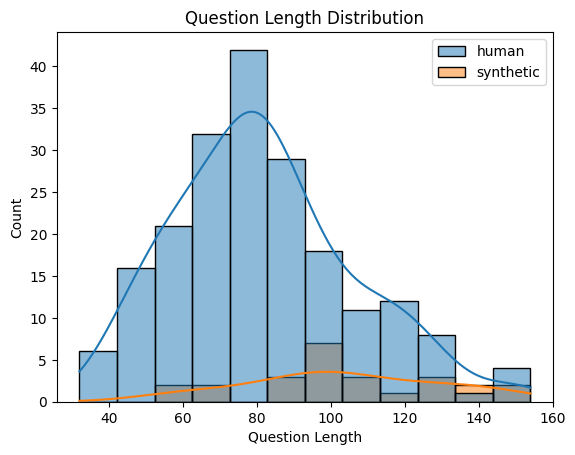

In [198]:
question_length = {
    "human": human_eval_df_media["question"].map(len),
    "synthetic": synthetic_eval_df_media["question"].map(len)
}

sns.histplot(question_length, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Question Length")
plt.ylabel("Count")
plt.show()

In [199]:
eval_df_media = pd.concat([human_eval_df_media, synthetic_eval_df_media], ignore_index=True)
eval_df_media["is_synthetic"] = eval_df_media["relevant_section"].isna()
eval_df_media["is_synthetic"].value_counts()

is_synthetic
False    200
True      25
Name: count, dtype: int64

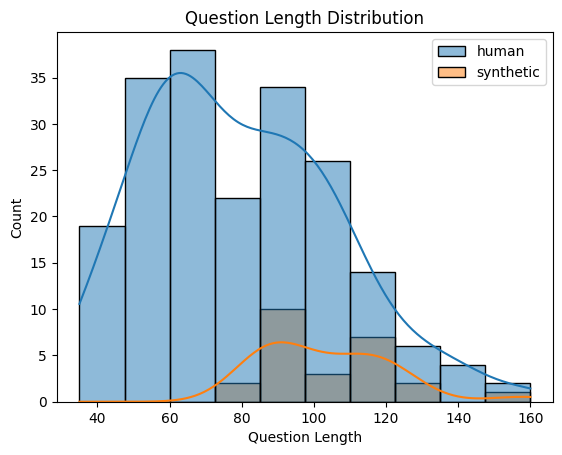

In [200]:
question_length = {
    "human": human_eval_df_patent["question"].map(len),
    "synthetic": synthetic_eval_df_patent["question"].map(len)
}

sns.histplot(question_length, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Question Length")
plt.ylabel("Count")
plt.show()

In [201]:
eval_df_patent = pd.concat([human_eval_df_patent, synthetic_eval_df_patent], ignore_index=True)
eval_df_patent["is_synthetic"] = eval_df_patent["relevant_section"].isna()
eval_df_patent["is_synthetic"].value_counts()

is_synthetic
False    200
True      25
Name: count, dtype: int64

Now we have doubled the number of questions and answers. However, we can see that our synthetic questions are slightly longer than the provided questions which could mean that they are slightly easier to answer. This potential bias should be taken into account when evaluating the pipeline.

### RAGAS Metrics

RAGAS provides a variety of metrics to evaluate the performance of a RAG pipeline. Here are some of the key metrics we will be using and how they are calculated:

- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html): This metric measures the relevance of the generated answer to the user query. The Answer Relevancy is defined as the mean cosine similartiy of the original question to a number of artifical questions, which where generated (reverse engineered) based on the answer.
- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html): This metric measures the correctness of the generated answer. Answer correctness encompasses two critical aspects: semantic similarity between the generated answer and the ground truth, as well as factual similarity. These aspects are combined using a weighted scheme to formulate the answer correctness score.
- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html): This metric measures how well the generated answer is faithful to the retrieved chunks. The generated answer is regarded as faithful if all the claims that are made in the answer can be inferred from the given context. To calculate this a set of claims from the generated answer is first identified. Then each one of these claims are cross checked with given context to determine if it can be inferred from given context or not.
- [Context Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/context_relevancy.html): This metric measures the relevance of the retrieved chunks to the user query. Ideally, the retrieved context should exclusively contain essential information to address the provided query. To compute this, we initially estimate the number of sentences within the retrieved context that are relevant for answering the given question and devide it by the total number of sentences in the retrieved context.

![ragas-metrics](https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fd3cfa382-3a0b-4424-b8c1-e0d4d4a1efec_1600x683.png)

For this to work we create a test dataset for each of our RAG pipelines that contains the evaluation questions and their ground truth answers. We then run all the questions through our RAG pipeline and store the generated answers and the retrieved chunks. We can then use this test dataset to calculate the RAGAS metrics.

In [388]:
from datasets import Dataset
import json
from tqdm import tqdm

datasets_folder = gold_folder / "datasets"
datasets_folder.mkdir(exist_ok=True)

# Recursive cleaning for PyArrow compatibility
def clean_for_arrow(value):
    if isinstance(value, list):
        return [clean_for_arrow(v) for v in value]
    if value is None or isinstance(value, float):
        return ""
    return str(value)

def convert_to_strings(datapoints):
    return {key: clean_for_arrow(val) for key, val in datapoints.items()}

def get_or_create_eval_dataset(name: str, df: pd.DataFrame, chain) -> Dataset:
    dataset_file = datasets_folder / f"{name}_dataset.json"

    if dataset_file.exists():
        with open(dataset_file, "r") as file:
            raw_data = json.load(file)
            cleaned_data = convert_to_strings(raw_data)
            dataset = Dataset.from_dict(cleaned_data)
        print(f"Loaded {name} dataset from {dataset_file}")
    else:
        datapoints = {
            "question": df["question"].tolist(),
            "answer": [],
            "contexts": [],
            "ground_truth": df["ground_truth"].tolist(),
            "context_urls": [],
            "category": df["category"].tolist() if "category" in df.columns else ["" for _ in df.index]
        }

        for question in tqdm(datapoints["question"], desc=f"Generating {name}"):
            result = chain.invoke(question)
            datapoints["answer"].append(result.get("answer", ""))
            datapoints["contexts"].append([doc.page_content for doc in result.get("context", [])])
            datapoints["context_urls"].append([doc.metadata.get("url", "") for doc in result.get("context", [])])

        # Clean data before writing to JSON and converting to Dataset
        cleaned_data = convert_to_strings(datapoints)

        with open(dataset_file, "w") as file:
            json.dump(cleaned_data, file)

        dataset = Dataset.from_dict(cleaned_data)
        print(f"Saved {name} dataset to {dataset_file}")

    return dataset

In [204]:
def plot_llm_eval(name: str, eval_results: pd.DataFrame):
    # select only the float64 columns (assuming these are the RAGAS metrics)
    ragas_metrics_data = (eval_results
                        .select_dtypes(include=[np.float64]))


    # boxplot of distributions
    sns.boxplot(data=ragas_metrics_data, palette="Set2")
    plt.title(f'{name}: Distribution of RAGAS Evaluation Metrics')
    plt.ylabel('Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # barplot of means
    means = ragas_metrics_data.mean()
    plt.figure(figsize=(14, 8))
    sns.barplot(x=means.index, y=means, palette="Set2")
    plt.title(f'{name}: Mean of RAGAS Evaluation Metrics')
    plt.ylabel('Mean Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [205]:
def plot_multiple_evals(eval_results: Dict[str, pd.DataFrame]):
    # combine the results
    full_results = []
    for name, results in eval_results.items():
        results['name'] = name
        full_results.append(results)

    full_results = pd.concat(full_results, ignore_index=True)
    full_results = full_results.sort_values(by='name')


    # select only the float64 columns (assuming these are the RAGAS metrics)
    ragas_metrics_data = full_results.select_dtypes(include=[np.float64])
    ragas_metrics_data['name'] = full_results['name']

    # boxplot of distributions
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='variable', y='value', hue='name', data=pd.melt(ragas_metrics_data, id_vars='name'), palette="Set2")
    plt.title('Distribution of RAGAS Evaluation Metrics by Model')
    plt.ylabel('Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

    # barplot of means
    means = ragas_metrics_data.groupby('name').mean().reset_index()
    means_melted = pd.melt(means, id_vars='name')

    plt.figure(figsize=(14, 8))
    sns.barplot(x='variable', y='value', hue='name', data=means_melted, palette="Set2")
    plt.title('Mean of RAGAS Evaluation Metrics by Model')
    plt.ylabel('Mean Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

In [206]:
def plot_multiple_evals_by_category(eval_results: Dict[str, pd.DataFrame]):
    # Combine all results into one DataFrame
    full_results = pd.concat(eval_results.values(), ignore_index=True)

    # Drop rows without a valid 'category'
    if "category" not in full_results.columns:
        print("No 'category' column found in the provided data.")
        return

    full_results = full_results.dropna(subset=["category"])
    full_results = full_results[full_results["category"].astype(str).str.strip() != ""]

    if full_results.empty:
        print("All rows are missing 'category'. Nothing to plot.")
        return

    # Select RAGAS metric columns (float64) and keep category
    ragas_metrics_data = full_results.select_dtypes(include=[np.float64])
    ragas_metrics_data["category"] = full_results["category"]

    # Boxplot of distributions by category
    plt.figure(figsize=(14, 8))
    sns.boxplot(
        x='variable', y='value', hue='category',
        data=pd.melt(ragas_metrics_data, id_vars='category'),
        palette="Set2"
    )
    plt.title('Distribution of RAGAS Evaluation Metrics by Category')
    plt.ylabel('Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Category')
    plt.tight_layout()
    plt.show()

    # Barplot of means by category
    means = ragas_metrics_data.groupby('category').mean().reset_index()
    means_melted = pd.melt(means, id_vars='category')

    plt.figure(figsize=(14, 8))
    sns.barplot(
        x='variable', y='value', hue='category',
        data=means_melted, palette="Set2"
    )
    plt.title('Mean of RAGAS Evaluation Metrics by Category')
    plt.ylabel('Mean Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Category')
    plt.tight_layout()
    plt.show()


In [207]:
# selected_dataset = get_or_create_eval_dataset("selected", eval_df, selected_chain)

In [295]:
selected_dataset_media = get_or_create_eval_dataset("selected_media", eval_df_media, selected_chain_media)

Loaded selected_media dataset from data/data_new/gold/datasets/selected_media_dataset.json


In [296]:
selected_dataset_patent = get_or_create_eval_dataset("selected_patent", eval_df_patent, selected_chain_patent)

Loaded selected_patent dataset from data/data_new/gold/datasets/selected_patent_dataset.json


As a judge we use the GPT-4o-mini model. This model is a smaller version of the GPT-4o model. Whilst it is not as powerful as the full GPT-4o model it is still a very powerful model and can be used to evaluate the performance of our RAG pipeline without having to high costs.

It has also been suggest in Literature that when evaluating LLMs with LLMS as judges the evaluation is more reliable when the judge a different model than the model being evaluated. This is because the models might have learned to exploit the weaknesses of the other model or have a certain bias to there own answers.
https://arxiv.org/abs/2404.13076

In [219]:
def evaluate_sample_questions_for_df(eval_df):
    judge = ChatOpenAI(model="gpt-4o")
    question_prompt = ChatPromptTemplate.from_template(
        "Answer the following question: {question}")
    question_chain = question_prompt | judge | StrOutputParser()

    # Sample questions from eval_df
    sample_questions = eval_df["question"].sample(5).tolist()

    for question in sample_questions:
        try:
            response = question_chain.invoke({"question": question})
            print(f"Question: {question}\nResponse: {response}\n")
        except Exception as e:
            print(f"Error processing question: {question}\nError: {e}\n")

In [213]:
evaluate_sample_questions_for_df(eval_df_media)

Question: Who awarded the largest-ever offshore wind auction in Germany?
Response: Germany's largest-ever offshore wind auction was awarded by the Federal Network Agency (Bundesnetzagentur). This auction marked a significant step in the country's efforts to expand its renewable energy capacity.

Question: What is the significance of Tesla's Gigafactory Texas?
Response: Tesla's Gigafactory Texas, also known as Giga Texas or Gigafactory Austin, holds substantial significance for several reasons:

1. **Strategic Location**: Situated near Austin, Texas, this factory is centrally located, which helps Tesla optimize logistics and distribution across the United States. This location is advantageous for shipping vehicles to both the East and West coasts and accessing international markets via Gulf ports.

2. **Increased Production Capacity**: Giga Texas is a key component of Tesla's strategy to increase its production capacity. It is expected to produce a large volume of vehicles annually, inc

In [214]:
evaluate_sample_questions_for_df(eval_df_patent)

Question: What problem does the power control method aim to solve?
Response: The power control method aims to solve the problem of managing and optimizing the transmission power levels of devices in wireless communication networks. The primary goals are to:

1. **Minimize Interference:** By adjusting the power levels, the method reduces interference between devices, which is crucial for maintaining the quality of communication in densely populated networks.

2. **Improve Signal Quality:** Proper power control ensures that the signal-to-noise ratio (SNR) is maintained at an optimal level, improving the overall quality and reliability of the communication link.

3. **Extend Battery Life:** In battery-powered devices, power control helps conserve energy by using only the necessary amount of power to maintain a connection, thereby extending the device's operational life.

4. **Maximize Network Capacity:** Efficient power control allows more users to share the same frequency spectrum withou

### Evaluating the evaluation datasets

In [ ]:
# selected_llm_eval_results = get_or_run_llm_eval("selected", selected_dataset, llm)
# plot_llm_eval("selected", selected_llm_eval_results)

Loaded selected_media evaluation results from data/data_new/gold/results/selected_media_llm_eval_results.csv


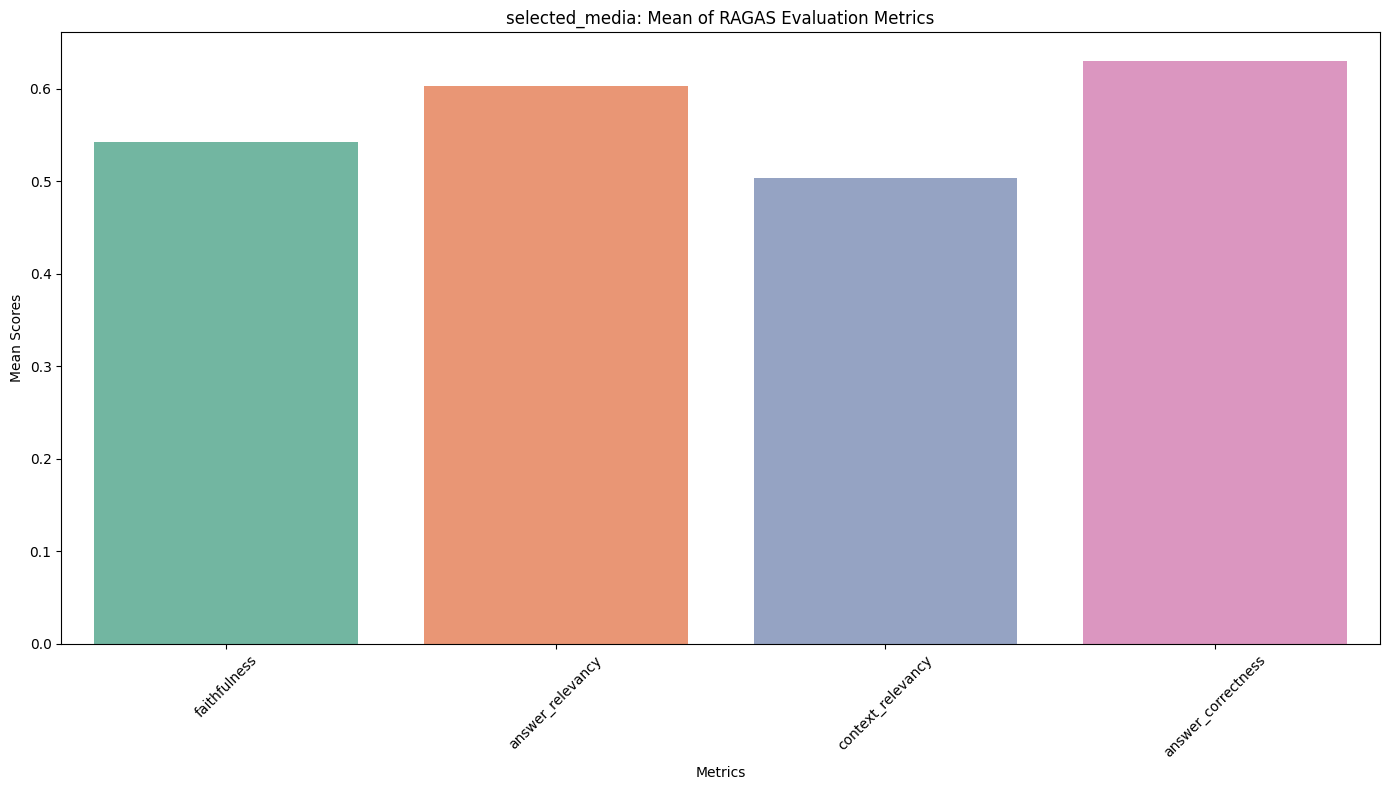

In [215]:
selected_media_llm_eval_results = get_or_run_llm_eval("selected_media", selected_dataset_media, llm)
plot_llm_eval("selected_media", selected_media_llm_eval_results)

Loaded selected_patent evaluation results from data/data_new/gold/results/selected_patent_llm_eval_results.csv


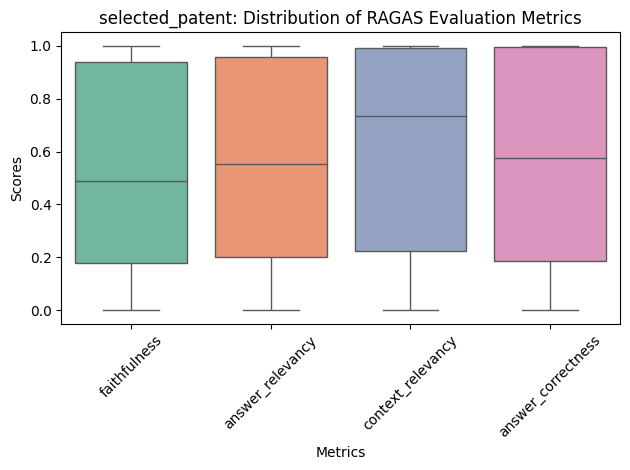

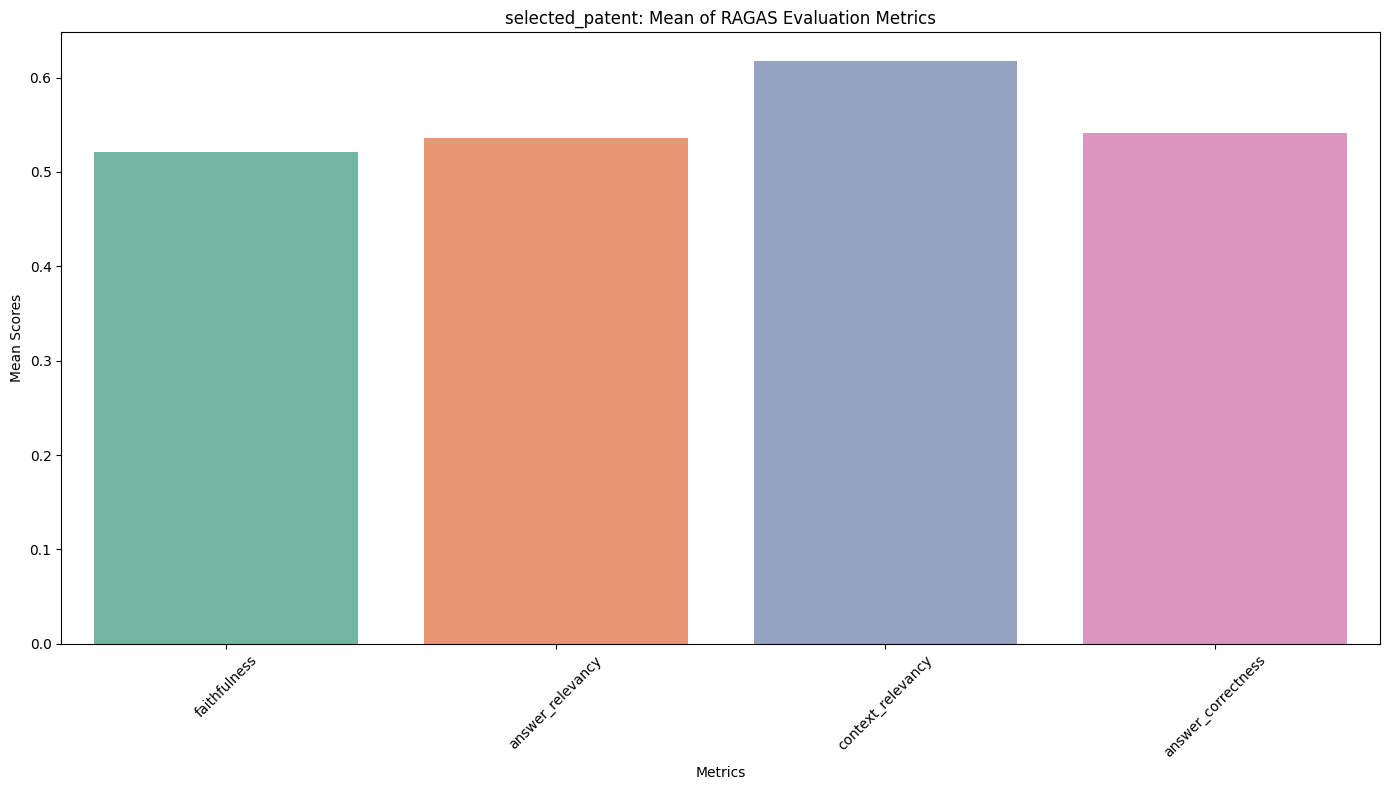

In [216]:
selected_patent_llm_eval_results = get_or_run_llm_eval("selected_patent", selected_dataset_patent, llm)
plot_llm_eval("selected_patent", selected_patent_llm_eval_results)

Here we could see for patent and media dataset the evaluation matrics are completely different. But for both of them evaluation mean scores are less than 0.6. The matrices faithfulness, answer relevance, context relevance and answer correctness have varied values for both the datasets. It shows how versatile our data is.

In [298]:
datasets = {}
for name, chain in chains.items():
    if "media" in name:
        datasets[name] = get_or_create_eval_dataset(name, eval_df_media, chain)
    elif "patent" in name:
        datasets[name] = get_or_create_eval_dataset(name, eval_df_patent, chain)

Loaded bge-m3_recursive_256_media dataset from data/data_new/gold/datasets/bge-m3_recursive_256_media_dataset.json
Loaded bge-m3_recursive_256_patent dataset from data/data_new/gold/datasets/bge-m3_recursive_256_patent_dataset.json
Loaded bge-m3_recursive_1024_media dataset from data/data_new/gold/datasets/bge-m3_recursive_1024_media_dataset.json
Loaded bge-m3_recursive_1024_patent dataset from data/data_new/gold/datasets/bge-m3_recursive_1024_patent_dataset.json
Loaded bge-m3_semantic_media dataset from data/data_new/gold/datasets/bge-m3_semantic_media_dataset.json
Loaded bge-m3_semantic_patent dataset from data/data_new/gold/datasets/bge-m3_semantic_patent_dataset.json


In [299]:
llm_results = {}
for dataset_name, dataset in datasets.items():
    llm_results[dataset_name] = get_or_run_llm_eval(dataset_name, dataset, llm)

Loaded bge-m3_recursive_256_media evaluation results from data/data_new/gold/results/bge-m3_recursive_256_media_llm_eval_results.csv
Loaded bge-m3_recursive_256_patent evaluation results from data/data_new/gold/results/bge-m3_recursive_256_patent_llm_eval_results.csv
Loaded bge-m3_recursive_1024_media evaluation results from data/data_new/gold/results/bge-m3_recursive_1024_media_llm_eval_results.csv
Loaded bge-m3_recursive_1024_patent evaluation results from data/data_new/gold/results/bge-m3_recursive_1024_patent_llm_eval_results.csv
Loaded bge-m3_semantic_media evaluation results from data/data_new/gold/results/bge-m3_semantic_media_llm_eval_results.csv
Loaded bge-m3_semantic_patent evaluation results from data/data_new/gold/results/bge-m3_semantic_patent_llm_eval_results.csv


We can see the comparison of different categories of the questions on the evaluation matrices for Media dataset. For media dataset Sustainability and Technological Innovation Questions work comparably better than others.

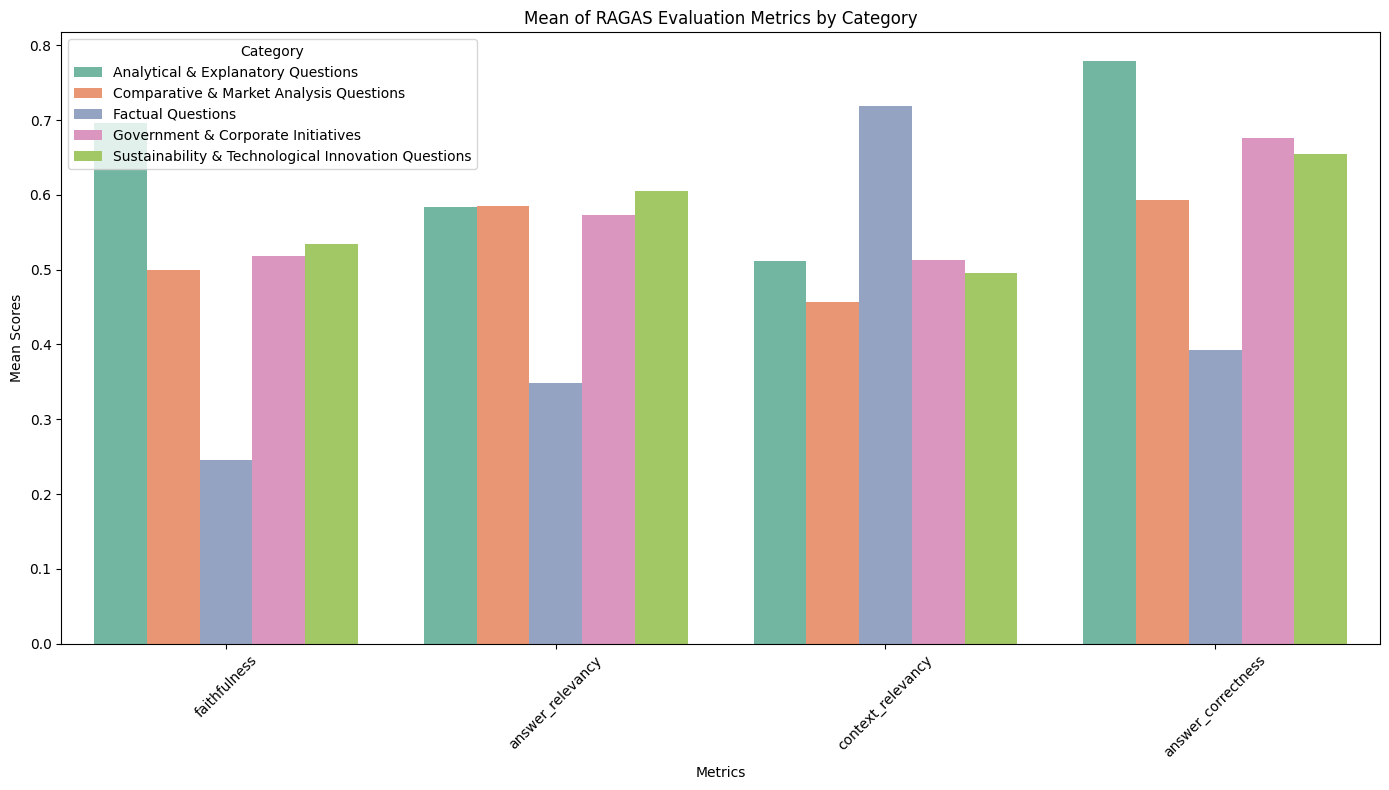

In [260]:
plot_multiple_evals_by_category({"selected_media": selected_media_llm_eval_results})

We can see the comparison of different categories of the questions on the evaluation matrices for Patent dataset. For patent dataset its hard to select one category as best performer. All have similar performance.

In [261]:
plot_multiple_evals_by_category({"selected_patent": selected_patent_llm_eval_results})

From the plot below we can conclude that semantic chunks has better results than others.

In [262]:
plot_multiple_evals(llm_results)

In [450]:
mean_scores = {}
for name, results in llm_results.items():
    mean_scores[name] = results.select_dtypes(include=[np.float64]).mean()

total_mean_scores = pd.DataFrame(mean_scores).mean()
total_mean_scores.sort_values(ascending=False)

bge-m3_semantic_patent          0.612933
bge-m3_semantic_media           0.603724
hyde_patent                     0.581985
bge-m3_recursive_256_media      0.570399
bge-m3_recursive_256_patent     0.564499
bge-m3_recursive_1024_patent    0.549984
hyde_media                      0.220992
bge-m3_recursive_1024_media          NaN
dtype: float64

From the evaluation we can see that the RAG pipeline using the BGE-M3 model along with semantic chunking with have on average across the metrics the best performance. This is likely due to the fact that these embedding models are the most powerful and the semantic chunking with a versatile chunk size has enough context to the LLM but not too much that it gets distracted.

In [456]:
best_collection_media = collections["bge-m3_semantic_media"]
best_store_media = collection_to_store("bge-m3_semantic_media", embedding_models["bge-m3"])

In [457]:
best_collection_patent = collections["bge-m3_semantic_patent"]
best_store_patent = collection_to_store("bge-m3_semantic_patent", embedding_models["bge-m3"])

## Advanced Methods

In this final section we will look at some more advanced methods to improve our RAG pipeline and comparing them to our best performing pipeline.

### Multi-Querying

Multi-querying is a technique that involves querying the retrieval model with multiple questions to retrieve relevant chunks. This approach can enhance the retrieval process by leveraging the diversity of queries to capture a broader range of relevant information. By combining the results from multiple queries, we can potentially improve the quality of the retrieved chunks and, consequently, the generated responses. When creating these additional queries the goal is to create queries that are different from the original query but still relevant to the user's information need, i.e variations of the original query.

![multi-querying](https://miro.medium.com/v2/resize:fit:1400/1*wa27F8CbKqYtaRRGyRKy0Q.png)

In [458]:
def generate_query_variations(query: str, num_additional_queries: int) -> List[str]:
    multiquery_prompt = """You are an assistant tasked with generating {num_queries} \
    different versions of the given user question to retrieve relevant documents from a vector \
    database. By generating multiple perspectives on the user question and breaking it down, your goal is to help \
    the user overcome some of the limitations of the distance-based similarity search. \
    Provide these alternative questions separated by newlines without any numbering or listing.
    Original question: {question}
    Alternatives:
    """

    multiquery_chain = ChatPromptTemplate.from_template(multiquery_prompt) | llm
    return multiquery_chain.invoke({"question": query, "num_queries": num_additional_queries}).content.split("\n")

In [459]:
def plot_multiquery_retrieval_results(query: str, collection : Collection, num_additional_queries: int = 3, num_results: int = 3):
    vectors = get_vectors_from_collection(collection)
    umap_transform = fit_umap(vectors)
    vectors_projections = project_embeddings(vectors, umap_transform)

    query_projections = project_embeddings(collection._embedding_function([query]), umap_transform)

    query_variations = generate_query_variations(query, 5)
    query_variations_projections = project_embeddings(collection._embedding_function(query_variations), umap_transform)

    original_relevant_docs = collection.query(
        query_texts=[query],
        n_results=num_results,
    )
    original_relevant_docs_ids = [item for sublist in original_relevant_docs["ids"] for item in sublist] # flatten
    original_relevant_docs_embeddings = collection.get(include=["embeddings"], ids=original_relevant_docs_ids)["embeddings"]
    original_relevant_docs_projections = project_embeddings(original_relevant_docs_embeddings, umap_transform)

    additional_relevant_docs = collection.query(
        query_texts=query_variations,
        n_results=num_results,
    )
    additional_relevant_docs_ids = [item for sublist in additional_relevant_docs["ids"] for item in sublist] # flatten
    # remove duplicates
    additional_relevant_docs_ids = list(set(additional_relevant_docs_ids))
    # remove the original relevant docs from the additional relevant docs
    additional_relevant_docs_ids = [doc_id for doc_id in additional_relevant_docs_ids if doc_id not in original_relevant_docs_ids]
    additional_relevant_docs_embeddings = collection.get(include=["embeddings"], ids=additional_relevant_docs_ids)["embeddings"]
    additional_relevant_docs_projections = project_embeddings(additional_relevant_docs_embeddings, umap_transform)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1], mode='markers', marker=dict(size=5), name="other vectors"))
    fig.add_trace(go.Scatter(x=query_projections[:, 0], y=query_projections[:, 1], mode='markers', marker=dict(size=7, color='black', symbol='x'), name="original query"))
    fig.add_trace(go.Scatter(x=query_variations_projections[:, 0], y=query_variations_projections[:, 1], mode='markers', marker=dict(size=7, color='red', symbol='x'), name="query variations"))
    fig.add_trace(go.Scatter(x=original_relevant_docs_projections[:, 0], y=original_relevant_docs_projections[:, 1], mode='markers', marker=dict(size=7, color='orange'), name="original relevant docs"))
    fig.add_trace(go.Scatter(x=additional_relevant_docs_projections[:, 0], y=additional_relevant_docs_projections[:, 1], mode='markers', marker=dict(size=7, color='green'), name="additional relevant docs"))

    fig.show(renderer="colab")

In [460]:
plot_multiquery_retrieval_results("Climate Change", selected_collection_media)

In [461]:
plot_multiquery_retrieval_results("Climate Change", selected_collection_patent)

In [462]:
class MultiQueryRetriever(BaseRetriever):
    store: VectorStore
    num_additional_queries: int = 3
    num_results: int = 3

    def _get_query_variations(self, query: str) -> List[str]:
       return generate_query_variations(query, self.num_additional_queries)

    def _get_relevant_documents(
        self, original_query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        queries = self._get_query_variations(original_query)
        queries.append(original_query)
        retriever = store_to_retriever(self.store, k=self.num_results)
        relevant_docs = []
        for query in queries:
            results = retriever.invoke(query)
            # remove duplicates
            for res in results:
                if res not in relevant_docs:
                    relevant_docs.append(res)
        return relevant_docs


In [463]:
multiquery_retriever = MultiQueryRetriever(store=best_store_media, num_additional_queries=3, num_results=3)
multiquery_chain = create_qa_chain(multiquery_retriever)
multiquery_chain.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

{'context': [Document(metadata={'domain': 'cleantechnica', 'id': 554, 'title': 'Flooding Issue in NYC? Rooftop Gardens for Bus Stops to the Rescue!', 'url': 'cleantechnica.com/2023/06/15/flooding-issue-in-nyc-rooftop-gardens-for-bus-stops-to-the-rescue'}, page_content='Advertise with CleanTechnica to get your company in front of millions of monthly readers. In the midst of eye-popping summer precipitation in New England, the Deputy Commissioner at the New Hampshire Insurance Department, D.J. Bettencourt, encouraged New Hampshire... This summer the Northern Hemisphere has been so hot with record temperatures — including at sea — that discussions have turned to the limits... Copyright © 2023 CleanTechnica.'),
  Document(metadata={'domain': 'energy-xprt', 'id': 1305, 'title': 'Fossil Power Plant ( Fossil Energy) Articles', 'url': 'energy-xprt.com/fossil-energy/fossil-power-plant/articles'}, page_content="So why aren't developers flocking... The American Lung Association's agenda for the n

In [273]:
multiquery_retriever = MultiQueryRetriever(store=best_store_patent, num_additional_queries=3, num_results=3)
multiquery_chain = create_qa_chain(multiquery_retriever)
multiquery_chain.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

{'context': [Document(metadata={'id': 921, 'title': 'Control method of hydrogen energy combustion-supporting ultralow nitrogen combustor', 'topic': 4}, page_content='on the analysis result, the fuel quantity of various substances involved in the combustion process and the recovery quantity of high-temperature flue gas are adjusted, so that new combustible ultralow-nitrogen and hydrogen-rich mixed gas with a brand new proportion is realized, and the purposes of increasing the combustion temperature, ultralow-nitrogen emission, minimum smoke discharge and energy conservation and environmental protection are achieved.'),
  Document(metadata={'id': 1721, 'title': 'Standby fire extinguishing system', 'topic': 9}, page_content='Standby fire extinguishing system: The utility model relates to the field of fire protection, in particular to a standby fire protection system which comprises a power supply module, an environment detection module, a main controller and a fire protection module; the 

In [464]:
def run_multiquery_strategy(eval_df, strategy_name):
    strategy_results = {}

    if "media" in strategy_name:
        key = "multiquery_media"
    elif "patent" in strategy_name:
        key = "multiquery_patent"
    else:
        raise ValueError(f"Unknown strategy name: {strategy_name}")

    # Step 1: Create or get the dataset
    datasets[key] = get_or_create_eval_dataset(key, eval_df, multiquery_chain)

    # Step 2: Run or retrieve the evaluation results
    llm_results[key] = get_or_run_llm_eval(key, datasets[key], llm)

    # Step 3: Store results and plot
    strategy_results[strategy_name] = llm_results.get(strategy_name, {})
    strategy_results[key] = llm_results[key]

    plot_multiple_evals(strategy_results)


### For media dataset

In [482]:
from datasets import Dataset
import json
from tqdm import tqdm

datasets_folder = gold_folder / "datasets"
datasets_folder.mkdir(exist_ok=True)

# Recursive cleaning for PyArrow compatibility
def clean_for_arrow(value):
    if isinstance(value, list):
        return [clean_for_arrow(v) for v in value]
    if value is None or isinstance(value, float):
        return ""
    return str(value)

def convert_to_strings(datapoints):
    return {key: clean_for_arrow(val) for key, val in datapoints.items()}

def get_or_create_eval_dataset(name: str, df: pd.DataFrame, chain) -> Dataset:
    dataset_file = datasets_folder / f"{name}_dataset.json"

    if dataset_file.exists():
        with open(dataset_file, "r") as file:
            raw_data = json.load(file)
            cleaned_data = convert_to_strings(raw_data)
            dataset = Dataset.from_dict(cleaned_data)
        print(f"Loaded {name} dataset from {dataset_file}")
    else:
        datapoints = {
            "question": df["question"].tolist(),
            "answer": [],
            "contexts": [],
            "ground_truth": df["ground_truth"].tolist(),
            "context_urls": [],
            "category": df["category"].tolist() if "category" in df.columns else ["" for _ in df.index]
        }

        for question in tqdm(datapoints["question"], desc=f"Generating {name}"):
            result = chain.invoke(question)
            datapoints["answer"].append(result.get("answer", ""))
            datapoints["contexts"].append([doc.page_content for doc in result.get("context", [])])
            datapoints["context_urls"].append([doc.metadata.get("url", "") for doc in result.get("context", [])])

        # Clean data before writing to JSON and converting to Dataset
        cleaned_data = convert_to_strings(datapoints)

        with open(dataset_file, "w") as file:
            json.dump(cleaned_data, file)

        dataset = Dataset.from_dict(cleaned_data)
        print(f"Saved {name} dataset to {dataset_file}")

    return dataset


Generating multiquery_media: 100%|██████████| 100/100 [07:12<00:00,  4.33s/it]


Saved multiquery_media dataset to data/data_new/gold/datasets/multiquery_media_dataset.json
Loaded multiquery_media evaluation results from data/data_new/gold/results/multiquery_media_llm_eval_results.csv


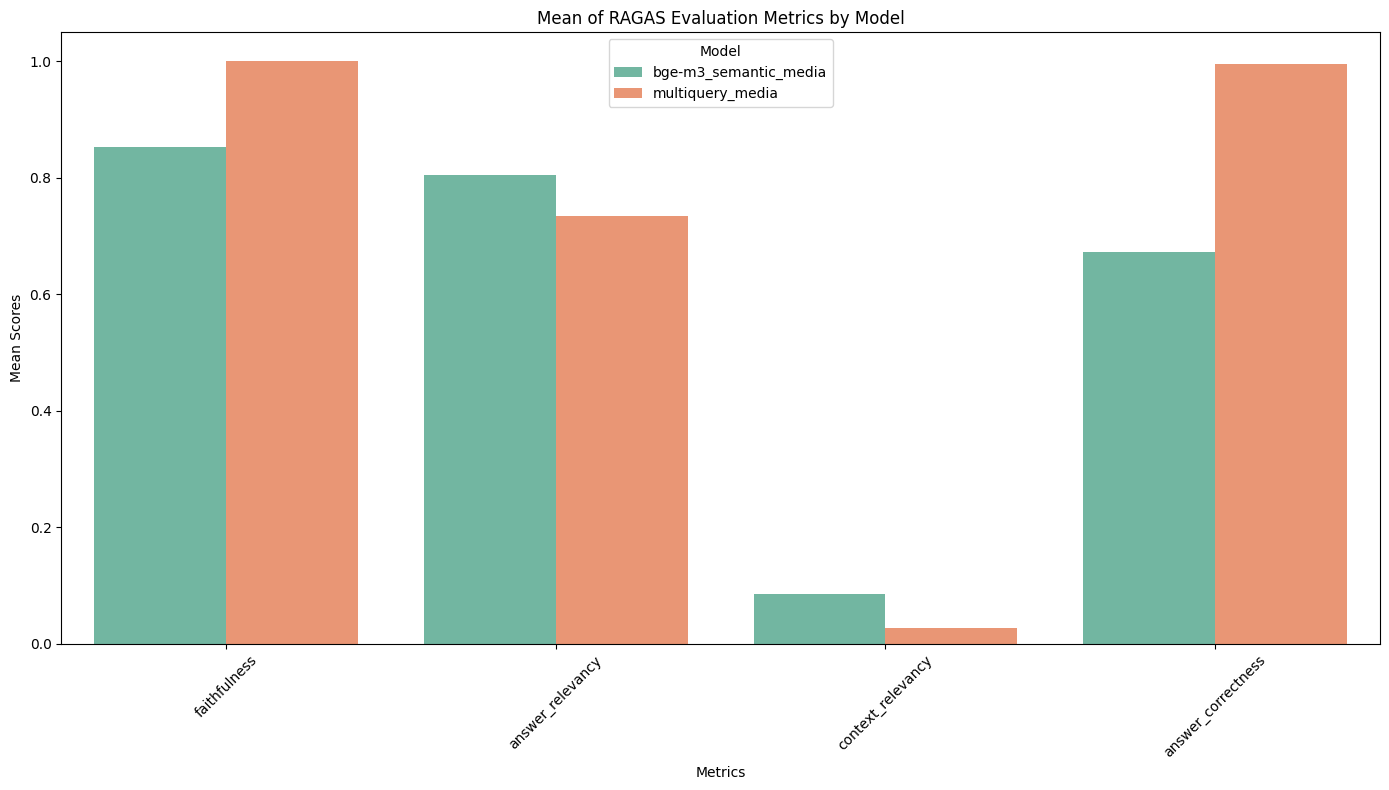

In [484]:
run_multiquery_strategy(eval_df_media.sample(100, random_state=42), "bge-m3_semantic_media")

We can see that on average the answer correctness and faithfullness does  increase when using multi-querying. This is likely due to the fact that the retrieval process is more robust and can capture a broader range of relevant information. However, the answer_relevancy and context_relevancy decrease could be due to the multi-querying introducing more noise into the retrieval process by retrieving more chunks in general and some of them being less relevant.

### For patent dataset

Loaded multiquery_patent dataset from data/data_new/gold/datasets/multiquery_patent_dataset.json
Loaded multiquery_patent evaluation results from data/data_new/gold/results/multiquery_patent_llm_eval_results.csv


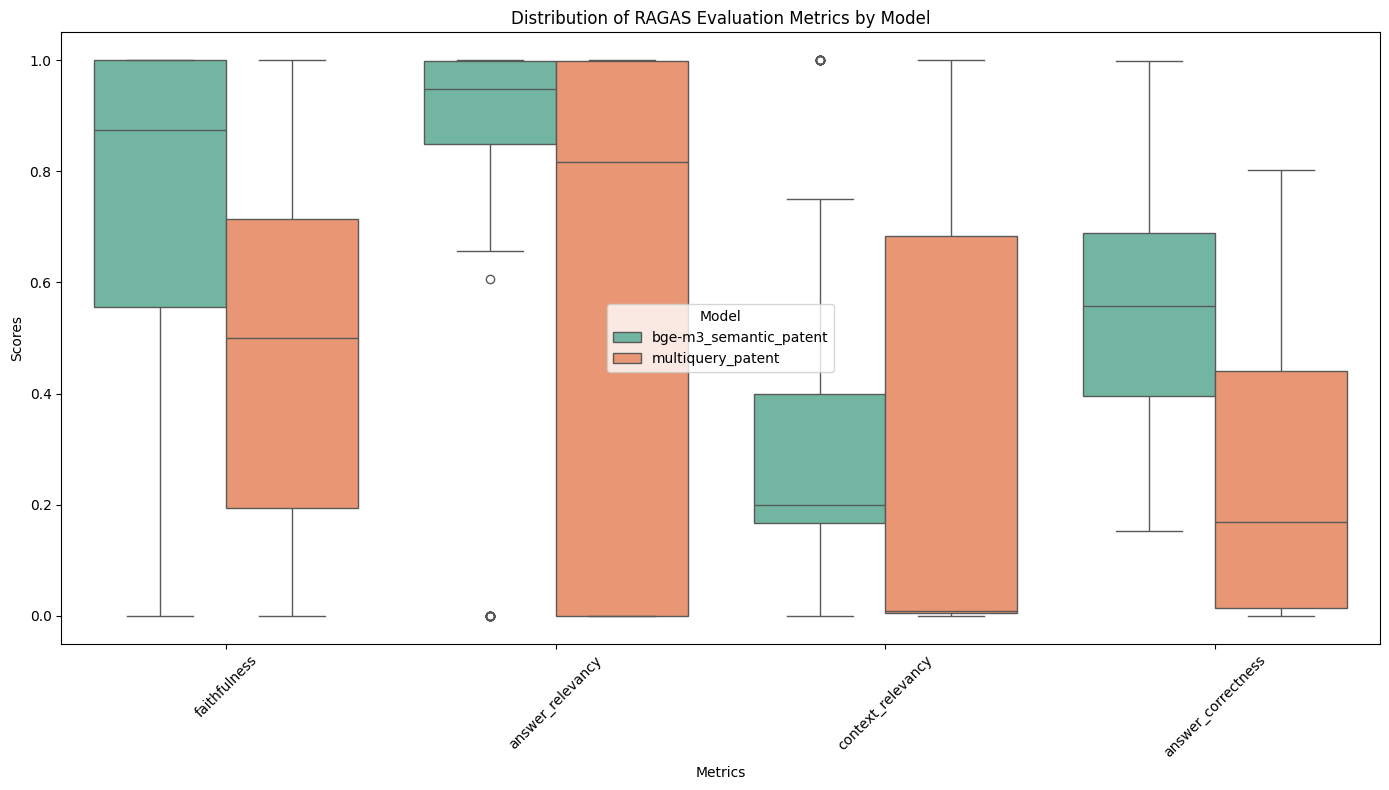

In [488]:
run_multiquery_strategy(eval_df_patent.sample(100, random_state=42), "bge-m3_semantic_patent")

With the above plot for patent dataset we can conclude that for patent dataset, using multiquery approach does not perform better than the original semantic embedding model.
But for media dataset it improves the correctness and faithfullness.

### HyDE - Hypothetical Document Embeddings

The idea of the HyDE method is to generate hypothetical documents that are similar to the user query and then retrieve the most similar chunks to these hypothetical documents. This can be useful when the user query is not very specific or when the user query is not very similar to the chunks. The HyDE method can be used to generate hypothetical documents that are more similar to the chunks and therefore improve the retrieval process. Another way to think about it is generating a hypothetical answer and therby reaching an area in the embedding space that is more similar to the actual answer which might not be reachable from the user query.

![hyde](https://miro.medium.com/v2/resize:fit:1200/1*vPX3TZXE5NQ0wHjrpI_muw.png)

In [467]:
def generate_hypothetical_document(query: str, num_hypotheses: int) -> List[str]:
    hyde_prompt = """Please write a news passage about the topic.
    Topic: {query}
    Passage:
    """

    hyde_chain = ChatPromptTemplate.from_template(hyde_prompt) | llm
    hypothetical_documents = [hyde_chain.invoke({"query": query}).content for _ in range(num_hypotheses)]
    return hypothetical_documents

In [468]:
def plot_hyde_retrieval_results(query: str, collection : Collection, num_hypo_documents: int = 2, num_results: int = 3):
    vectors = get_vectors_from_collection(collection)
    umap_transform = fit_umap(vectors)
    vectors_projections = project_embeddings(vectors, umap_transform)

    query_projections = project_embeddings(collection._embedding_function([query]), umap_transform)

    hypothetical_documents = generate_hypothetical_document(query, num_hypo_documents)
    query_variations_projections = project_embeddings(collection._embedding_function(hypothetical_documents), umap_transform)

    original_relevant_docs = collection.query(
        query_texts=[query],
        n_results=num_results,
    )
    original_relevant_docs_ids = [item for sublist in original_relevant_docs["ids"] for item in sublist] # flatten
    original_relevant_docs_embeddings = collection.get(include=["embeddings"], ids=original_relevant_docs_ids)["embeddings"]
    original_relevant_docs_projections = project_embeddings(original_relevant_docs_embeddings, umap_transform)

    additional_relevant_docs = collection.query(
        query_texts=hypothetical_documents,
        n_results=num_results,
    )
    additional_relevant_docs_ids = [item for sublist in additional_relevant_docs["ids"] for item in sublist] # flatten
    # remove duplicates
    additional_relevant_docs_ids = list(set(additional_relevant_docs_ids))
    # remove the original relevant docs from the additional relevant docs
    additional_relevant_docs_ids = [doc_id for doc_id in additional_relevant_docs_ids if doc_id not in original_relevant_docs_ids]
    additional_relevant_docs_embeddings = collection.get(include=["embeddings"], ids=additional_relevant_docs_ids)["embeddings"]
    additional_relevant_docs_projections = project_embeddings(additional_relevant_docs_embeddings, umap_transform)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1], mode='markers', marker=dict(size=5), name="other vectors"))
    fig.add_trace(go.Scatter(x=query_projections[:, 0], y=query_projections[:, 1], mode='markers', marker=dict(size=7, color='black', symbol='x'), name="original query"))
    fig.add_trace(go.Scatter(x=query_variations_projections[:, 0], y=query_variations_projections[:, 1], mode='markers', marker=dict(size=7, color='red', symbol='x'), name="hypothetical documents"))
    fig.add_trace(go.Scatter(x=original_relevant_docs_projections[:, 0], y=original_relevant_docs_projections[:, 1], mode='markers', marker=dict(size=7, color='orange'), name="original relevant docs"))
    fig.add_trace(go.Scatter(x=additional_relevant_docs_projections[:, 0], y=additional_relevant_docs_projections[:, 1], mode='markers', marker=dict(size=7, color='green'), name="additional relevant docs"))

    fig.show(renderer="colab")

In [469]:
plot_hyde_retrieval_results("Climate Change", selected_collection_media)

In [470]:
plot_hyde_retrieval_results("Climate Change", selected_collection_patent)

In [471]:
class HyDERetriever(BaseRetriever):
    store: VectorStore
    num_hypo_documents: int = 2
    num_results: int = 3

    def _get_hypothetical_documents(self, query: str) -> List[str]:
        return generate_hypothetical_document(query, self.num_hypo_documents)

    def _get_relevant_documents(
        self, original_query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:
        hypothetical_documents = self._get_hypothetical_documents(original_query)
        hypothetical_documents.append(original_query)
        retriever = store_to_retriever(self.store, k=self.num_results)
        relevant_docs = []
        for query in hypothetical_documents:
            results = retriever.invoke(query)
            # remove duplicates
            for res in results:
                if res not in relevant_docs:
                    relevant_docs.append(res)
        return relevant_docs


In [472]:
hyde_retriever_media = HyDERetriever(store=best_store_media, k=3)
hyde_chain_media = create_qa_chain(hyde_retriever_media)
hyde_chain_media.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

{'context': [Document(metadata={'domain': 'energy-xprt', 'id': 1305, 'title': 'Fossil Power Plant ( Fossil Energy) Articles', 'url': 'energy-xprt.com/fossil-energy/fossil-power-plant/articles'}, page_content="So why aren't developers flocking... The American Lung Association's agenda for the new administration, Protect the Air We Breathe: An Agenda for Clean Air, states: `` Climate, energy and clean air are inexorably linked. Solutions that lead to cleaner air must be included in any approach to cleaner, more efficient energy use and reductions in global warming. '' 1 Wind energy is one such solution - a clean energy source that can... The State of Illinois has the largest non–renewable ( fossil) energy reserves among all the states in the USA. We report our studies on coal, oil and gas energy resources, conversions, consumptions and carbon dioxide sequestration advances in Illinois from the point of view of sustainability in energy and environmental. This includes reserves and charact

In [473]:
hyde_retriever_patent = HyDERetriever(store=best_store_patent, k=3)
hyde_chain_patent = create_qa_chain(hyde_retriever_patent)
hyde_chain_patent.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

{'context': [Document(metadata={'id': 238, 'title': 'Method for cleaning the air basins of cities from smog and pollutants in the surface layer', 'topic': 1}, page_content='Due to the difference in air temperature near the water surface and the heated layers in the tower, an upward air flow is created. They use a tower installed with the help of support platforms at the base on two barges separated from each other, oriented against the flow of the river in the longitudinal direction, and a tower in the form of a cone with a black coating of its fence. EFFECT: method provides for the creation of natural convection of air masses by thermal heating of air in the tower due to solar energy and obtaining an upward air flow that promotes the appearance of circulation movement near the tower, the creation of thrust, removal and dispersion of harmful impurities from the surface zone into the upper atmosphere. 2 cl, 2 dwg'),
  Document(metadata={'id': 580, 'title': 'Offshore power generation dev

In [474]:
def run_hyde_strategy(eval_df, strategy_name):
    # Initialize a dictionary to store the results
    strategy_results = {}

    # Step 1: Create or get the dataset based on strategy
    if "media" in strategy_name:
        key = "hyde_media"
    elif "patent" in strategy_name:
        key = "hyde_patent"

    # Create or get the dataset
    datasets[key] = get_or_create_eval_dataset(key, eval_df, chain)

    # Step 2: Run or retrieve the evaluation results
    llm_results[key] = get_or_run_llm_eval(key, datasets[key], llm)

    # Step 3: Store results and plot
    strategy_results[strategy_name] = llm_results.get(strategy_name, {})
    strategy_results[key] = llm_results[key]

    # Step 4: Plot the results (for visualization)
    plot_multiple_evals(strategy_results)


### For media dataset

Generating hyde_media: 100%|██████████| 100/100 [01:47<00:00,  1.08s/it]

Saved hyde_media dataset to data/data_new/gold/datasets/hyde_media_dataset.json


Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

Saved hyde_media evaluation results to data/data_new/gold/results/hyde_media_llm_eval_results.csv


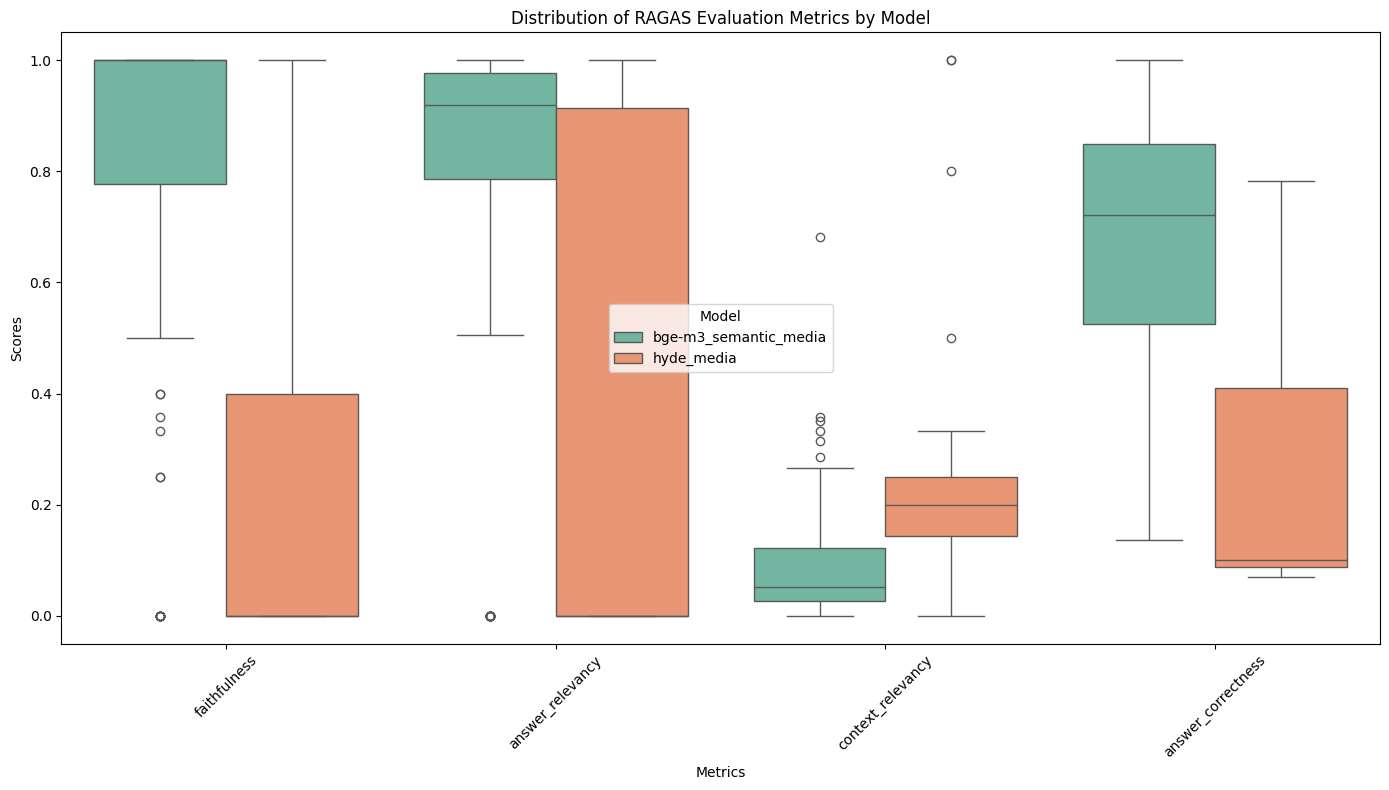

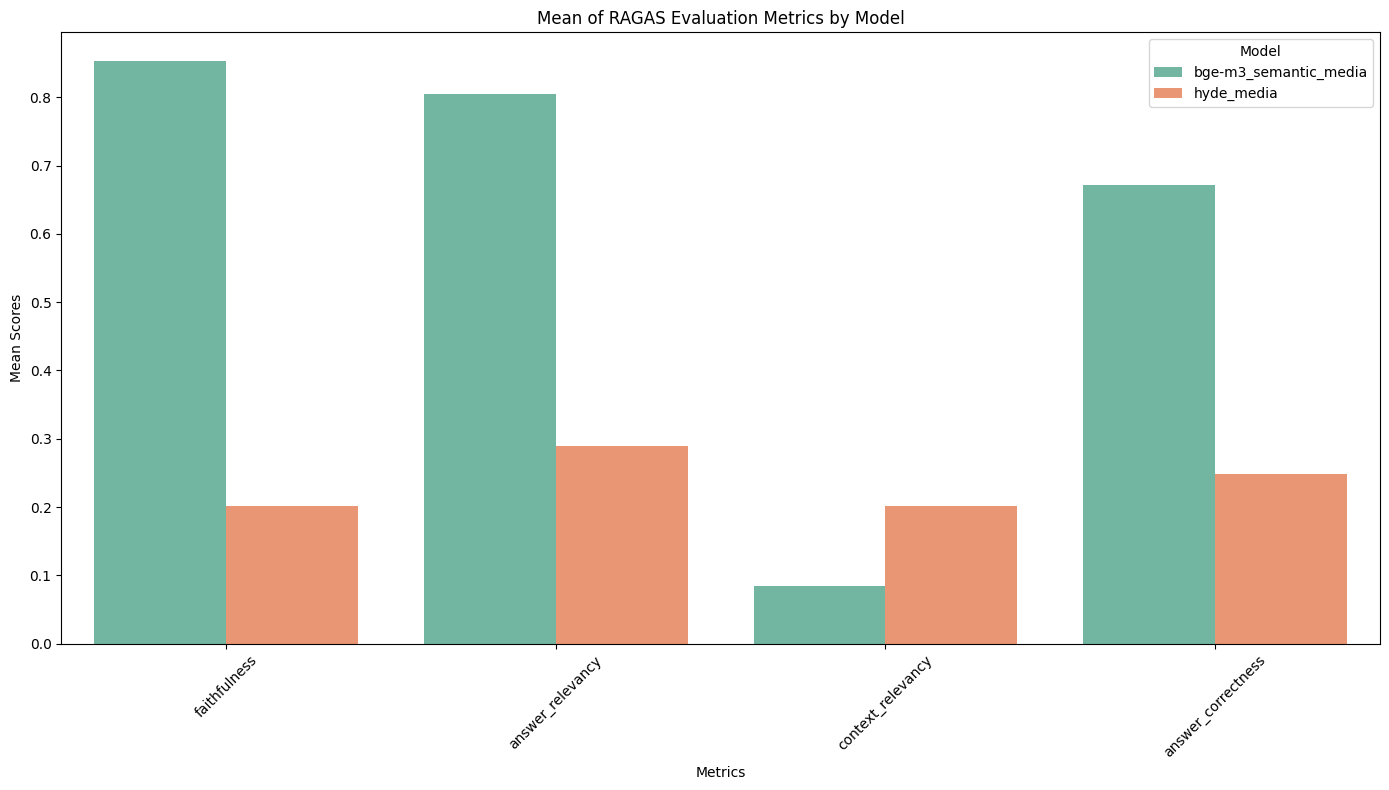

In [486]:
run_hyde_strategy(eval_df=eval_df_media.sample(100, random_state=42), strategy_name="bge-m3_semantic_media")

We can see that on average the context relevancy is the only matrix which increase when using Hyde approach. Original BGE-m3 semantic model performs way better than the Hyde approach for media dataset overall for correctness, faithfullness and answer relevancy.

### For Patent Dataset

Generating hyde_patent: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]

Saved hyde_patent dataset to data/data_new/gold/datasets/hyde_patent_dataset.json


Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

Saved hyde_patent evaluation results to data/data_new/gold/results/hyde_patent_llm_eval_results.csv


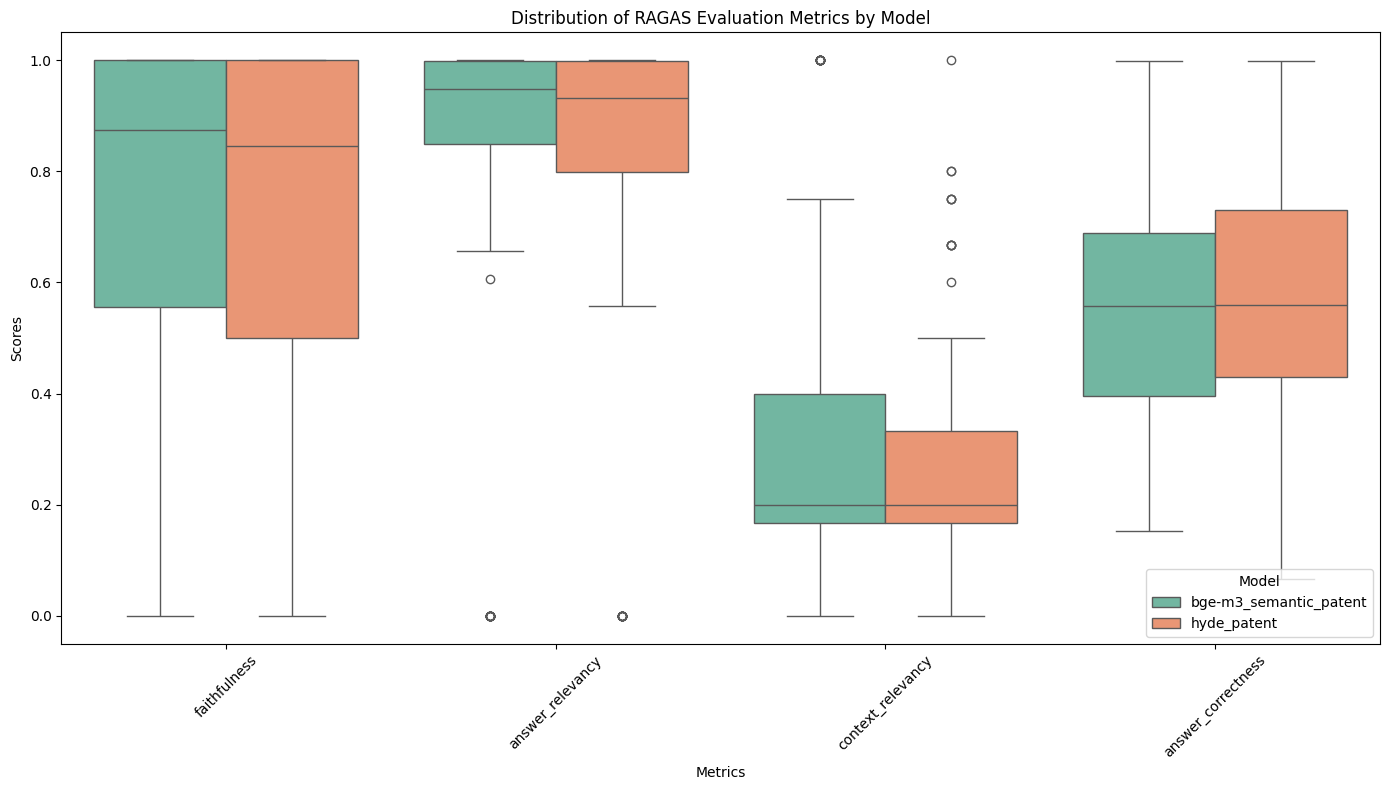

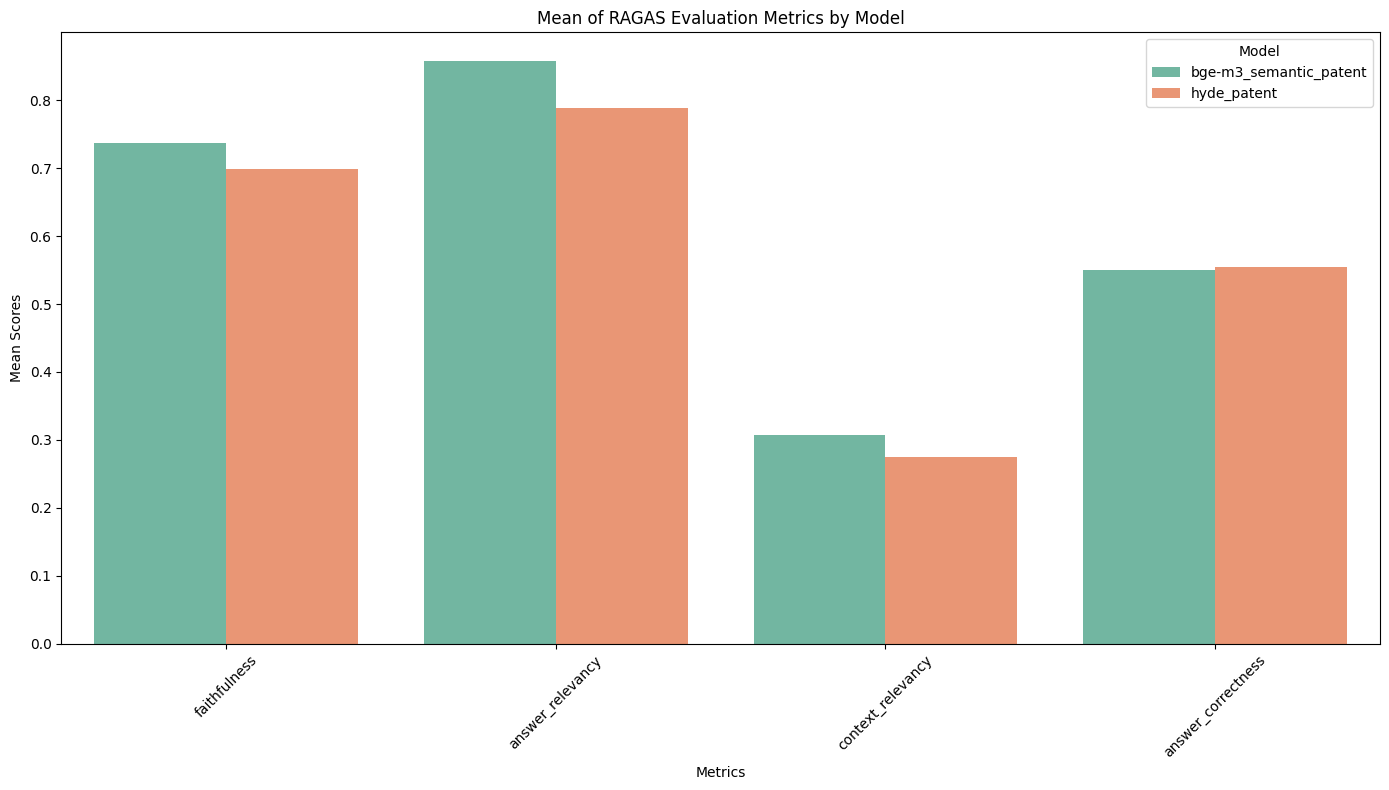

In [487]:
run_hyde_strategy(eval_df=eval_df_patent.sample(100, random_state=42), strategy_name="bge-m3_semantic_patent")

There is a bit icrease in the correctness matrix. But all other matrics are comparable but no improvement.

### Other Methods

There are many other methods that can be used to improve the RAG pipeline. Some of these include:
- [Step Back](https://arxiv.org/abs/2310.06117): Where the idea is to take a step back and understand the concepts and context of the user query and then use this information to retrieve the most relevant chunks.
- [Hybrid Search](https://medium.com/@zilliz_learn/hybrid-search-combining-text-and-image-for-enhanced-search-capabilities-3d3ce27de326): Where the idea is to not only use semantic search but also lexical search to retrieve the most relevant chunks and combine the results with a re-ranking step.

In [421]:
os.system("jupyter nbconvert --to html --template pj cleantech_rag.ipynb")

65280

In [ ]:
!jupyter nbconvert --to html --execute --embed-images "/content/cleantech_rag_updated2 (6).ipynb"


[NbConvertApp] Converting notebook /content/cleantech_rag_updated2 (6).ipynb to html
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp] ERROR | unhandled iopub msg: colab_request
[NbConvertApp

In [412]:
from pathlib import Path
import shutil
from google.colab import files

# Path to the folder you want to zip
data_folder = Path("/content/data")

# Create zip file (this will be /content/data.zip)
zip_path = shutil.make_archive(str(data_folder), 'zip', root_dir=str(data_folder))

# Download the zip file
files.download(zip_path)
